## Bosquejo de *approach* fuera de la API de keras
#### Autor: Francisco Mena

In [1]:
#imports
import keras, time,os,sys,gc
from keras.layers import *
from keras.models import Sequential,Model
from keras.models import clone_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from sklearn.cluster import AffinityPropagation, SpectralClustering,AgglomerativeClustering,DBSCAN,KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from code.utils import *

In [3]:
DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

### Load Data

In [4]:
""" WINE
#df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",sep=';')
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')

df_red["normal"] = df_red["quality"]==5
df_red["good"] = df_red["quality"]>5
df_red["bad"] = df_red["quality"]<5
df_red["qualities"] = 0*df_red["bad"]+df_red["normal"]+2*df_red["good"]
df_red.drop(['quality','normal','good','bad'],axis=1,inplace=True)

y_train = df_red.pop("qualities").values*1
X_train = df_red.values

y_obs = np.loadtxt("annotations_wine.csv",delimiter=',',dtype='int')
"""

#from keras.datasets import cifar10
#(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
#y_obs = np.loadtxt("../syntetic/annotations_cifar.csv",delimiter=',',dtype='int')

#""" Syntetic data
X_train = np.loadtxt("./synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt("./synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal.csv",delimiter=',',dtype='int')
#y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal_soft.csv",delimiter=',',dtype='int')


X_test = np.loadtxt("./synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt("./synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
#"""

groups_annot = np.loadtxt("../syntetic/simple/annotgroups_datasim_normal.csv",delimiter=',',dtype='int')
load_matrix = np.loadtxt('./synthetic/simple/matrix_datasim_normal.csv',delimiter=',')
rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
confe_matrix = real_conf_matrix[groups_annot]


N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

Shape (data,annotators):  (2292, 100)
Classes:  3


In [6]:
path = "."
scenario=2

In [13]:
from code.generate_data import SinteticData

X_train = np.loadtxt(path+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(path+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(path+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(path+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth


from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    #GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')
    GenerateData.set_probas(asfile=False,file_matrix=aux1,file_groups =aux2)

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.5661375661375662
Shape (data,annotators):  (2457, 100)
Classes:  3


In [10]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

In [14]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation in params 3 is between --1 is for good fit (maybe overfitting)


TOL_LOSS = 1e-3 #tolerance for relative variation in log-likelihood ----REVISAAAR (ultima opcion) -- or

#number of groups is needed

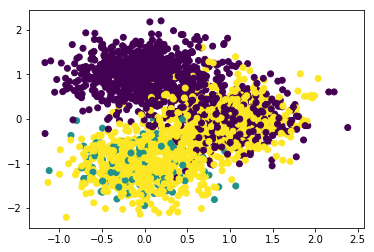

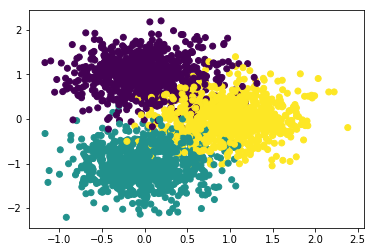

In [15]:
mv = majority_voting(y_obs,onehot=False,probas=False,repeats=False)
plt.scatter(X_train[:,0],X_train[:,1],c=mv)
plt.show()
plt.scatter(X_train[:,0],X_train[:,1],c=Z_train)

In [16]:
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

In [6]:
X_train = X_train.astype(DTYPE_OP)
X_test = X_test.astype(DTYPE_OP)
Xstd_train = X_train/255
Xstd_test = X_test/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

In [17]:
from code.representation import *
##transformar a repeat
r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)

vector of repeats:
 [[ 8  0  3]
 [ 0  3 12]
 [ 5  1  8]
 ...
 [ 4  0  5]
 [ 6  0  1]
 [ 6  0  3]]


In [111]:
from scipy.stats import entropy
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN,AffinityPropagation, MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
import gc, keras, time, sys

from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple #deep learning
from code.representation import *
from code.utils import softmax


def aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP='float32',option="softmax inv",l=0.005):
    # Get p(g=m|t)  based on a proyection of the annotator "t" 
    std = StandardScaler()
    data_to_cluster = std.fit_transform(data_to_cluster) 
        
    kmeans = MiniBatchKMeans(n_clusters=M, random_state=0,init='k-means++',batch_size=128)
    #KMeans(M,init='k-means++', n_jobs=-1,random_state=0)
    kmeans.fit(data_to_cluster)
    distances = kmeans.transform(data_to_cluster)

    if option=="fuzzy":
        probas_t = np.zeros_like(distances,dtype=DTYPE_OP)
        for t in range(probas_t.shape[0]):
            for m in range(probas_t.shape[1]):
                m_fuzzy = 1.2
                probas_t[t,m] = 1/(np.sum( np.power((distances[t,m]/(distances[t,:]+keras.backend.epsilon())), 2/(m_fuzzy-1)) ) + keras.backend.epsilon())
    elif option == "softmax":
        probas_t = softmax(-(distances+keras.backend.epsilon())/l).astype(DTYPE_OP)
    elif option == "softmax inv":
        probas_t = softmax(1/(l*distances+keras.backend.epsilon())).astype(DTYPE_OP)
    elif option == 'hard':
        probas_t = keras.utils.to_categorical(kmeans.labels_)
    #another option??
        #model = GaussianMixture(n_components=M)
        #model.fit(data_to_cluster)
        #probas_t = model.predict_proba(data_to_cluster).astype(DTYPE_OP)
    return probas_t
            
def clusterize_annotators(y_o,M,no_label=-1,bulk=True,cluster_type='loss',data=[],model=None,DTYPE_OP='float32',BATCH_SIZE=64,option="softmax inv",l=0.005):
    start_time = time.time()
    if bulk: 
        if len(y_o.shape) == 2:
            M_itj = categorical_representation(y_o,no_label =no_label)
        else:
            M_itj = y_o.copy()
        mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
        mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
        M_itj[mask_nan] = 1
        #M_itj = M_itj.astype(DTYPE_OP)
        #M_itj_norm = M_itj/M_itj.sum(axis=1,keepdims=True)#[:,None,:]
                
        if len(data) != 0:
            data_to_cluster = data.copy() #annotators_pca
        else:
            data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
            
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l) #0.05 is close to one-hot
        print("Clustering Done!")
        #alphas_init = np.tensordot(M_itj_norm,probas_t, axes=[[1],[0]]) 
        alphas_init = np.tensordot(M_itj, probas_t, axes=[[1],[0]]) 
        alphas_init = alphas_init/alphas_init.sum(axis=-1,keepdims=True) #normalize here for efficiency
    else: #sirve como auxiliar: y_o: is repeats
        if len(y_o.shape) == 2: 
            mv_hard = majority_voting(y_o,repeats=True,probas=False) 
        else:
            mv_hard = majority_voting(y_o,repeats=False,probas=False) 
        aux_model = keras.models.clone_model(model)
        aux_model.compile(loss='categorical_crossentropy',optimizer=model.optimizer)
        aux_model.fit(data, mv_hard, batch_size=BATCH_SIZE,epochs=30,verbose=0)
        predicted = aux_model.predict(data,verbose=0)
        data_to_cluster = []
        if cluster_type=='loss': #cluster respecto to loss function
            for i in range(mv_hard.shape[0]):
                for j in range(mv_hard.shape[1]):
                    ob = np.tile(keras.backend.epsilon(), mv_hard.shape[1])
                    ob[j] = 1
                    true = np.clip(predicted[i],keras.backend.epsilon(),1.)        
                    loss = np.sum(true*np.log(ob)) 
                    data_to_cluster.append([loss])
        data_to_cluster = np.asarray(data_to_cluster)
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l)
        print("Clustering Done!")
        alphas_init = probas_t.reshape(mv_hard.shape[0],mv_hard.shape[1],M)
    print("Get init alphas in %f mins"%((time.time()-start_time)/60.) )
    return alphas_init

def project_and_cluster(y_o,M_to_try=20,anothers_visions=True,DTYPE_OP='float32',printed=True,mode_project="pca"):
    ###another way to cluster..
    if len(y_o.shape) == 2:
        M_itj = categorical_representation(y_o,no_label =-1)
    else:
        M_itj = y_o.copy()
    data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
    data_to_cluster = data_to_cluster.astype(DTYPE_OP)
    
    if mode_project.lower() == "pca":
        model = PCA(n_components=4)
    elif mode_project.lower() == "tpca":
        model = TruncatedSVD(n_components=4)
    elif mode_project.lower() == "kpca":
        model = KernelPCA(n_components=4, kernel='rbf', n_jobs=-1)

    plot_data = model.fit_transform(data_to_cluster)
    to_return = [plot_data]
    
    if printed:
        model = BayesianGaussianMixture(n_components=M_to_try)
        model.fit(plot_data)
        M_founded = len(set(np.argmax(model.predict_proba(plot_data),axis=1))) 
        print("Bayesian gaussian mixture say is %d clusters "%M_founded)

        if anothers_visions:
            X_sim = metrics.pairwise_distances(plot_data,metric='euclidean',n_jobs=-1)
            #dos indicadores de numero de cluster
            model = DBSCAN(eps=np.mean(X_sim), min_samples=5, metric='precomputed', n_jobs=-1)
            model.fit(X_sim)
            print("DBSCAN say is %d clusters"%len(set(model.labels_)))
            model = AffinityPropagation(affinity='precomputed')
            model.fit(X_sim)
            print("Affinity Propagation say is %d clusters"%len(set(model.labels_)))

        to_return.append( M_founded )
    return to_return


class GroupMixtureOpt(object): #optimized version
    def __init__(self,input_dim,Kl,M=2,epochs=1,optimizer='adam',pre_init=10,dtype_op='float32'): 
        if type(input_dim) != tuple:
            input_dim = (input_dim,)
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        #params
        self.M = M #groups of annotators
        self.epochs = epochs
        self.optimizer = optimizer
        self.pre_init = pre_init
        self.DTYPE_OP = dtype_op
        
        self.Keps = keras.backend.epsilon() 
        self.priors=False #boolean of priors
        self.compile=False
        self.seted_alphainit = False
        self.lambda_random = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas.copy()
    def get_alpha(self):
        """Get alpha param, p(g) globally"""
        return self.alphas.copy()
    def set_alpha(self,alpha_init):
        """set alpha param with a previosuly method"""
        self.alpha_init = alpha_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        """Get Q estimation param, this is Q_ij(g,z) = p(g,z|xi,y=j)"""
        return self.Qij_mgamma.copy()
        
    def define_model(self,tipo,start_units=1,deep=1,double=False,drop=0.0,embed=True,BatchN=True):
        """Define the base model and other structures"""
        self.type = tipo.lower()     
        if self.type == "keras_shallow" or 'perceptron' in self.type: 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        elif self.type=='defaultcnn' or self.type=='default cnn':
            self.base_model = default_CNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnn' or self.type=='default rnn':
            self.base_model = default_RNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnnE' or self.type=='default rnn E': #with embedding
            self.base_mode = default_RNNw_emb(self.input_dim,self.Kl,len) #len is the length of the vocabulary
            #podria ser el maximo

        elif self.type == "ff" or self.type == "mlp" or self.type=='dense': #classic feed forward
            print("Needed params (units,deep,drop,BatchN?)") #default activation is relu
            self.base_model = MLP_Keras(self.input_dim,self.Kl,start_units,deep,BN=BatchN,drop=drop)

        elif self.type=='simplecnn' or self.type=='simple cnn' or 'cnn' in self.type:
            print("Needed params (units,deep,drop,double?,BatchN?)") #default activation is relu
            self.base_model = CNN_simple(self.input_dim,self.Kl,start_units,deep,double=double,BN=BatchN,drop=drop)
        
        elif self.type=='simplernn' or self.type=='simple rnn' or 'rnn' in self.type:
            print("Needed params (units,deep,drop,embed?)")
            self.base_model = RNN_simple(self.input_dim,self.Kl,start_units,deep,drop=drop,embed=embed,len=0,out=start_units*2)
            #and what is with embedd

        #if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
        #    self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        #     future..
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X):
        """Return the predictions of the model if is from sklearn or keras"""
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=self.batch_size)
    
    def init_E(self,X,r):
        """Realize the initialziation of the E step on the EM algorithm"""
        #-------> init alpha
        if not self.seted_alphainit: #random is the worst option
            self.alpha_init = np.random.dirichlet(np.ones(self.M)/50,size=(self.N,self.Kl))
        
        #-------> init Majority voting        
        self.mv_probs_j = majority_voting(r,repeats=True,probas=True) # soft -- p(y=j|xi)
        
        print("Pre-train network on %d epochs..."%(self.pre_init),end='',flush=True)
        mv_probs = keras.utils.to_categorical(self.mv_probs_j.argmax(axis=1)) # one-hot
        self.base_model.fit(X,mv_probs,batch_size=self.batch_size,epochs=self.pre_init,verbose=0)
        print(" Done!")
        #mv_probs = self.base_model.predict(X,verbose=0) 
        #reset optimizer but hold weights--necessary for stability 
        self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

        #-------> Initialize p(z=gamma|xi,y=j,g): Combination of mv and belive observable
        lambda_group = np.ones((self.M),dtype=self.DTYPE_OP) 
        if self.lambda_random:
            for m in range(self.M):
                lambda_group[m] = np.random.beta(1,1)
        print("Lambda by group: ",lambda_group)
        Zijm = np.zeros((self.N,self.Kl,self.M,self.Kl),dtype=self.DTYPE_OP)
        for j_ob in range(self.Kl):
            onehot = np.tile(self.Keps, self.Kl)
            onehot[j_ob] = 1. #all belive in the observable
            for m in range(self.M):                
                Zijm[:,j_ob,m,:] = lambda_group[m]*self.mv_probs_j + (1-lambda_group[m])*onehot 
          
        #-------> init q_ij      
        self.Qij_mgamma = self.alpha_init[:,:,:,None]*Zijm
        
        #-------> init betas
        self.betas = np.zeros((self.M,self.Kl,self.Kl),dtype=self.DTYPE_OP) 

        #-------> init alphas
        self.alphas = np.zeros((self.M),dtype=self.DTYPE_OP)
     
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",mv_probs.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qij_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if type(priors) == str:
            if priors == "laplace":
                priors = 1
            else:
                print("Prior string do not understand")
                return
        else:
            if len(priors.shape)==2:
                priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions):
        """ Realize the E step in matrix version"""       
        p_new = np.clip(predictions[:,None,None,:] , self.Keps,1.) #safe logarithmn
        a_new = np.clip(self.alphas[None,None,:,None] , self.Keps,1.) #safe logarithmn
        b_new = np.clip((self.betas[None,:,:,:]).transpose(0,3,1,2) , self.Keps,1.) #safe logarithmn
        
        self.Qij_mgamma = np.exp(np.log(p_new) + np.log(a_new) + np.log(b_new)) 
        self.aux_for_like = np.sum(np.sum(self.Qij_mgamma,axis=-1),axis=-1) #p(y=j|x) --marginalized
        self.Qij_mgamma = self.Qij_mgamma/self.aux_for_like[:,:,None,None] #normalize
        
    def M_step(self,X,r): 
        """ Realize the M step"""
        #-------> base model
        Qij_gamma = np.sum(self.Qij_mgamma,axis=-2) #qij(gamma)
        r_estimate = np.zeros((self.N,self.Kl),dtype=self.DTYPE_OP) #create the repeat "estimate"/"ground truth"
        for i in range(self.N):
            r_estimate[i] = np.tensordot(Qij_gamma[i],r[i],axes=[[0],[0]])
        if "sklearn" in self.type:#train to learn p(z|x)
            self.base_model.fit(X, np.argmax(r_estimate,axis=1) ) 
        else:
            self.base_model.fit(X,r_estimate,batch_size=self.batch_size,epochs=self.epochs,verbose=0) 
    
        #-------> alpha 
        Qij_m = np.sum(self.Qij_mgamma,axis=-1) #qij(m)
        self.alphas = np.tensordot(Qij_m, r , axes=[[0,1],[0,1]]) # sum_ij r_ij(g) = Qij_m[i]*r[i] 
        self.alphas = self.alphas.astype(self.DTYPE_OP) #necessary
        self.alphas = self.alphas/np.sum(self.alphas,axis=-1) #p(g) -- normalize
        
        #-------> beta
        for j_ob in range(self.Kl):
            self.betas[:,:,j_ob] = np.tensordot(self.Qij_mgamma[:,j_ob,:,:],r[:,j_ob], axes=[[0],[0]]) # ~p(yo=j|g,z)              
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior functio
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None] #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        """ Compute the log-likelihood of the optimization schedule"""
        self.aux_for_like = np.clip(self.aux_for_like, self.Keps, 1.) #safe logarithm
        return np.tensordot(r , np.log(self.aux_for_like))+0.
                                                  
    def train(self,X_train,r_train,batch_size=64,max_iter=500,relative=True,val=False,tolerance=1e-2):
        if not self.compile:
            print("You need to create the model first, set .define_model")
            return
        print("Initializing new EM...")
        self.batch_size = batch_size
        self.N = X_train.shape[0]
        self.init_E(X_train,r_train)
        
        logL = []
        stop_c = False
        tol,old_model,old_betas,old_alphas = np.inf,np.inf,np.inf,np.inf
        self.current_iter = 1
        while(not stop_c):
            print("Iter %d/%d\nM step:"%(self.current_iter,max_iter),end='',flush=True)
            start_time = time.time()
            self.M_step(X_train,r_train)
            print(" done,  E step:",end='',flush=True)
            predictions = self.get_predictions(X_train) #p(z|x) 
            self.E_step(X_train,predictions)
            print(" done //  (in %.2f sec)\t"%(time.time()-start_time),end='',flush=True)
            logL.append(self.compute_logL(r_train,predictions))
            print("logL: %.3f\t"%(logL[-1]),end='',flush=True)
            if self.current_iter>=2:
                tol = np.abs(logL[-1] - logL[-2])                    
                if relative:
                    tol = tol/np.abs(logL[-2])
                tol2 = np.mean(np.abs(self.betas.flatten()-old_betas)/(old_betas+self.Keps)) #confusion
                tol3 = np.mean(np.abs(self.alphas-old_alphas)/(old_alphas+self.Keps)) #alphas
                print("Tol1: %.5f\tTol2: %.5f\tTol3: %.5f\t"%(tol,tol2,tol3),end='',flush=True)
            old_betas = self.betas.flatten().copy()         
            old_alphas = self.alphas.copy()
            #if val:
            print("F1: %.4f"%(f1_score(Z_train, predictions.argmax(axis=1),average='micro')),end='',flush=True)
            self.current_iter+=1
            print("")
            if self.current_iter>max_iter or (tol<=tolerance and tol2<=tolerance and tol3<=tolerance):
                stop_c = True 
        print("Finished training!")
        gc.collect()
        return np.asarray(logL)
    
    def annotations_2_group(self,annotations,data=[],pred=[],no_label_sym = -1):
        """
            Map some annotations to some group model by the confusion matrices, p(g| {x_l,y_l})
        """
        if len(pred) != 0:
            predictions_m = pred #if prediction_m is passed
        elif len(data) !=0: 
            predictions_m = self.get_predictions_groups(data) #if data is passed
        else:
            print("Error, in order to match annotations to a group you need pass the data X or the group predictions")
            return
            
        result = np.log(self.get_alpha()+self.Keps)
        aux_annotations = [(i,annotation) for i, annotation in enumerate(annotations) if annotation != no_label_sym]
        for i, annotation in aux_annotations:
            if annotation != no_label_sym: #if label it
                for m in range(self.M):
                    result[m] += np.log(predictions_m[i,m,annotation]+self.Keps)
        result = np.exp(result - result.max(axis=-1, keepdims=True) ) #invert logarithm in safe way
        return result/np.sum(result)
    
    def stable_train(self,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]):
        """
            A stable schedule to train a model on this formulation
        """
        self.lambda_random = False #lambda=1
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='loss',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1])
            self.set_alpha(alphas_clusterized)

        logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True,val=False)
        return logL_hist
    
    #and multiples runs with lambda random false?
    def multiples_run(self,Runs,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]): 
        """
            Run multiples max_iter of EM algorithm, with random stars
        """
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='loss',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1],DTYPE_OP=self.DTYPE_OP)
            self.set_alpha(alphas_clusterized)
            
        found_betas = []
        found_alphas = []
        found_model = []
        found_logL = []
        for run in range(Runs):
            self.base_model = keras.models.clone_model(self.base_model) #reset-weigths
            self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

            logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True) #here the models get resets
            
            found_betas.append(self.betas.copy())
            found_alphas.append(self.alphas.copy())
            found_model.append(self.base_model) #revisar si se resetean los pesos o algo asi..
            found_logL.append(logL_hist)
            gc.collect()
        #setup the configuration with maximum log-likelihood
        logL_iter = np.asarray([np.max(a) for a in found_logL])
        indexs_sort = np.argsort(logL_iter)[::-1] 
        
        self.betas = found_betas[indexs_sort[0]].copy()
        self.alphas = found_alphas[indexs_sort[0]].copy()
        self.base_model = found_model[indexs_sort[0]]
        self.E_step(X,self.get_predictions(X)) #to set up Q
        return found_logL,indexs_sort[0]
    
    def get_predictions_group(self,m,X):
        """ Predictions of group "m", p(y^o | xi, g=m) """
        p_z = self.get_predictions(X)
        p_y_m = np.zeros(p_z.shape)
        for i in range(self.N):
            p_y_m[i] = np.tensordot(p_z[i,:] ,self.betas[m,:,:],axes=[[0],[0]] ) # sum_z p(z|xi) * p(yo|z,g=m)
        return p_y_m 
    
    def get_predictions_groups(self,X):
        """ Predictions of all groups , p(y^o | xi, g) """
        p_z = self.get_predictions(X)
        predictions_m = np.tensordot(p_z ,self.betas,axes=[[1],[1]] ) #sum_z p(z|xi) * p(yo|z,g)
        return predictions_m#.transpose(1,0,2)

    def calculate_extra_components(self,X,y_o,T,calculate_pred_annotator=True):
        """
            Measure indirect probabilities through bayes and total probability of annotators
        """
        predictions_m = self.get_predictions_groups(X) #p(y^o|x,g=m)
        
        prob_Gt = np.zeros((T,self.M)) #p(g|t)
        for t in range(T):
            prob_Gt[t] = self.annotations_2_group(y_o[:,t],pred=predictions_m) 

        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[1],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
  
        if calculate_pred_annotator:
            prob_Yxt = np.tensordot(predictions_m, prob_Gt, axes=[[1],[1]]).transpose(0,2,1) #p(y^o|x,t) = sum_g p(g|t) *p(yo|x,g)
        else:
            prob_Yxt = None
        gc.collect()
        return predictions_m, prob_Gt, prob_Yzt, prob_Yxt
    
    def get_annotator_reliability(self,y_o,X,t):
        """Get annotator reliability, based on his annotations:"""        
        prob_Gt = annotations_2_group(self,y_o[:,t],data=X)
        
        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[0],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
        return prob_Yzt #do something with it


In [12]:
from code.MixtureofGroups import project_and_cluster,clusterize_annotators

In [109]:
%%time
#has to executed always, to know a priori the number of clusters and choose
annotators_pca = project_and_cluster(y_obs,mode_project='pca')[0]
#M_f, annotators_pca, alphas_clusterized0 = project_and_cluster(y_obs,cluster=True,return_projected=True)
print(annotators_pca.shape)

Bayesian gaussian mixture say is 7 clusters 
DBSCAN say is 2 clusters
Affinity Propagation say is 3 clusters
(100, 4)
CPU times: user 6.4 s, sys: 1.79 s, total: 8.18 s
Wall time: 3.72 s


In [10]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
np.mean(aux)#*100

0.4992646246173561

In [110]:
alphas_clusterized1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca) #clusteriza anotaciones de anotadoras
#alphas_clusterized2 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='loss',data=Xstd_train,model=gMixture.base_model) #clusteriza en base aloss
#alphas_clusterized3 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='net',data=Xstd_train) #clusteriza en base a pesos de red
alphas_clusterized1

Clustering Done!
Get init alphas in 0.008484 mins


array([[[6.2500000e-01, 2.5000000e-01, 1.2500000e-01],
        [4.3971264e-01, 1.6000587e-01, 4.0028149e-01],
        [3.3333334e-01, 3.9423809e-24, 6.6666669e-01]],

       [[4.3971264e-01, 1.6000587e-01, 4.0028149e-01],
        [7.1867683e-23, 9.1060337e-28, 1.0000000e+00],
        [5.0001305e-01, 3.4452182e-07, 4.9998662e-01]],

       [[1.0000000e+00, 1.1729559e-38, 4.5033818e-28],
        [4.8601451e-05, 9.9994361e-01, 7.7827081e-06],
        [1.2500000e-01, 1.2500000e-01, 7.5000000e-01]],

       ...,

       [[1.0000000e+00, 2.3314091e-26, 6.2915829e-20],
        [4.3971264e-01, 1.6000587e-01, 4.0028149e-01],
        [3.9999998e-01, 2.0000002e-01, 4.0000001e-01]],

       [[1.6670085e-01, 3.3332464e-01, 4.9997452e-01],
        [4.3971264e-01, 1.6000587e-01, 4.0028149e-01],
        [1.0000000e+00, 1.7548029e-12, 5.5318665e-08]],

       [[8.3333331e-01, 1.1763205e-08, 1.6666667e-01],
        [4.3971264e-01, 1.6000587e-01, 4.0028149e-01],
        [3.3333334e-01, 2.7863923e-26, 6.6

In [112]:
#alphas_c1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax",l=50) 
alphas_c2 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax inv",l=0.005) 
alphas_c3 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="fuzzy") 
alphas_c4 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="hard") 

Clustering Done!
Get init alphas in 0.008895 mins
Clustering Done!
Get init alphas in 0.007742 mins
Clustering Done!
Get init alphas in 0.007180 mins


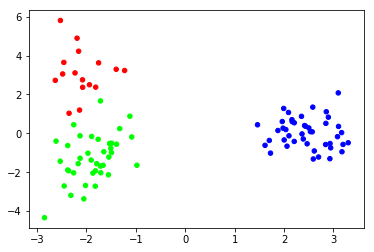

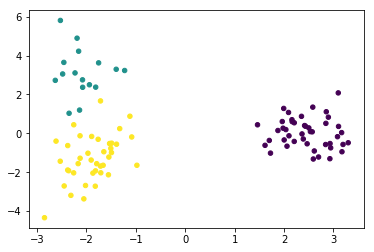

In [86]:
data_to_cluster = annotators_tpca.copy() #annotators_pca
std = StandardScaler()
data_to_cluster = std.fit_transform(data_to_cluster)

kmeans = KMeans(n_clusters=3, random_state=0,init='k-means++',n_jobs=-1)
kmeans.fit(data_to_cluster)

#proyect
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot,s=20)
plt.show()
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= kmeans.labels_, s=20)
plt.show()

### Red Base (real)

In [12]:
#PENDIENTES POR AGREGAR---revisar en base a experimentacion con datos simulados
# 1-BatchNormalization en todas las capas
# 2-Dropout

def bloque_convolucional(layer1,units,kernel_size,stride,activation,BN=False):
    """As a ssuper-layer = followed layers"""
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(layer1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(f1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = MaxPool2D(pool_size=stride)(f1)
    return f1
        
def create_network(Kl,input_dim,tipo,info_net,infoextractor_network=None,embedding_info=None):
    #add batch norma y dropa..
    try:
        len(input_dim)
    except:
        input_dim = (input_dim,)
    input_tensor = Input(shape=input_dim,name="data")
    #arquitectura
    if tipo == "CNN": #classic convolutional: deep-CCP
        start_unit,kernel_size,stride,deep,activation = infoextractor_network
        units = start_unit 
        f1 = bloque_convolucional(input_tensor,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        for i in range(deep-1): #profundidad
            units = units*2
            f1 = bloque_convolucional(f1,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        f1 = Flatten()(f1)
            
    elif tipo == "RNN": #recurrent 
        units,deep =infoextractor_network
        #embedding for text datasets
        if embedding_info!=None:
            input_dim,output_dim =embedding_info
            emb = Embedding(input_dim,output_dim)(input_tensor)
            f1 = CuDNNGRU(units,return_sequences=True)(emb)
        else:
            f1 = CuDNNGRU(units,return_sequences=True)(input_tensor)
        for i in range(deep-1): #profundidad
            f1 = CuDNNGRU(units,return_sequences=True)(f1)
        f1 = CuDNNGRU(units,return_sequences=False)(f1) #alias to flatten in convolutional
        #f1 = GlobalMaxPool1D()(f1)
    
    ### classify with extracted features
    units,ff_deep,ff_activation =info_net
    if tipo == "FF": #classic Feed Forward
        d1 = Dense(units,activation=ff_activation)(input_tensor) #comes from input
    else:
        d1 = Dense(units,activation=ff_activation)(f1)
    for i in range(ff_deep-1): #all the deep layers
        units = units/2
        d1 = Dense(units,activation=ff_activation)(d1)
        
    output_soft = Dense(Kl,activation='softmax',name="output_soft")(d1) #softmax to probability p(z|xi)
    
    model = Model(inputs=input_tensor,outputs=output_soft)
    model.summary()
    return model

In [13]:
### Ejemplo CNN
start_units,kernel,strides,deep,activation = 32, 3, 2, 3, 'relu'
info_cnn = [start_units,kernel,strides,deep,activation] 

start_units,deep, activation = 512 , 2, 'relu' 
info = [start_units,deep,activation]  #feed forwad info
clases = 3
dimensiones_input = [50,50,3]
a = create_network(clases,dimensiones_input,"CNN",info,info_cnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [15]:
### Ejemplo RNN
start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [5,50]
a = create_network(clases,dimensiones_input,"RNN",info,info_rnn)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 5, 50)             0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 5, 128)            69120     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 5, 128)            99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
out

In [16]:
### Ejemplo RNN con embedding
input_dim,output_dim = 1000,64
info_embedding = [input_dim,output_dim]

start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [10] #largo
a = create_network(clases,dimensiones_input,"RNN",info,infoextractor_network=info_rnn,embedding_info=info_embedding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            64000     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 10, 128)           74496     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 10, 128)           99072     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
__________

<a id="sindato"></a>
### Training module  1
---
Here we implement the iteration between **E** and **M** steps of our formulation with group annotations $r_{ij}$.

In [53]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.MixtureofGroups import GroupMixtureOpt

In [ ]:
##Evaluando la convergencia:
bethas varian mucho.. xke???

si se itera mucho betas se rompen del inicial que es muy bueno..

In [127]:
M_itj = set_representation(y_obs,'onehot')
mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
mask_nan2 = M_itj.sum(axis=1) == 0

mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
M_itj[mask_nan] = 1
M_itj_norm = M_itj/np.sum(M_itj,axis=1)[:,None,:]
M_itj_norm = M_itj_norm.astype(DTYPE_OP)
        
alphas_init = np.tensordot(M_itj_norm,groups_annot, axes=[[1],[0]]) 
alphas_init[mask_nan2] = 1/alphas_init.shape[-1]
alphas_init

array([[[0.25      , 0.125     , 0.625     ],
        [0.33333334, 0.33333334, 0.33333334],
        [0.        , 0.6666667 , 0.33333334]],

       [[0.33333334, 0.33333334, 0.33333334],
        [0.        , 1.        , 0.        ],
        [0.        , 0.5       , 0.5       ]],

       [[0.        , 0.        , 1.        ],
        [1.        , 0.        , 0.        ],
        [0.125     , 0.75      , 0.125     ]],

       ...,

       [[0.        , 0.        , 1.        ],
        [0.33333334, 0.33333334, 0.33333334],
        [0.2       , 0.4       , 0.4       ]],

       [[0.33333334, 0.5       , 0.16666667],
        [0.33333334, 0.33333334, 0.33333334],
        [0.        , 0.        , 1.        ]],

       [[0.        , 0.16666667, 0.8333334 ],
        [0.33333334, 0.33333334, 0.33333334],
        [0.        , 0.6666667 , 0.33333334]]], dtype=float32)

In [98]:
alphas_clusterized1_tpca
alphas_clusterized1_tpca[mask_nan2] = 1/alphas_clusterized1_tpca.shape[-1]
alphas_clusterized1_tpca

array([[[6.2500000e-01, 2.5000000e-01, 1.2500000e-01],
        [3.3333334e-01, 3.3333334e-01, 3.3333334e-01],
        [3.3333334e-01, 2.9763370e-20, 6.6666669e-01]],

       [[3.3333334e-01, 3.3333334e-01, 3.3333334e-01],
        [1.0625597e-17, 2.0232800e-17, 1.0000000e+00],
        [5.0000000e-01, 8.2398547e-13, 5.0000000e-01]],

       [[1.0000000e+00, 7.4263213e-41, 5.3605718e-24],
        [1.7800154e-15, 1.0000000e+00, 2.5712021e-16],
        [1.2500000e-01, 1.2500000e-01, 7.5000000e-01]],

       ...,

       [[1.0000000e+00, 7.2332247e-29, 1.0483881e-30],
        [3.3333334e-01, 3.3333334e-01, 3.3333334e-01],
        [4.0000001e-01, 2.0000000e-01, 4.0000001e-01]],

       [[1.6666667e-01, 3.3333334e-01, 5.0000000e-01],
        [3.3333334e-01, 3.3333334e-01, 3.3333334e-01],
        [1.0000000e+00, 1.5078024e-28, 1.4943897e-23]],

       [[8.3333331e-01, 1.1461139e-27, 1.6666667e-01],
        [3.3333334e-01, 3.3333334e-01, 3.3333334e-01],
        [3.3333334e-01, 2.0038714e-23, 6.6

In [129]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5,dtype_op=DTYPE_OP) 
#gMixture.define_model("keras_shallow")
gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
#gMixture.define_model("default cnn")
gMixture.lambda_random=False

gMixture.set_alpha(alphas_clusterized1)

gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                           ,relative=True)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.32 sec)	logL: -22166.881	F1: 0.5263
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21465.431	Tol1: 0.03164	Tol2: 0.21594	Tol3: 0.01925	F1: 0.5181
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20971.511	Tol1: 0.02301	Tol2: 0.16775	Tol3: 0.00483	F1: 0.5092
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20618.738	Tol1: 0.01682	Tol2: 0.14345	Tol3: 0.00391	F1: 0.5031
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20359.012	Tol1: 0.01260	Tol2: 0.12432	Tol3: 0.00290	F1: 0.4953
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20186.866	Tol1: 0.00846	Tol2: 0.10515	Tol3: 0.00175	F1: 0.4880
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20064.262	

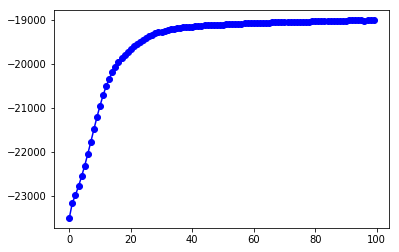

In [118]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

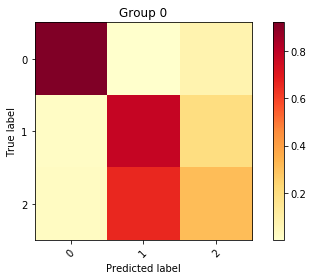

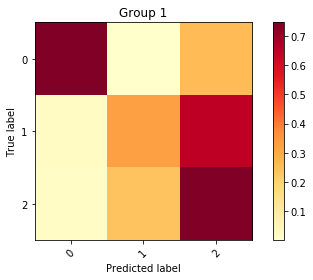

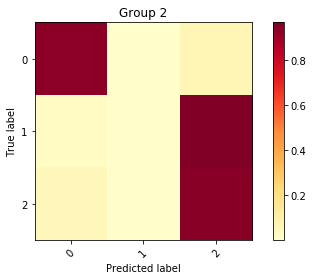

Inertia: 0.12972855133314928
A result
 +----+----------+----------+-----------+-------------+-----------+--------------------+
|    |   Groups |     Prob |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |
|----+----------+----------+-----------+-------------+-----------+--------------------|
|  0 |        0 | 0.159403 |  0.541922 |    0.670603 |  0.49859  |           0.786078 |
|  1 |        1 | 0.388429 |  0.643429 |    0.605177 |  0.569633 |           0.750507 |
|  2 |        2 | 0.452168 |  0.21066  |    0.629425 |  1.69619  |           0.656452 |
+----+----------+----------+-----------+-------------+-----------+--------------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |    0.40293 |      0.40293 |
+----+--------+------------+--------------+


In [130]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

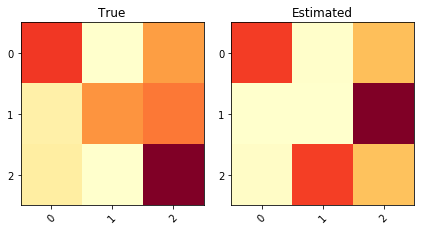

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


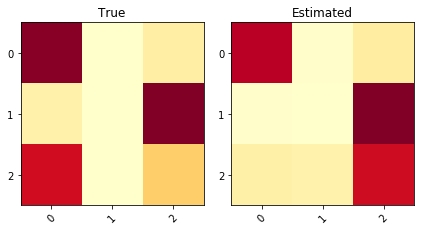

KL divergence: 0.4216	Pearson Correlation between diagonals: 0.7634


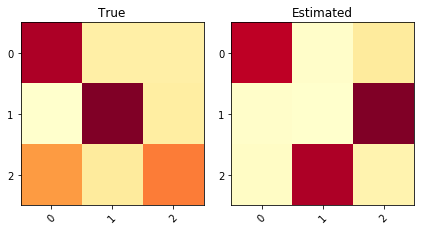

KL divergence: 2.1902	Pearson Correlation between diagonals: 0.2407


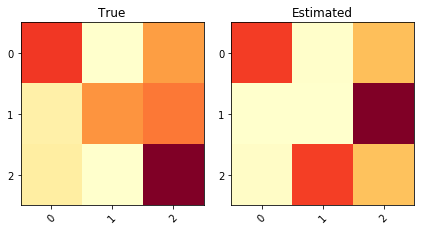

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


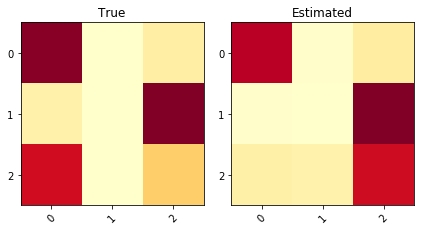

KL divergence: 0.4216	Pearson Correlation between diagonals: 0.7634


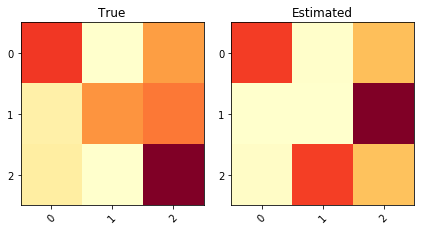

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


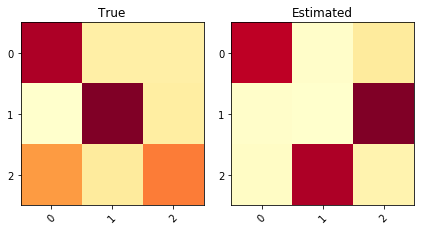

KL divergence: 2.1902	Pearson Correlation between diagonals: 0.2407


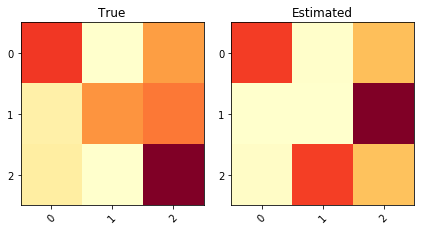

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


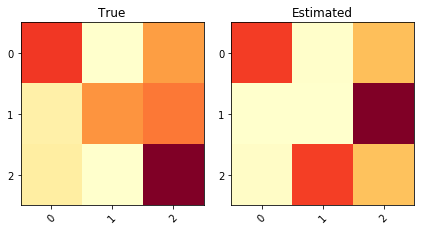

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


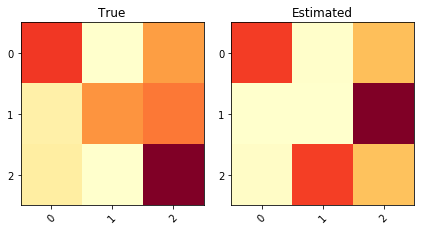

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


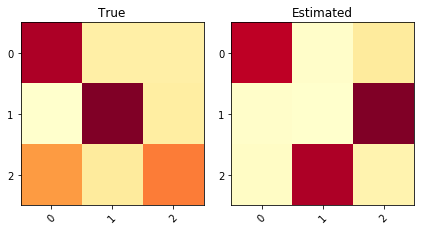

KL divergence: 2.1902	Pearson Correlation between diagonals: 0.2407


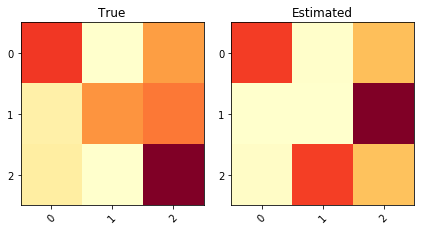

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


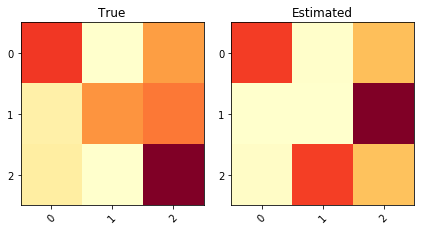

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


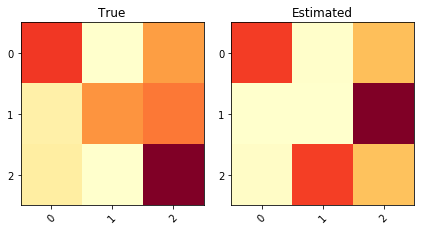

KL divergence: 1.1460	Pearson Correlation between diagonals: 0.3651


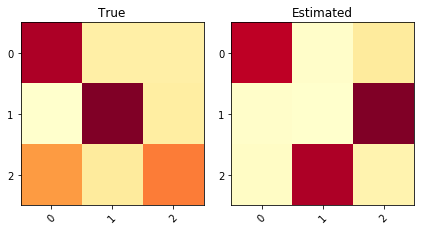

KL divergence: 2.1902	Pearson Correlation between diagonals: 0.2407
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |   0.349206 |     0.349206 |      1.21229 |              0.432085 |       0.104622 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+


In [133]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

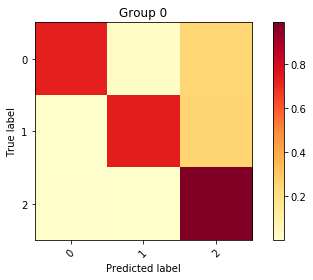

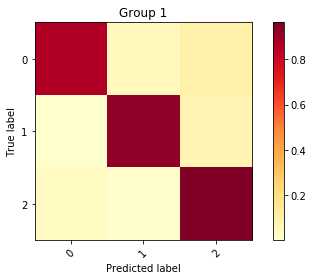

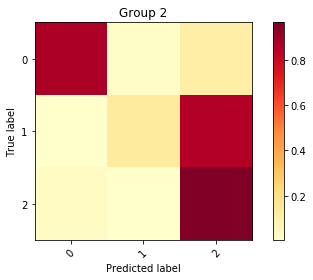

Inertia: 0.07241260788093011
A result
 +----+----------+-----------+-------------+-----------+--------------------+
|    |   Groups |   Entropy |   Diag Mean |   KL to I |   I similar % (JS) |
|----+----------+-----------+-------------+-----------+--------------------|
|  0 |        0 |  0.438136 |    0.817046 | 0.212362  |           0.898482 |
|  1 |        1 |  0.310973 |    0.917574 | 0.0870425 |           0.957159 |
|  2 |        2 |  0.332101 |    0.658779 | 0.726325  |           0.738257 |
+----+----------+-----------+-------------+-----------+--------------------+
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.886447 |     0.886447 |
+----+--------+------------+--------------+


In [109]:
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

In [106]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5,dtype_op=DTYPE_OP) 
#gMixture.define_model("default cnn")
gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
logL_hists,i = gMixture.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.008445 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.03 sec)	logL: -23696.609	F1: 0.4583
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23223.120	Tol1: 0.01998	Tol2: 0.20717	Tol3: 0.03362	F1: 0.4648
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22878.412	Tol1: 0.01484	Tol2: 0.13867	Tol3: 0.00513	F1: 0.3968
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22514.547	Tol1: 0.01590	Tol2: 0.11352	Tol3: 0.00015	F1: 0.3858
Iter 5/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -22126.303	Tol1: 0.01724	Tol2: 0.10083	Tol3: 0.00115	F1: 0.3862
Iter 6/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -21728.080	Tol1: 0.01800	Tol2: 0.09836	Tol3: 0.00177	F1: 0.3875
Iter 7/50
M step: done,

M step: done,  E step: done //  (in 0.30 sec)	logL: -20384.294	Tol1: 0.01110	Tol2: 0.07222	Tol3: 0.00349	F1: 0.8152
Iter 13/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -20176.021	Tol1: 0.01022	Tol2: 0.06192	Tol3: 0.00391	F1: 0.8238
Iter 14/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19991.599	Tol1: 0.00914	Tol2: 0.05431	Tol3: 0.00407	F1: 0.8323
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19832.730	Tol1: 0.00795	Tol2: 0.05205	Tol3: 0.00406	F1: 0.8421
Iter 16/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19697.021	Tol1: 0.00684	Tol2: 0.05026	Tol3: 0.00330	F1: 0.8502
Iter 17/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -19587.722	Tol1: 0.00555	Tol2: 0.04625	Tol3: 0.00354	F1: 0.8523
Iter 18/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19496.105	Tol1: 0.00468	Tol2: 0.04500	Tol3: 0.00214	F1: 0.8543
Iter 19/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19422.219	Tol1: 0.00379	Tol2: 0.04355	Tol3: 0.00143	F1: 0.

M step: done,  E step: done //  (in 0.49 sec)	logL: -19079.178	Tol1: 0.00038	Tol2: 0.03262	Tol3: 0.00105	F1: 0.6553
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19074.208	Tol1: 0.00026	Tol2: 0.03216	Tol3: 0.00143	F1: 0.6589
Iter 39/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -19069.807	Tol1: 0.00023	Tol2: 0.02989	Tol3: 0.00125	F1: 0.6536
Iter 40/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19064.072	Tol1: 0.00030	Tol2: 0.02626	Tol3: 0.00146	F1: 0.6569
Iter 41/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19059.046	Tol1: 0.00026	Tol2: 0.02581	Tol3: 0.00127	F1: 0.6622
Iter 42/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19054.716	Tol1: 0.00023	Tol2: 0.02483	Tol3: 0.00129	F1: 0.6447
Iter 43/50
M step: done,  E step: done //  (in 0.44 sec)	logL: -19049.386	Tol1: 0.00028	Tol2: 0.02315	Tol3: 0.00187	F1: 0.6516
Iter 44/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -19045.314	Tol1: 0.00021	Tol2: 0.02385	Tol3: 0.00152	F1: 0.

M step: done,  E step: done //  (in 0.23 sec)	logL: -19514.048	Tol1: 0.00051	Tol2: 0.02156	Tol3: 0.00125	F1: 0.3508
Iter 32/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19504.548	Tol1: 0.00049	Tol2: 0.02300	Tol3: 0.00157	F1: 0.3512
Iter 33/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -19494.652	Tol1: 0.00051	Tol2: 0.02213	Tol3: 0.00126	F1: 0.3512
Iter 34/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19481.764	Tol1: 0.00066	Tol2: 0.02288	Tol3: 0.00157	F1: 0.3512
Iter 35/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -19469.105	Tol1: 0.00065	Tol2: 0.02274	Tol3: 0.00160	F1: 0.3508
Iter 36/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -19455.023	Tol1: 0.00072	Tol2: 0.02396	Tol3: 0.00205	F1: 0.3508
Iter 37/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -19439.659	Tol1: 0.00079	Tol2: 0.02348	Tol3: 0.00207	F1: 0.3508
Iter 38/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19422.145	Tol1: 0.00090	Tol2: 0.02189	Tol3: 0.00170	F1: 0.

M step: done,  E step: done //  (in 0.22 sec)	logL: -19409.672	Tol1: 0.00176	Tol2: 0.03251	Tol3: 0.00253	F1: 0.6475
Iter 25/50
M step: done,  E step: done //  (in 0.43 sec)	logL: -19384.601	Tol1: 0.00129	Tol2: 0.03332	Tol3: 0.00240	F1: 0.6512
Iter 26/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19362.505	Tol1: 0.00114	Tol2: 0.03413	Tol3: 0.00270	F1: 0.6553
Iter 27/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -19340.140	Tol1: 0.00116	Tol2: 0.03288	Tol3: 0.00295	F1: 0.6585
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19321.737	Tol1: 0.00095	Tol2: 0.03217	Tol3: 0.00272	F1: 0.6667
Iter 29/50
M step: done,  E step: done //  (in 0.49 sec)	logL: -19299.918	Tol1: 0.00113	Tol2: 0.03027	Tol3: 0.00222	F1: 0.6687
Iter 30/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19278.746	Tol1: 0.00110	Tol2: 0.02981	Tol3: 0.00212	F1: 0.6646
Iter 31/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19265.898	Tol1: 0.00067	Tol2: 0.03072	Tol3: 0.00191	F1: 0.

M step: done,  E step: done //  (in 0.17 sec)	logL: -23089.067	Tol1: 0.00831	Tol2: 0.06830	Tol3: 0.00229	F1: 0.3814
Iter 6/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -22875.937	Tol1: 0.00923	Tol2: 0.06962	Tol3: 0.00267	F1: 0.3948
Iter 7/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22633.620	Tol1: 0.01059	Tol2: 0.07385	Tol3: 0.00280	F1: 0.4066
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22367.372	Tol1: 0.01176	Tol2: 0.08036	Tol3: 0.00283	F1: 0.4131
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22087.164	Tol1: 0.01253	Tol2: 0.08613	Tol3: 0.00259	F1: 0.4115
Iter 10/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -21796.824	Tol1: 0.01315	Tol2: 0.08970	Tol3: 0.00234	F1: 0.4115
Iter 11/50
M step: done,  E step: done //  (in 0.39 sec)	logL: -21505.974	Tol1: 0.01334	Tol2: 0.09122	Tol3: 0.00169	F1: 0.4229
Iter 12/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21228.002	Tol1: 0.01293	Tol2: 0.09041	Tol3: 0.00097	F1: 0.4737

M step: done,  E step: done //  (in 0.34 sec)	logL: -19522.214	Tol1: 0.00084	Tol2: 0.03481	Tol3: 0.00093	F1: 0.3582
Iter 30/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -19508.417	Tol1: 0.00071	Tol2: 0.03565	Tol3: 0.00118	F1: 0.3573
Iter 31/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19496.558	Tol1: 0.00061	Tol2: 0.03498	Tol3: 0.00129	F1: 0.3582
Iter 32/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -19477.549	Tol1: 0.00098	Tol2: 0.03295	Tol3: 0.00113	F1: 0.3573
Iter 33/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -19464.043	Tol1: 0.00069	Tol2: 0.03513	Tol3: 0.00146	F1: 0.3569
Iter 34/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -19443.410	Tol1: 0.00106	Tol2: 0.03541	Tol3: 0.00179	F1: 0.3582
Iter 35/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19429.950	Tol1: 0.00069	Tol2: 0.03439	Tol3: 0.00056	F1: 0.3573
Iter 36/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -19414.941	Tol1: 0.00077	Tol2: 0.03435	Tol3: 0.00136	F1: 0.

M step: done,  E step: done //  (in 0.20 sec)	logL: -19126.261	Tol1: 0.00054	Tol2: 0.02409	Tol3: 0.00238	F1: 0.6443
Iter 28/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19114.693	Tol1: 0.00060	Tol2: 0.02271	Tol3: 0.00246	F1: 0.6447
Iter 29/50
M step: done,  E step: done //  (in 0.43 sec)	logL: -19105.868	Tol1: 0.00046	Tol2: 0.02045	Tol3: 0.00225	F1: 0.6459
Iter 30/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -19095.466	Tol1: 0.00054	Tol2: 0.01952	Tol3: 0.00241	F1: 0.6455
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.99 sec)	logL: -23384.077	F1: 0.3504
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22722.230	Tol1: 0.02830	Tol2: 0.25437	Tol3: 0.02812	F1: 0.3541
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22226.103	Tol1: 0.02183	Tol2: 0.18167	

M step: done,  E step: done //  (in 0.16 sec)	logL: -19207.335	Tol1: 0.00072	Tol2: 0.02491	Tol3: 0.00186	F1: 0.7570
Iter 33/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19196.797	Tol1: 0.00055	Tol2: 0.02462	Tol3: 0.00127	F1: 0.7558
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19185.709	Tol1: 0.00058	Tol2: 0.02419	Tol3: 0.00132	F1: 0.7521
Iter 35/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19172.883	Tol1: 0.00067	Tol2: 0.02384	Tol3: 0.00097	F1: 0.7631
Iter 36/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19164.194	Tol1: 0.00045	Tol2: 0.02309	Tol3: 0.00111	F1: 0.7611
Iter 37/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19154.413	Tol1: 0.00051	Tol2: 0.02252	Tol3: 0.00160	F1: 0.7546
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19147.294	Tol1: 0.00037	Tol2: 0.02224	Tol3: 0.00119	F1: 0.7562
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19137.774	Tol1: 0.00050	Tol2: 0.02128	Tol3: 0.00162	F1: 0.

M step: done,  E step: done //  (in 0.15 sec)	logL: -19335.370	Tol1: 0.00062	Tol2: 0.02583	Tol3: 0.00120	F1: 0.3691
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19323.095	Tol1: 0.00063	Tol2: 0.02350	Tol3: 0.00158	F1: 0.3683
Iter 33/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19310.436	Tol1: 0.00066	Tol2: 0.02002	Tol3: 0.00114	F1: 0.3659
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19294.951	Tol1: 0.00080	Tol2: 0.01900	Tol3: 0.00112	F1: 0.3639
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.12 sec)	logL: -22745.466	F1: 0.3366
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22118.463	Tol1: 0.02757	Tol2: 0.23553	Tol3: 0.00571	F1: 0.3439
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21578.243	Tol1: 0.02442	Tol2: 0.17656	

M step: done,  E step: done //  (in 0.17 sec)	logL: -19599.961	Tol1: 0.00140	Tol2: 0.02527	Tol3: 0.00197	F1: 0.5458
Iter 32/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19577.978	Tol1: 0.00112	Tol2: 0.02380	Tol3: 0.00186	F1: 0.5584
Iter 33/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19555.257	Tol1: 0.00116	Tol2: 0.02354	Tol3: 0.00169	F1: 0.5739
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19532.424	Tol1: 0.00117	Tol2: 0.02460	Tol3: 0.00180	F1: 0.5804
Iter 35/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19510.402	Tol1: 0.00113	Tol2: 0.02545	Tol3: 0.00187	F1: 0.5934
Iter 36/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19490.042	Tol1: 0.00104	Tol2: 0.02492	Tol3: 0.00165	F1: 0.5999
Iter 37/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19474.857	Tol1: 0.00078	Tol2: 0.02666	Tol3: 0.00154	F1: 0.5987
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19453.954	Tol1: 0.00107	Tol2: 0.02884	Tol3: 0.00229	F1: 0.

Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.07 sec)	logL: -23178.724	F1: 0.7639
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22649.777	Tol1: 0.02282	Tol2: 0.19839	Tol3: 0.04542	F1: 0.8030
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22327.230	Tol1: 0.01424	Tol2: 0.14238	Tol3: 0.00682	F1: 0.8303
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22022.386	Tol1: 0.01365	Tol2: 0.12309	Tol3: 0.00170	F1: 0.8575
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21725.591	Tol1: 0.01348	Tol2: 0.11587	Tol3: 0.00111	F1: 0.8844
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21428.701	Tol1: 0.01367	Tol2: 0.11279	Tol3: 0.00077	F1: 0.9003
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21138.984	Tol1: 0.01352	Tol2: 0.11271	Tol3: 0.00095	F1: 0.9064
Iter 8/50


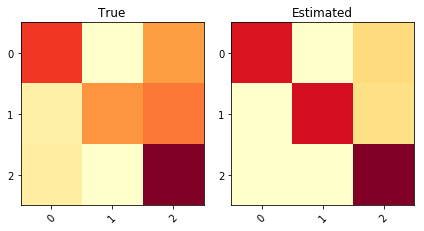

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


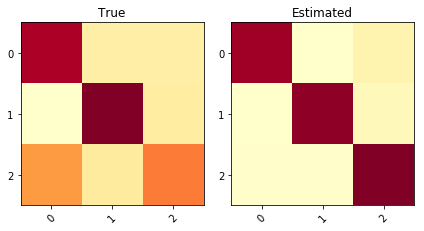

KL divergence: 0.4571	Pearson Correlation between diagonals: -0.7542


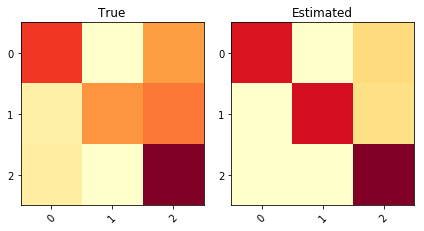

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


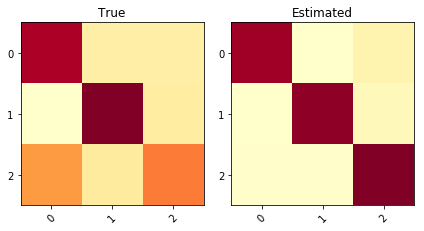

KL divergence: 0.4571	Pearson Correlation between diagonals: -0.7542


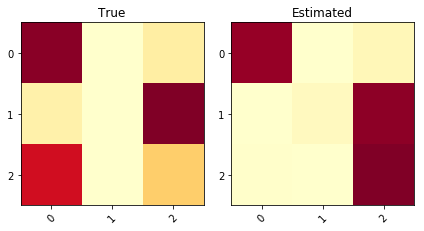

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


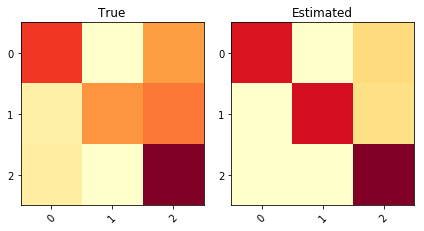

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


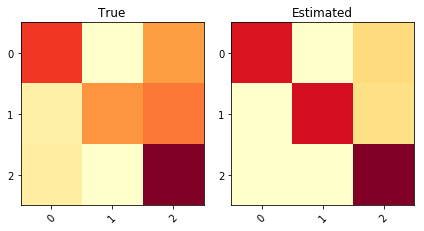

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


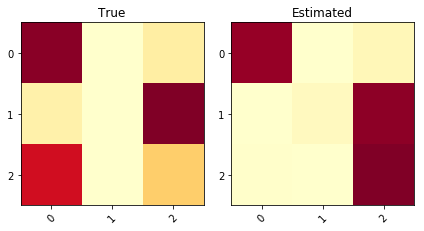

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


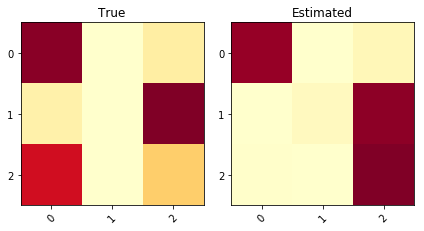

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


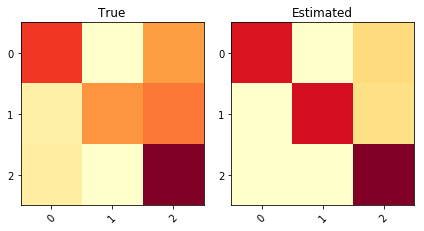

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


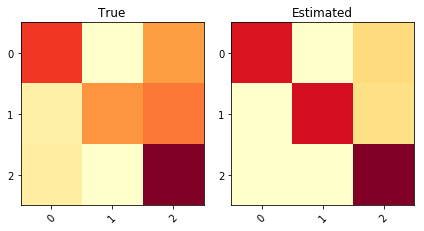

KL divergence: 0.2437	Pearson Correlation between diagonals: 0.8720


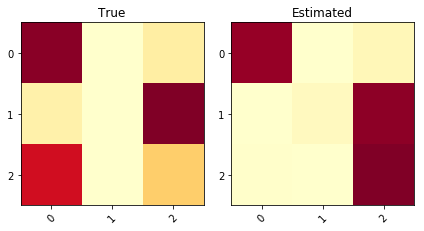

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


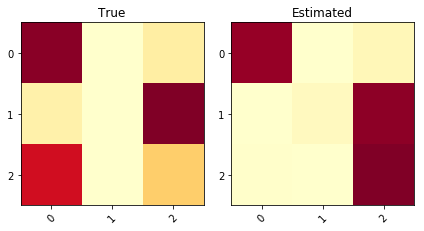

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


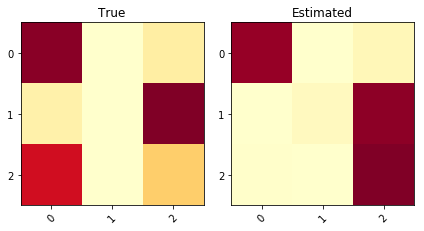

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912


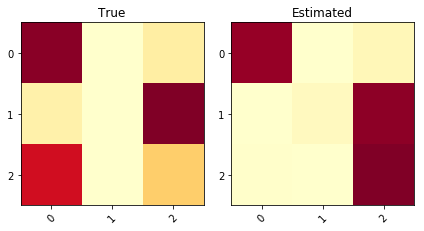

KL divergence: 1.0571	Pearson Correlation between diagonals: 0.6912
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |     0.6744 |       0.6744 |     0.635707 |              0.532278 |       0.186749 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
Test
A result
 +----+--------+------------+--------------+
|    |        |   Accuracy |   F1 (micro) |
|----+--------+------------+--------------|
|  0 | Global |   0.675214 |     0.675214 |
+----+--------+------------+--------------+


In [105]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred) #PCA

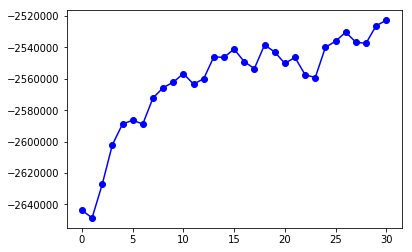

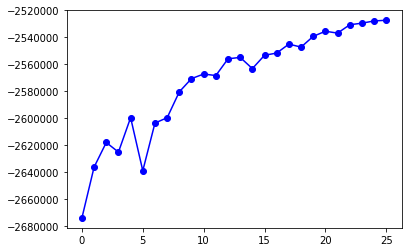

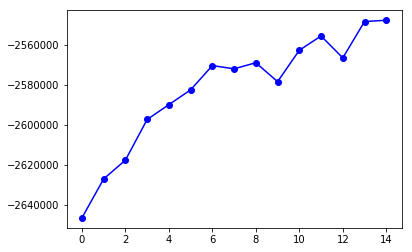

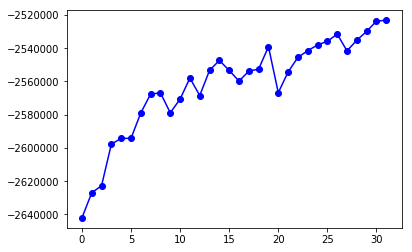

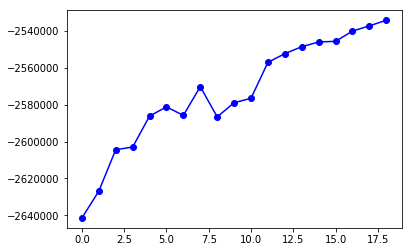

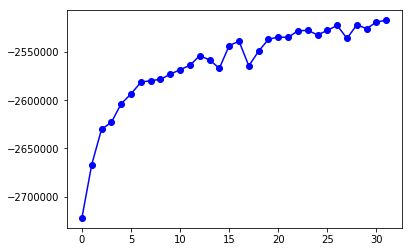

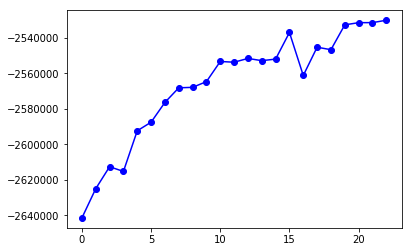

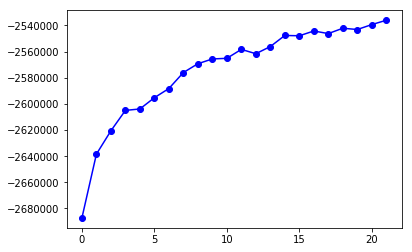

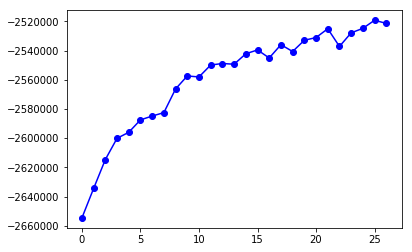

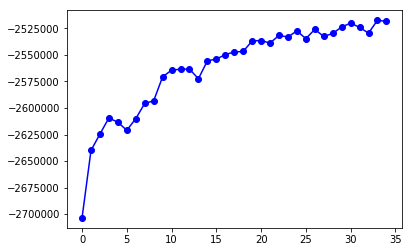

Calculated with 46 anotations
Calculated with 45 anotations
Calculated with 35 anotations
Calculated with 43 anotations
Calculated with 43 anotations
Calculated with 42 anotations
Calculated with 47 anotations
Calculated with 47 anotations
Calculated with 42 anotations
Calculated with 39 anotations
Calculated with 41 anotations
Calculated with 33 anotations
Calculated with 41 anotations
Calculated with 56 anotations
Calculated with 43 anotations
Calculated with 38 anotations
Calculated with 45 anotations
Calculated with 41 anotations
Calculated with 35 anotations
Calculated with 37 anotations
Calculated with 39 anotations
Calculated with 34 anotations
Calculated with 42 anotations
Calculated with 46 anotations
Calculated with 45 anotations
Calculated with 42 anotations
Calculated with 49 anotations
Calculated with 44 anotations
Calculated with 44 anotations
Calculated with 42 anotations
Calculated with 47 anotations
Calculated with 50 anotations
Calculated with 36 anotations
Calculated

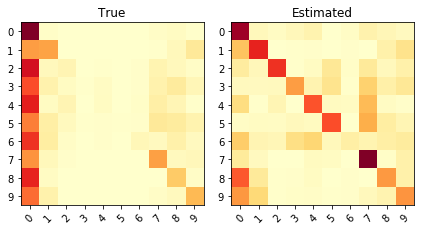

KL divergence: 0.7632	Pearson Correlation between diagonals: 0.6004


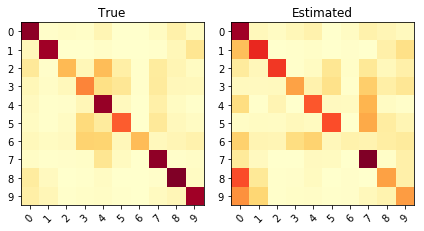

KL divergence: 0.3348	Pearson Correlation between diagonals: 0.5008


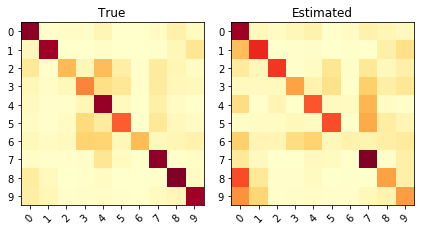

KL divergence: 0.3334	Pearson Correlation between diagonals: 0.5016


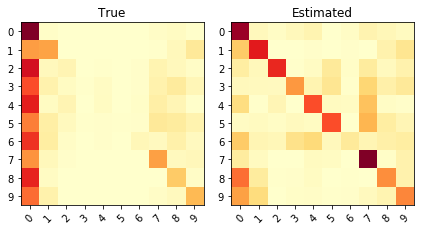

KL divergence: 0.7558	Pearson Correlation between diagonals: 0.6138


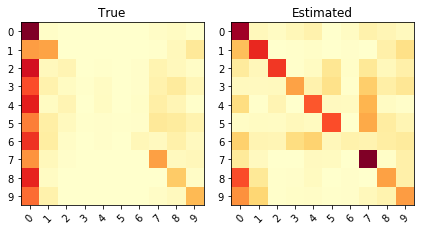

KL divergence: 0.7706	Pearson Correlation between diagonals: 0.5911


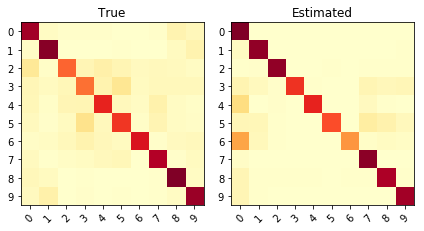

KL divergence: 0.5478	Pearson Correlation between diagonals: 0.4866


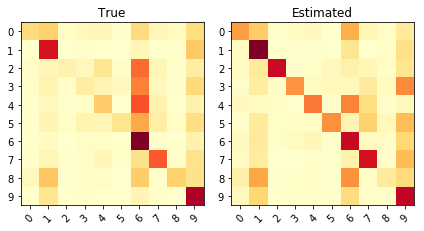

KL divergence: 0.3609	Pearson Correlation between diagonals: 0.6421


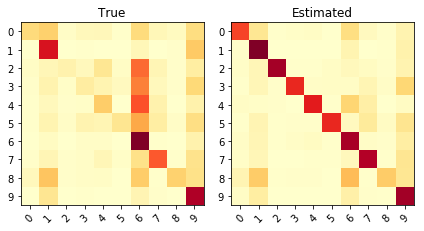

KL divergence: 0.5268	Pearson Correlation between diagonals: 0.5288


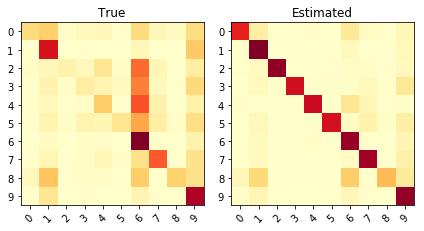

KL divergence: 0.7092	Pearson Correlation between diagonals: 0.4583


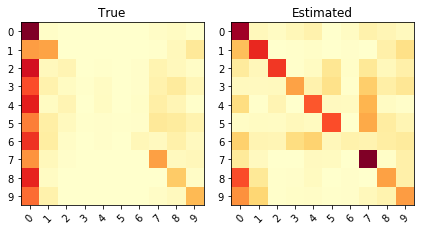

KL divergence: 0.7706	Pearson Correlation between diagonals: 0.5911


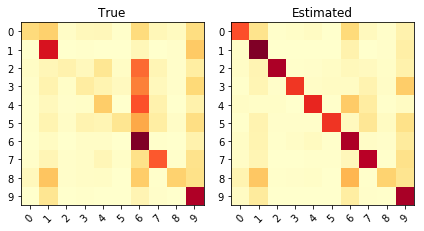

KL divergence: 0.4846	Pearson Correlation between diagonals: 0.5504


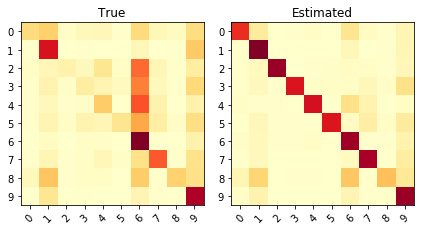

KL divergence: 0.6356	Pearson Correlation between diagonals: 0.4831


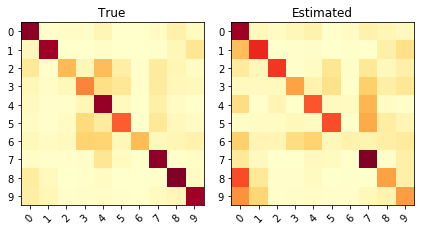

KL divergence: 0.3336	Pearson Correlation between diagonals: 0.5014


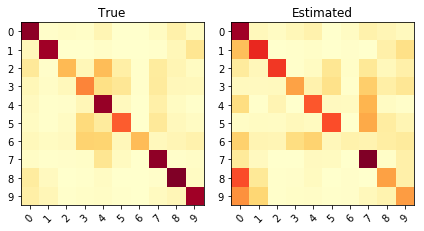

KL divergence: 0.3348	Pearson Correlation between diagonals: 0.5008


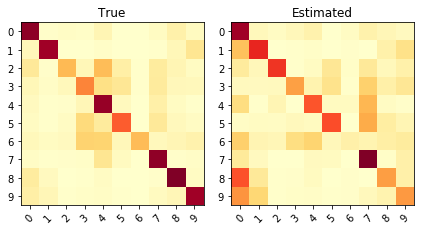

KL divergence: 0.3282	Pearson Correlation between diagonals: 0.5034
A result
 +----+---------+------------+--------------+
|    |   Group |   Accuracy |   F1 (micro) |
|----+---------+------------+--------------|
|  0 |       0 |    0.39726 |      0.39726 |
|  1 |       1 |    0.66312 |      0.66312 |
|  2 |       2 |    0.45264 |      0.45264 |
|  3 |       3 |    0.652   |      0.652   |
+----+---------+------------+--------------+
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.70168 |      0.70168 |     0.565168 |              0.530104 |       0.173584 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
Test
A result
 +----+--------+------------+---------

In [49]:
for value in logL_hists:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...


from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

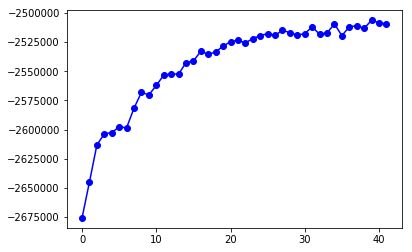

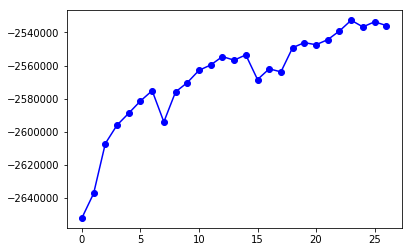

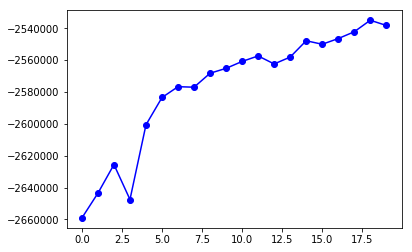

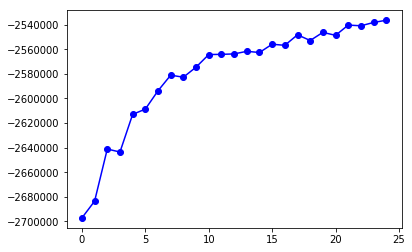

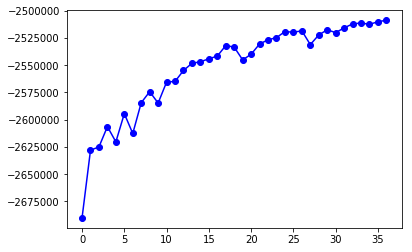

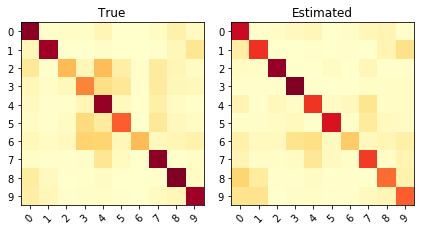

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


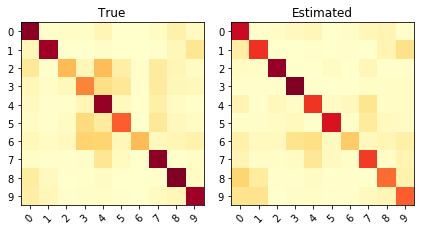

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


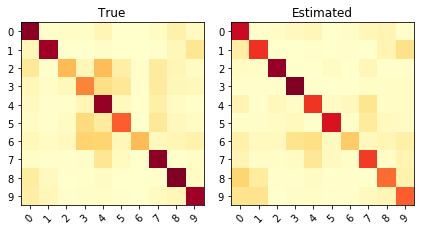

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


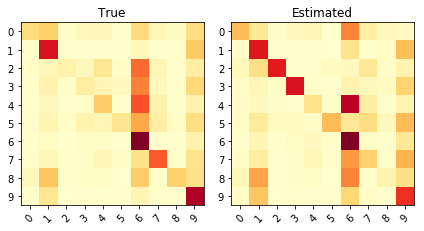

KL divergence: 0.4043	Pearson Correlation between diagonals: 0.4524


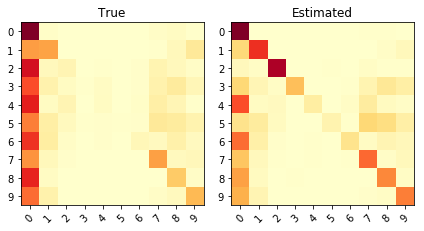

KL divergence: 0.3755	Pearson Correlation between diagonals: 0.7225


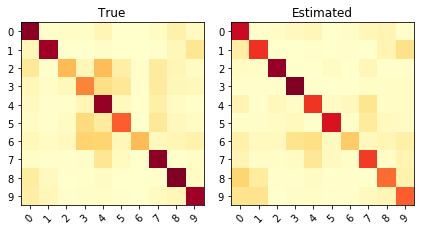

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


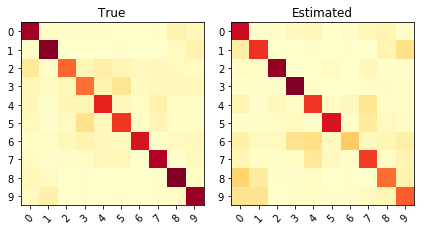

KL divergence: 0.3269	Pearson Correlation between diagonals: -0.5288


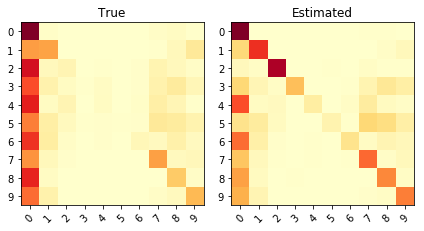

KL divergence: 0.3755	Pearson Correlation between diagonals: 0.7225


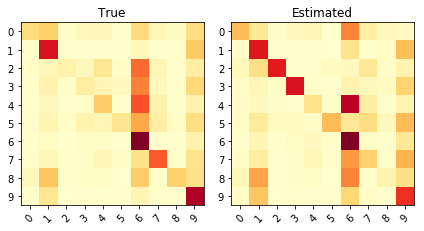

KL divergence: 0.4043	Pearson Correlation between diagonals: 0.4524


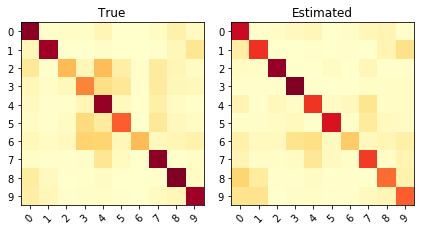

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


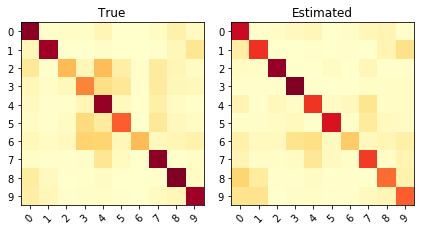

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


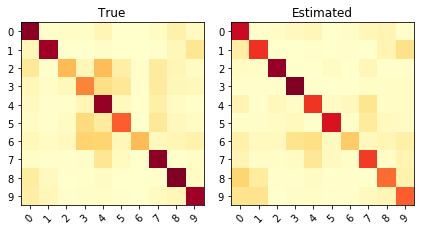

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097


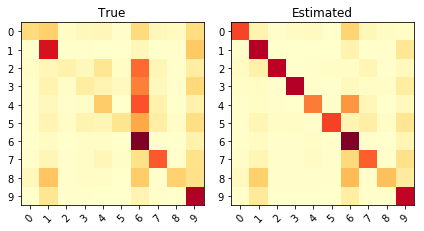

KL divergence: 0.5180	Pearson Correlation between diagonals: 0.4246


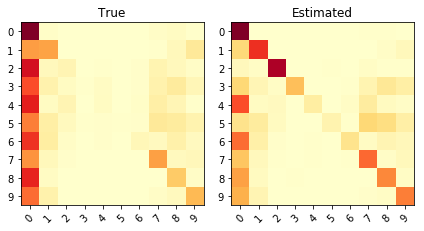

KL divergence: 0.3755	Pearson Correlation between diagonals: 0.7225


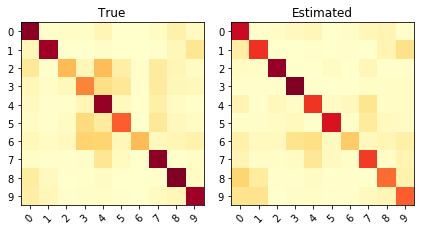

KL divergence: 0.3834	Pearson Correlation between diagonals: -0.1097
A result
 +----+---------+------------+--------------+
|    |   Group |   Accuracy |   F1 (micro) |
|----+---------+------------+--------------|
|  0 |       0 |    0.6938  |      0.6938  |
|  1 |       1 |    0.81774 |      0.81774 |
|  2 |       2 |    0.47102 |      0.47102 |
|  3 |       3 |    0.29708 |      0.29708 |
+----+---------+------------+--------------+
A result
 +----+--------+------------+--------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------+--------------+-----------------------+----------------|
|  0 | Global |    0.73642 |      0.73642 |     0.424449 |              0.299343 |       0.123497 |
+----+--------+------------+--------------+--------------+-----------------------+----------------+
Test
A result
 +----+--------+------------+--------

In [35]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()

from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

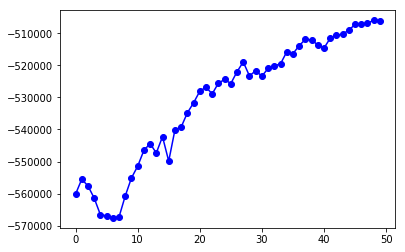

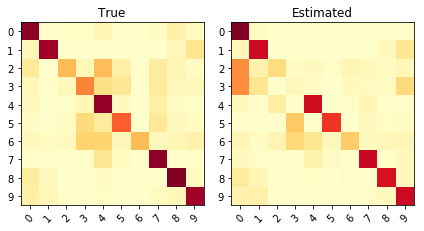

KL divergence: 0.3546	Pearson Correlation between diagonals: 0.8887


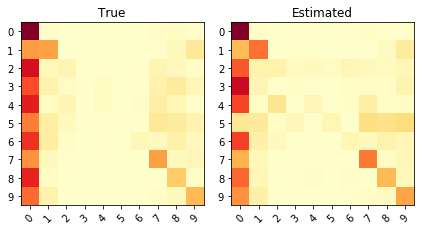

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


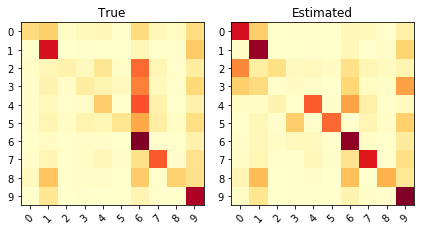

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


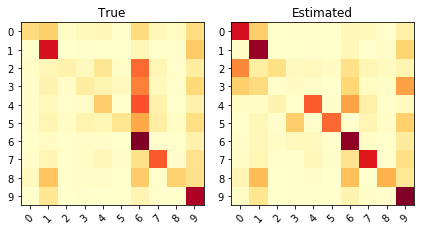

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


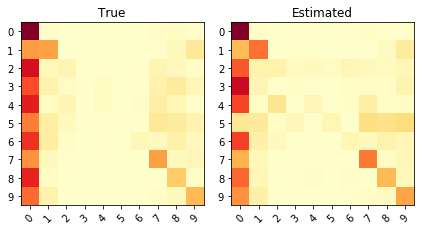

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


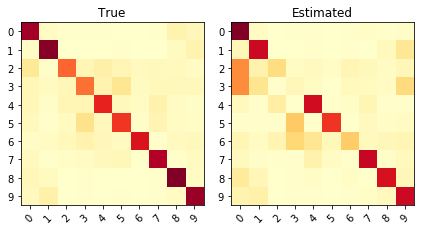

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.7942


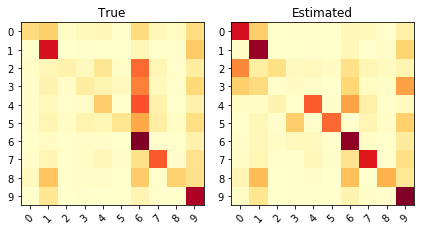

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


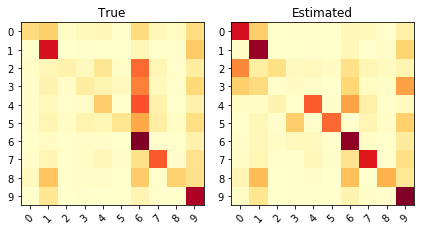

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


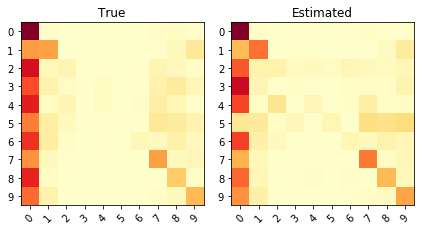

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


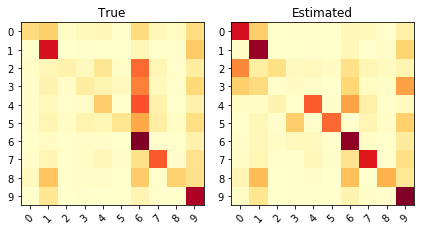

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


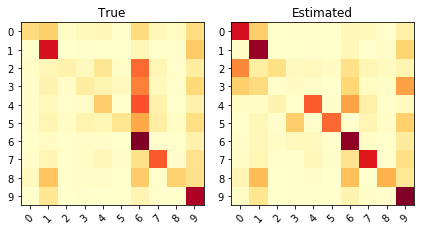

KL divergence: 0.3591	Pearson Correlation between diagonals: 0.8298


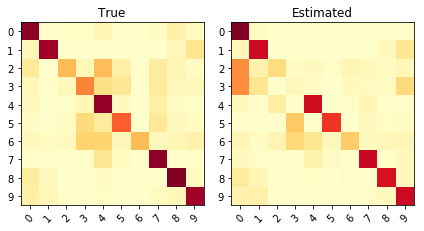

KL divergence: 0.3546	Pearson Correlation between diagonals: 0.8887


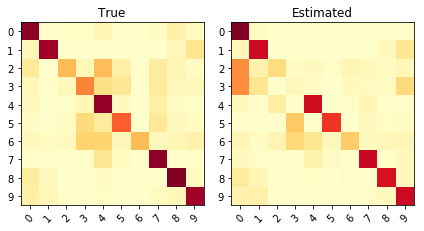

KL divergence: 0.3546	Pearson Correlation between diagonals: 0.8887


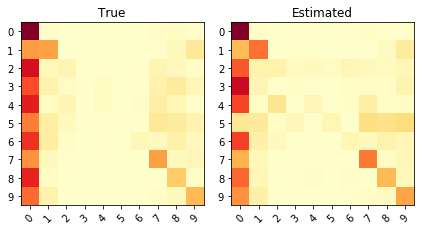

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908


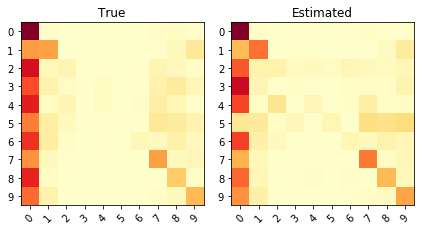

KL divergence: 0.1206	Pearson Correlation between diagonals: 0.9908
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |     0.5755 |             0.5755 |
|  1 |       1 |     0.2787 |             0.2787 |
|  2 |       2 |     0.7628 |             0.7628 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |     0.6977 |             0.6977 |     0.299974 |              0.883754 |       0.158787 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
Test
A result
 +----+----

In [16]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [40]:
%%time
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.41 sec)	logL: -85843.819	F1: 0.7442
Iter 2/25
M step: done	E step: done, (in 2.47 sec)	logL: -83639.140	Tol: 0.02568	F1: 0.7286
Iter 3/25
M step: done	E step: done, (in 2.33 sec)	logL: -82040.527	Tol: 0.01911	F1: 0.7178
Iter 4/25
M step: done	E step: done, (in 2.31 sec)	logL: -81027.269	Tol: 0.01235	F1: 0.7117
Iter 5/25
M step: done	E step: done, (in 2.37 sec)	logL: -80444.867	Tol: 0.00719	F1: 0.7142
Iter 6/25
M step: done	E step: done, (in 2.39 sec)	logL: -80116.539	Tol: 0.00408	F1: 0.7248
Iter 7/25
M step: done	E step: done, (in 2.43 sec)	logL: -79915.121	Tol: 0.00251	F1: 0.7397
Iter 8/25
M step: done	E step: done, (in 2.43 sec)	logL: -79781.112	Tol: 0.00168	F1: 0.7502
Iter 9/25
M step: done	E step: done, (in 2.42 sec)	logL: -79677

In [143]:
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=7,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',256,2)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.40107749624626565, 0.6643001499237149, 0.5331640955460885, 0.1617082682059309, 0.46440295869359777, 0.3517687543555905, 0.7898108127238789]
Alphas:  (2700, 7)
MV init:  (2700, 3)
Betas:  (7, 3, 3)
Q estimate:  (2700, 3, 7, 3)
Iter 1/25
M step: done	E step: done, (in 1.96 sec)	logL: -80827.414	
Iter 2/25
M step: done	E step: done, (in 1.88 sec)	logL: -80249.518	Tol: 0.00715	
Iter 3/25
M step: done	E step: done, (in 1.90 sec)	logL: -79907.925	Tol: 0.00426	
Iter 4/25
M step: done	E step: done, (in 1.90 sec)	logL: -79695.919	Tol: 0.00265	
Iter 5/25
M step: done	E step: done, (in 1.90 sec)	logL: -79573.557	Tol: 0.00154	
Iter 6/25
M step: done	E step: done, (in 1.92 sec)	logL: -79498.354	Tol: 0.00095	
Iter 7/25
M step: done	E step: done, (in 1.89 sec)	logL: -79452.646	Tol: 0.00057	
Iter 8/25
M step: done	E step: done, (in 1.90 sec)	logL: -79421.224	Tol: 0.00040	
Iter 9/25
M step: done	E step:

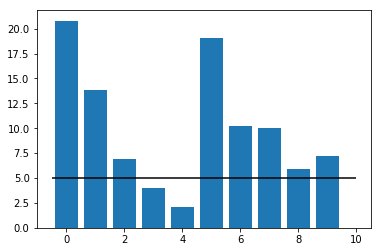

In [63]:
plt.bar(np.arange(M),gMixture.get_alpha()*100)
plt.hlines(5,-0.5,M) #treshold en Numero de anotadores x grupo--quizas no sirva...
#que pasa si hay un grupo que tiene 5 anotadores y otro que tiene 10 pero se comparte con otro que tiene 1?
#sirve para tener una idea general de cuantos anotadores x grupo hay

In [44]:
print("Stable training (global alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Stable training (global alpha)


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9403703703703704,0.9392316242866506,0.9403703703703703


In [46]:
print("Multiples runs (global alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Multiples runs (global alpha)


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.96,0.9595173521330044,0.96


In [52]:
print("Multiples runs (data alpha)")
report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Multiples runs (data alpha)


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9403703703703704,0.9396247669605527,0.9403703703703703


In [69]:
### comparar resultados con mas grupos o menos grupos
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.50 sec)	logL: -84431.118	F1: 0.8277
Iter 2/25
M step: done	E step: done, (in 2.49 sec)	logL: -82027.963	Tol: 0.02846	F1: 0.8218
Iter 3/25
M step: done	E step: done, (in 2.42 sec)	logL: -80732.001	Tol: 0.01580	F1: 0.8196
Iter 4/25
M step: done	E step: done, (in 2.41 sec)	logL: -80087.666	Tol: 0.00798	F1: 0.8191
Iter 5/25
M step: done	E step: done, (in 2.36 sec)	logL: -79755.607	Tol: 0.00415	F1: 0.8215
Iter 6/25
M step: done	E step: done, (in 2.40 sec)	logL: -79562.342	Tol: 0.00242	F1: 0.8249
Iter 7/25
M step: done	E step: done, (in 2.41 sec)	logL: -79413.819	Tol: 0.00187	F1: 0.8332
Iter 8/25
M step: done	E step: done, (in 2.39 sec)	logL: -79296.041	Tol: 0.00148	F1: 0.8391
Iter 9/25
M step: done	E step: done, (in 2.36 sec)	logL: -79187

In [68]:
#and multiples runs
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.00738633966784168, 0.033873725693389055]
Alphas:  (2,)
MV init:  (2700, 3)
Betas:  (2, 3, 3)
Q estimate:  (2700, 3, 2, 3)
Iter 1/25
M step: done	E step: done, (in 1.03 sec)	logL: -84088.130	
Iter 2/25
M step: done	E step: done, (in 1.23 sec)	logL: -82295.538	Tol: 0.02132	
Iter 3/25
M step: done	E step: done, (in 1.01 sec)	logL: -81493.772	Tol: 0.00974	
Iter 4/25
M step: done	E step: done, (in 1.05 sec)	logL: -81109.277	Tol: 0.00472	
Iter 5/25
M step: done	E step: done, (in 1.08 sec)	logL: -80929.009	Tol: 0.00222	
Iter 6/25
M step: done	E step: done, (in 1.05 sec)	logL: -80839.120	Tol: 0.00111	
Iter 7/25
M step: done	E step: done, (in 1.00 sec)	logL: -80784.744	Tol: 0.00067	
Iter 8/25
M step: done	E step: done, (in 0.98 sec)	logL: -80757.410	Tol: 0.00034	
Iter 9/25
M step: done	E step: done, (in 0.99 sec)	logL: -80739.910	Tol: 0.00022	
Finished training!
Initializing new EM...
Pre-train 

In [67]:
#si eliminamos las matrices extras? a traves de p(g|t)--aun no se implementa

gMixture.get_confusionM()
#clean

gMixture.betas = gMixture.get_confusionM() #cleaned
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

    Acccuracy       F1 score (micro)   F1 score (macro) 
------------------ ------------------ ------------------
0.8748148148148148 0.8708596576177706 0.8748148148148148


In [56]:
groups_annot_pred = np.argmax(prob_Gt,axis=1)
print(groups_annot_pred)
print(set(groups_annot_pred)) #revisar fast el numero de grupos utilizados...

[2 2 1 2 0 2 2 0 0 1 0 1 2 2 0 0 0 0 1 1 0 1 0 2 0 2 2 2 0 0 2 2 1 2 2 1 1
 1 0 2 1 2 0 0 1 0 1 0 1 0 0 2 1 2 2 0 0 1 1 2 1 0 1 2 2 0 2 0 2 0 0 2 2 0
 2 1 0 2 1 2 0 2 0 1 2 0 0 0 2 0 1 0 0 0 2 0 1 0 0 0]
{0, 1, 2}
CPU times: user 32.9 s, sys: 635 ms, total: 33.6 s
Wall time: 33 s


In [41]:
#obtain p(y^o|x,g=m)
gMixture.get_predictions_group(1,Xstd_train) #puedo medir acc con eso

array([[0.22092701, 0.66987641, 0.10919658],
       [0.18366501, 0.769683  , 0.04665199],
       [0.36506755, 0.28602405, 0.34890843],
       ...,
       [0.18930534, 0.75472514, 0.0559695 ],
       [0.33724762, 0.3600254 , 0.30272705],
       [0.44818453, 0.03039722, 0.5214183 ]])

### Posible problema: en la inicialización parta muy "fuerte", itere poco  y no deje al modelo predictivo aprender lo suficiente de los datos.

In [332]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') #how to use it is in evaluation_mrtric file

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 21.9 µs


There are 100 real and 100 predicted Conf matrices


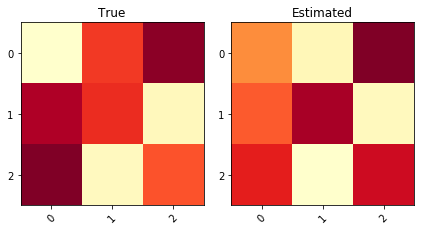

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


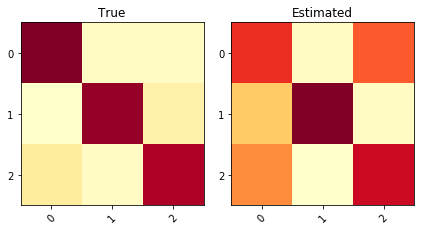

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


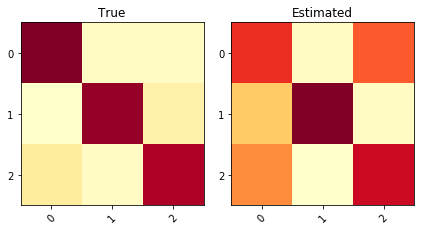

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


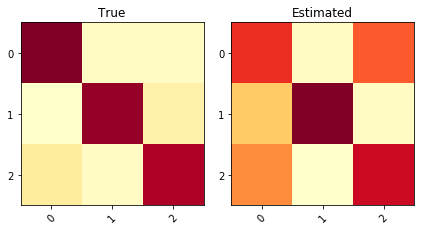

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


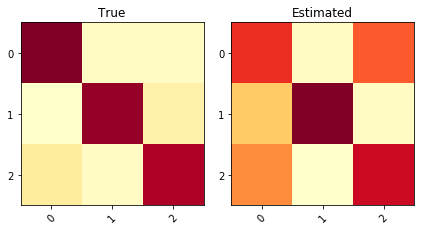

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


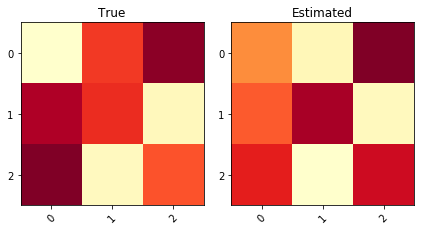

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


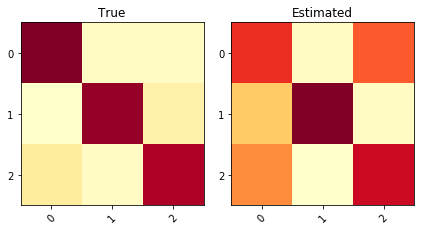

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


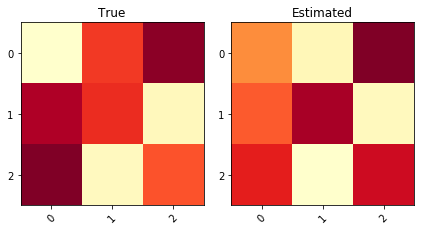

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


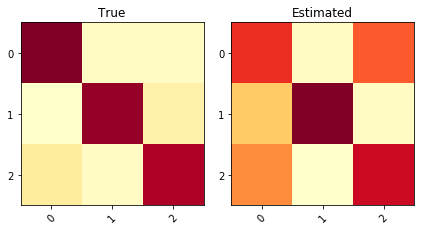

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


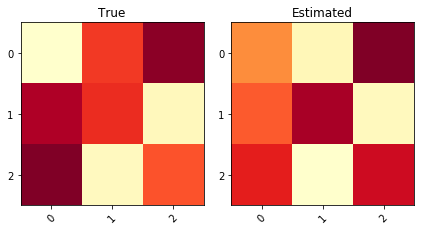

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


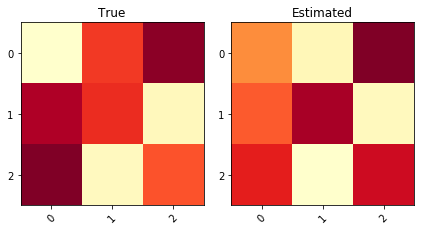

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


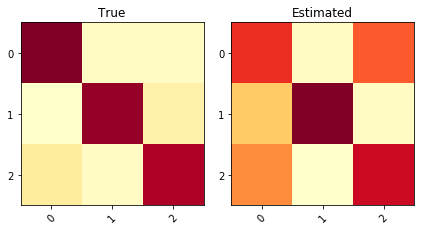

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


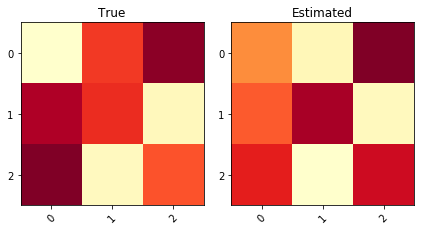

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


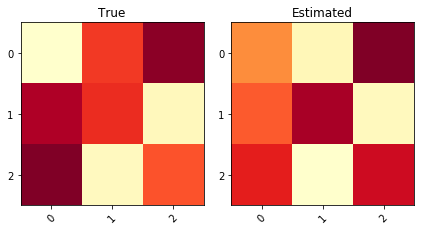

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


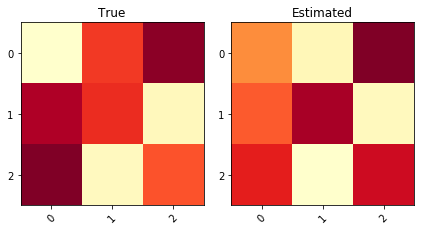

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


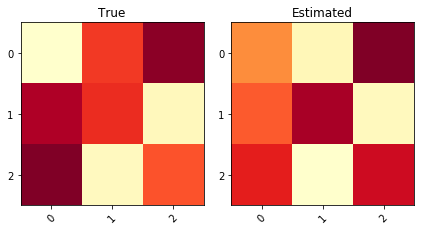

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


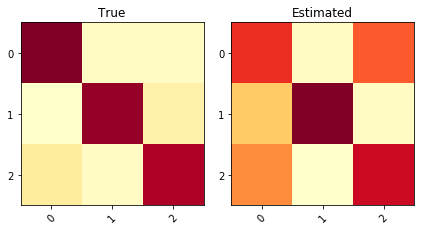

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


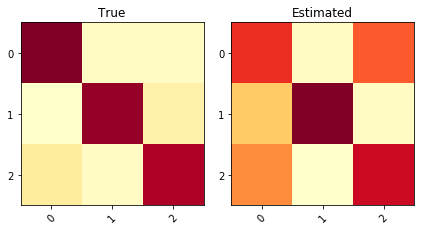

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


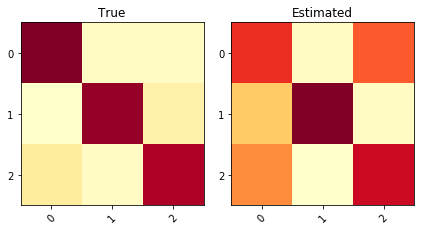

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


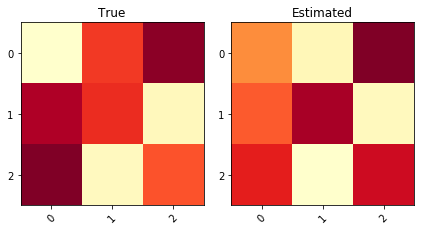

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


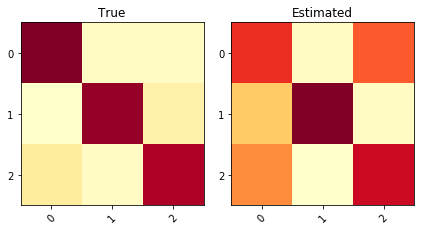

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


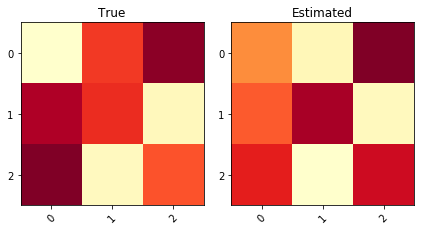

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


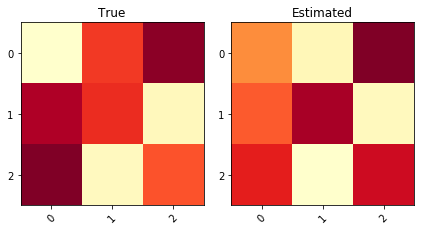

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


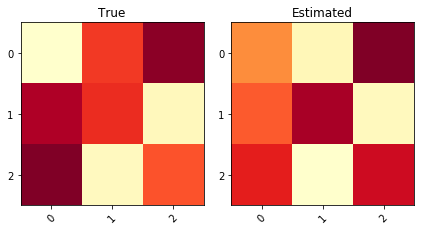

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


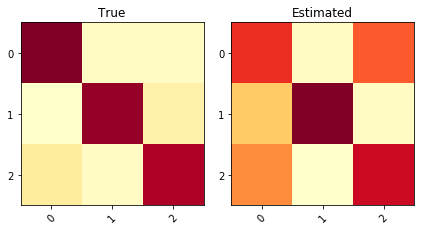

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


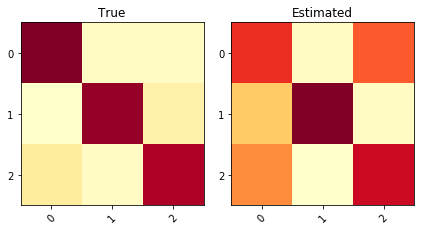

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


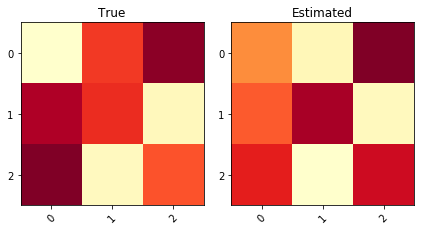

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


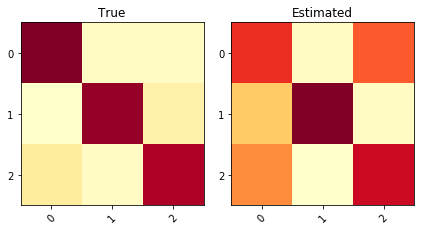

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


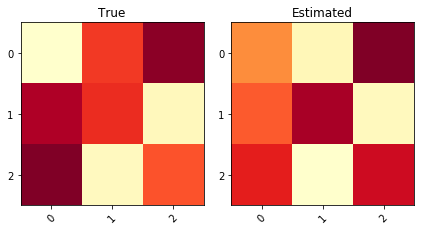

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


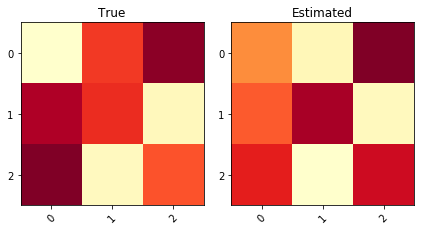

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


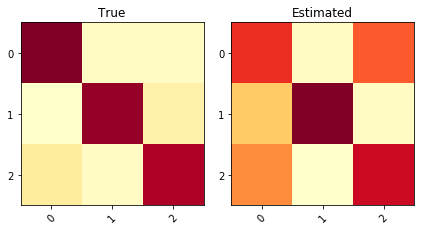

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


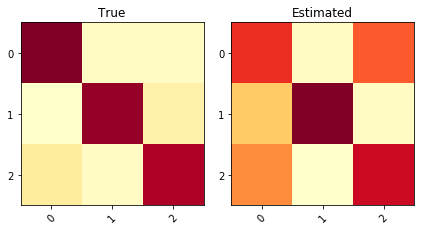

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


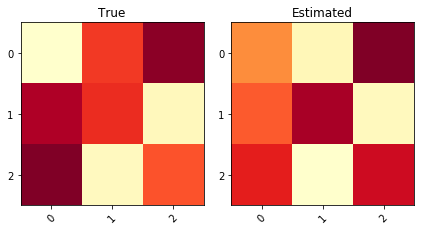

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


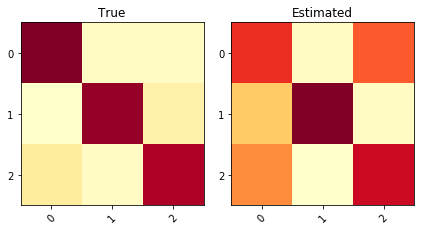

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


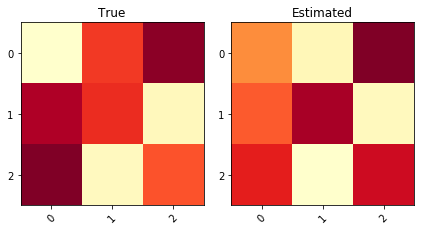

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


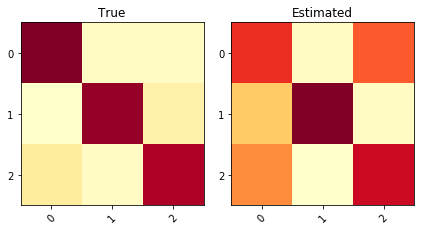

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


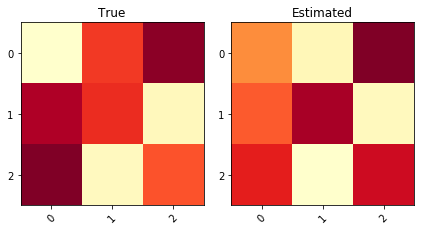

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


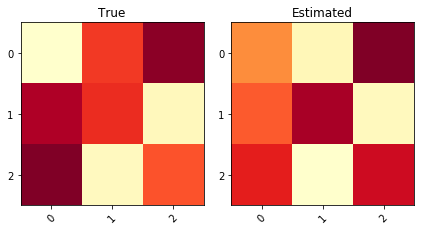

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


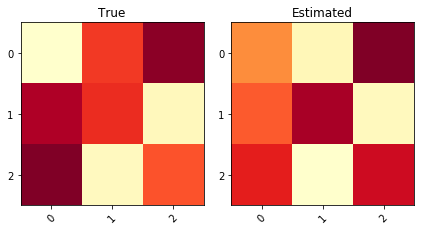

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


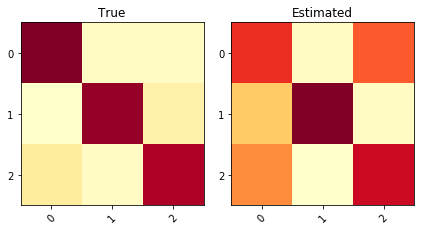

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


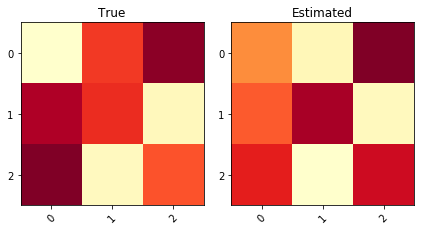

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


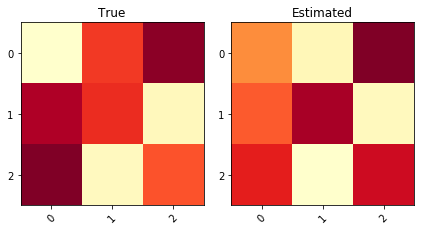

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


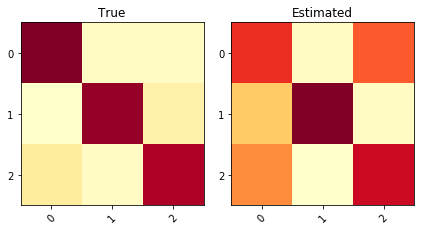

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


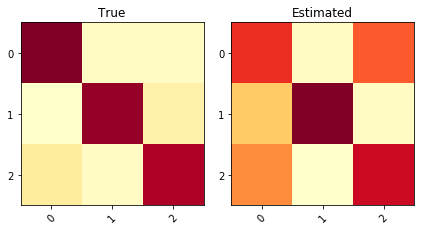

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


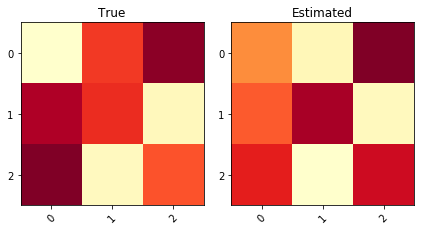

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


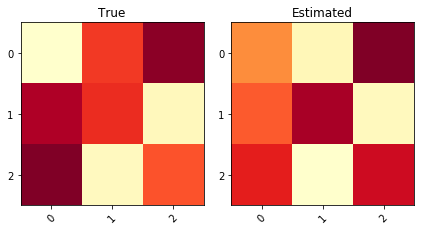

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


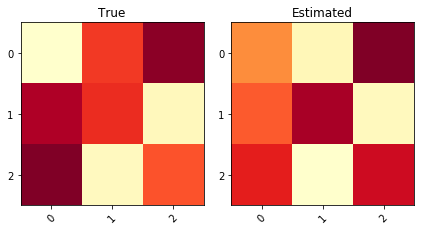

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


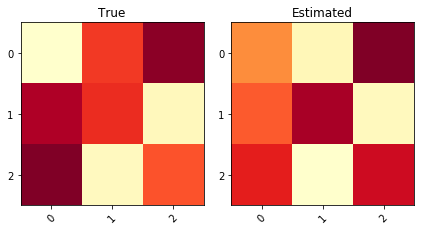

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


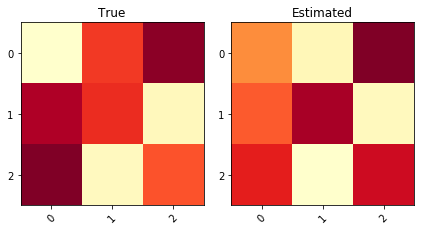

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


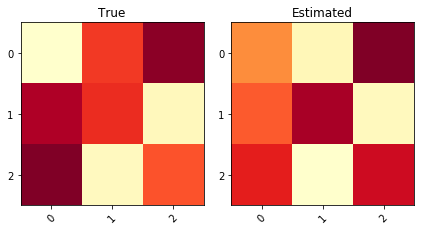

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


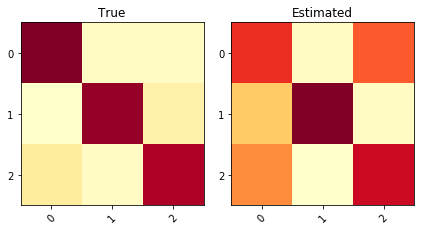

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


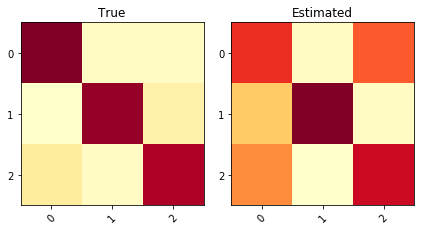

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


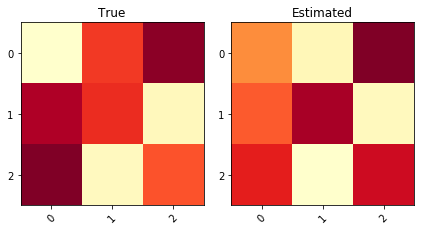

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


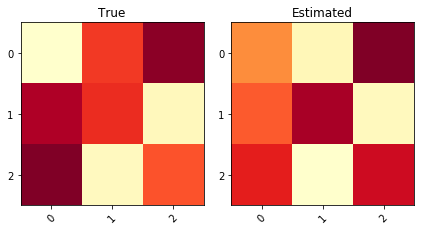

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


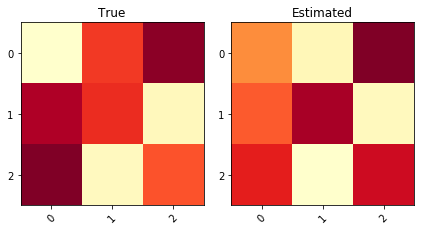

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


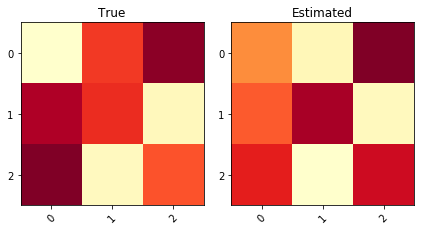

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


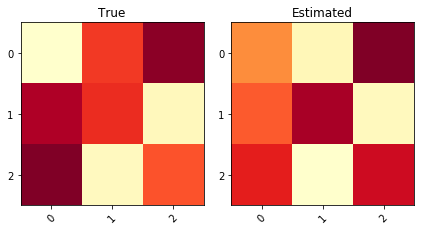

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


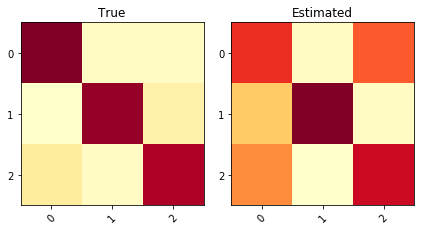

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


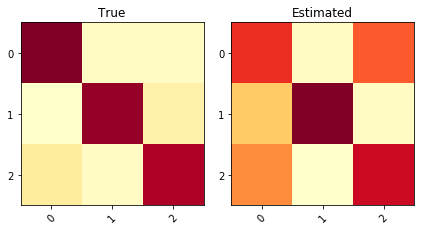

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


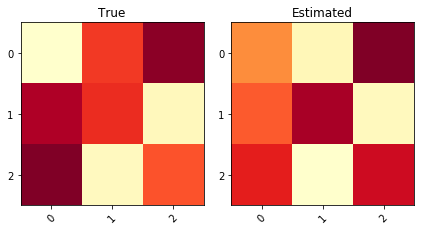

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


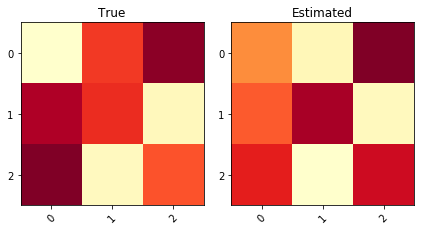

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


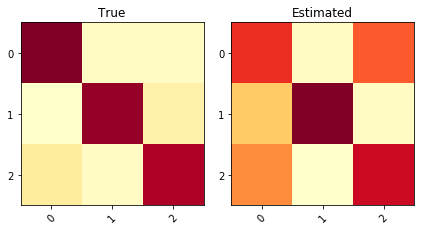

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


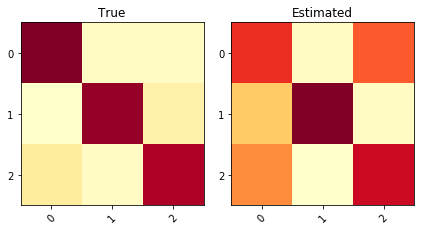

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


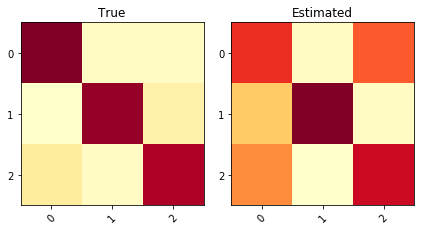

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


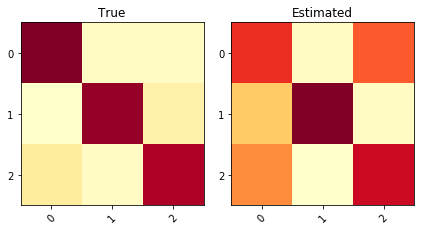

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


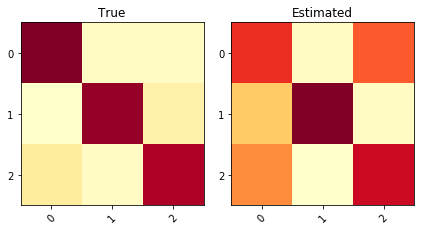

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


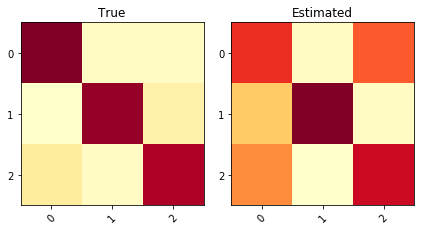

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


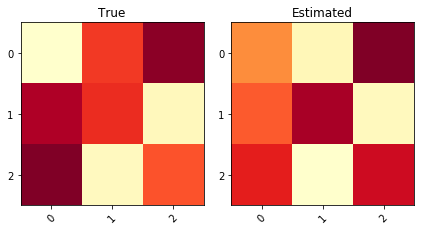

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


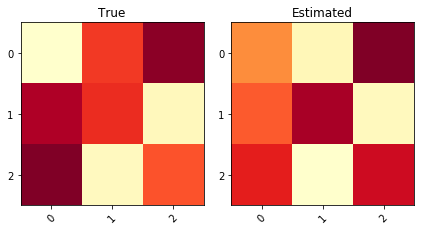

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


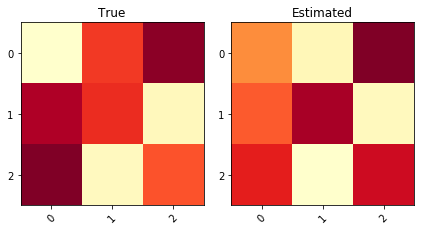

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


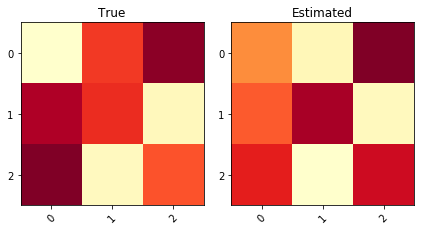

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


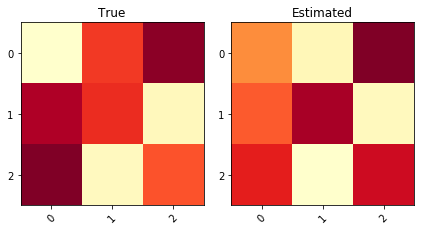

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


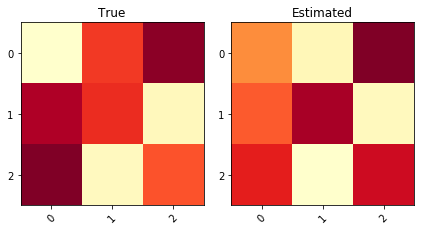

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


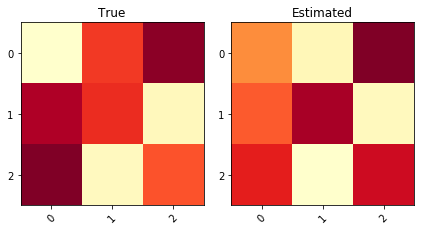

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


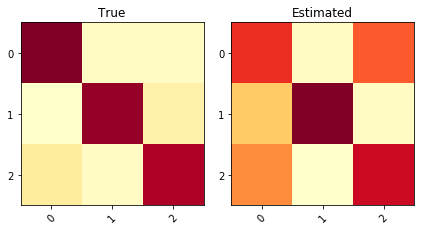

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


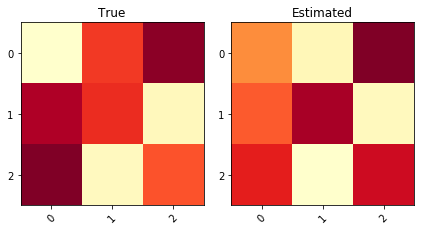

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


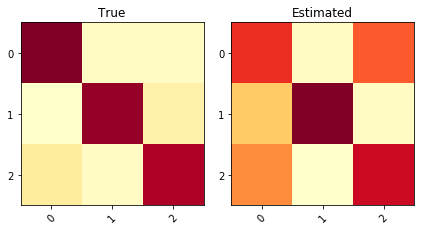

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


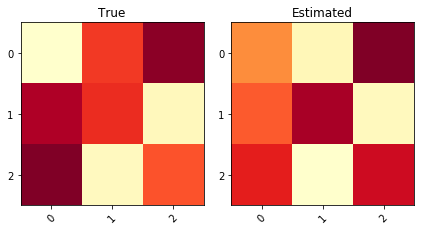

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


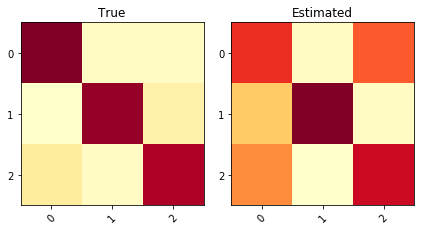

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


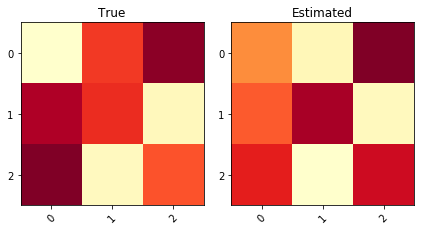

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


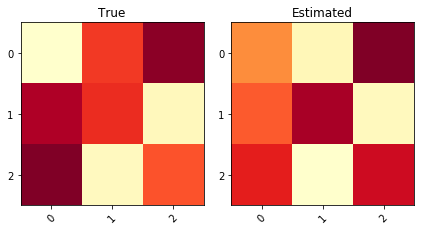

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


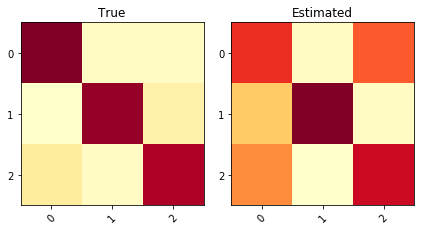

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


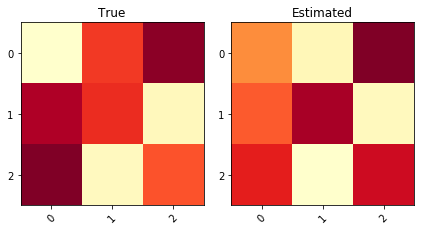

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


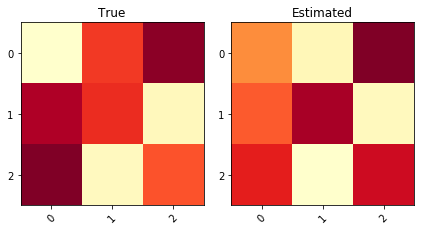

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


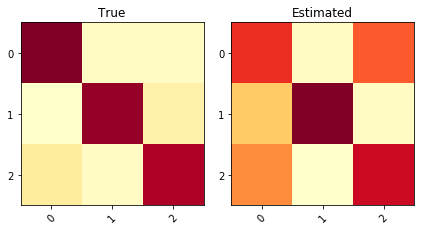

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


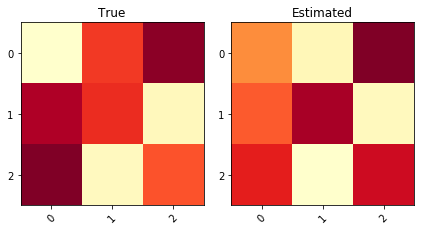

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


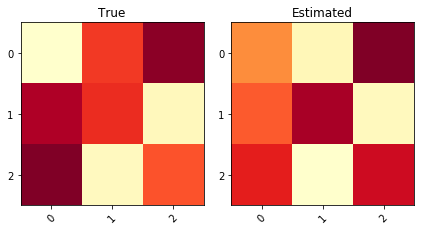

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


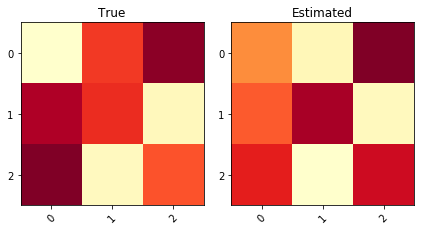

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


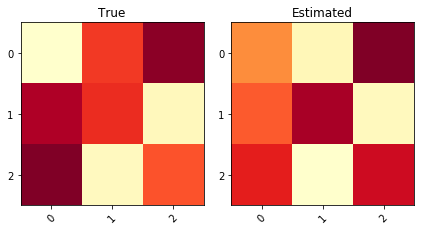

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


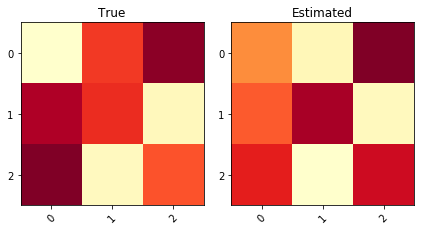

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


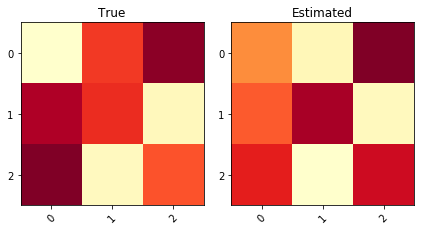

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


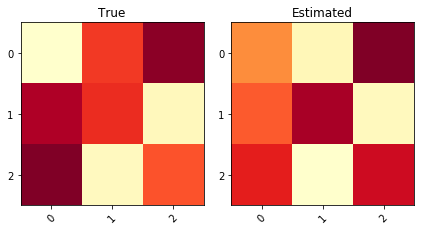

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


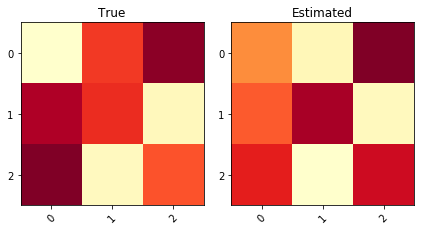

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


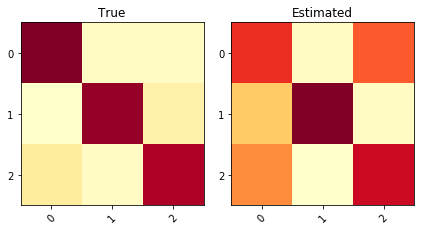

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


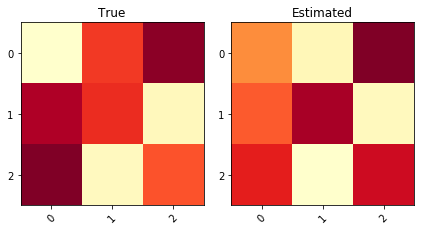

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


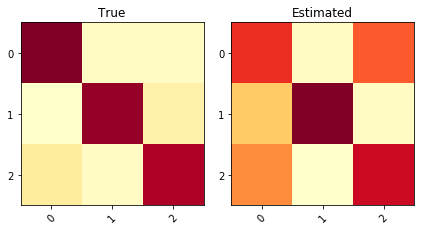

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


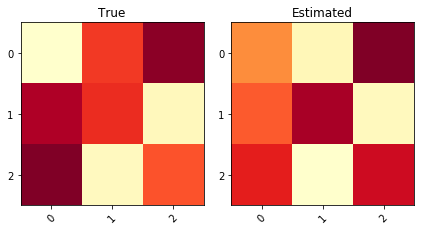

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


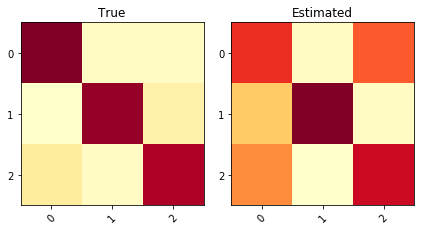

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637


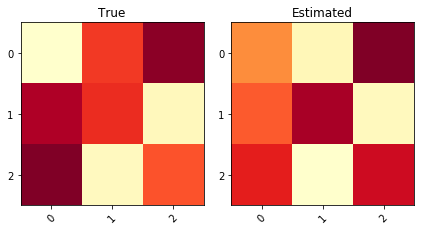

KL divergence: 0.3030	Pearson Correlation between diagonals: 0.9941


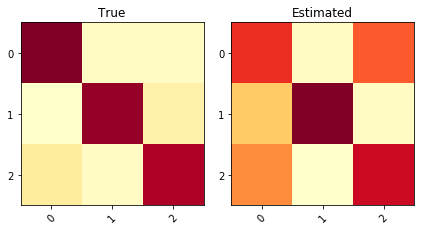

KL divergence: 0.2946	Pearson Correlation between diagonals: -0.3637
Result:     Group  Accuracy  F1 score (micro)
0      0  0.655926          0.632396
1      1  0.866667          0.866246
Result:             Accuracy  F1 score (micro)  Average KL  Average PearsonCorr  \
0  Global  0.815926          0.813881    0.299623              0.45095   

   Average RMSE  
0      0.133191  


In [305]:
#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
#argmax groups
y_o_groups = predictions_m.argmax(axis=-1)

results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [322]:
#train bulk annotations without GT
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

A result
  +----+------------------------------+-----------------------------------+
|    |   Accuracy imiting Annotator |   Cross-entropy imiting Annotator |
|----+------------------------------+-----------------------------------|
|  0 |                      0.56207 |                         -0.935785 |
+----+------------------------------+-----------------------------------+


There are 2 real and 2 predicted Conf matrices


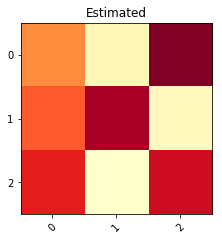

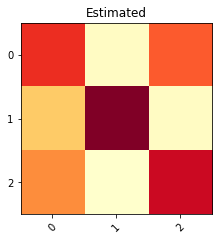

Inertia: 0.006650748726238534
A result
  +----+----------+-----------+------------------+------------------+---------+------------+--------------------+
|    |   Groups |   Entropy |   Diagional Mean |   KL to identity |   Group |   Accuracy |   F1 score (micro) |
|----+----------+-----------+------------------+------------------+---------+------------+--------------------|
|  0 |        0 |  0.786906 |         0.472749 |         0.77975  |       0 |   0.684815 |           0.620032 |
|  1 |        1 |  0.741721 |         0.622322 |         0.484472 |       1 |   0.974444 |           0.974425 |
+----+----------+-----------+------------------+------------------+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |   0.951111 |           0.951039 |
+----+--------+------------+--------------------+


In [323]:
#test or train without bulks annotation?--as repeats--- no annotations but ground truth
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
y_o_groups = gMixture.get_predictions_groups(Xstd_test) #obtain p(y^o|x,g=m)
#argmax groups
y_o_groups = y_o_groups.argmax(axis=-1)

results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

There are 2 real and 2 predicted Conf matrices


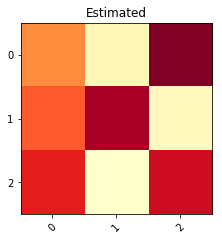

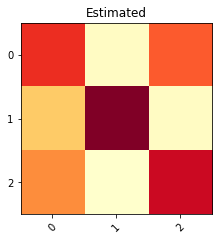

Inertia: 0.006650748726238534
Result:     Groups   Entropy  Diagional Mean  KL to identity
0       0  0.786906        0.472749        0.779750
1       1  0.741721        0.622322        0.484472


In [308]:
#test without GT
results = evaluate.calculate_metrics(conf_pred=c_M)

In [36]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (50000, 10)
Betas:  (3, 10, 10)
Q estimate:  (50000, 10, 3, 10)
Iter 1/50
M step: done	E step: done, (in 72.82 sec)	logL: -2715965.263	F1: 0.6261
Iter 2/50
M step:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 done	E step: done, (in 70.89 sec)	logL: -2679319.023	Tol: 0.01349	F1: 0.6246
Iter 3/50
M step: done	E step: done, (in 71.24 sec)	logL: -2637561.656	Tol: 0.01559	F1: 0.6541
Iter 4/50
M step: done	E step: done, (in 73.48 sec)	logL: -2620187.453	Tol: 0.00659	F1: 0.6679
Iter 5/50
M step: done	E step: done, (in 72.33 sec)	logL: -2608219.150	Tol: 0.00457	F1: 0.6693
Iter 6/50
M step: done	E step: done, (in 71.42 sec)	logL: -2592777.869	Tol: 0.00592	F1: 0.6812
Iter 7/50
M step: done	E step: done, (in 71.17 sec)	logL: -2581476.336	Tol: 0.00436	F1: 0.6877
Iter 8/50
M step: done	E step: done, (in 71.09 sec)	logL: -2576276.410	Tol: 0.00201	F1: 0.6841
Iter 9/50
M step: done	E step: done, (in 72.50 sec)	logL: -2566063.387	Tol: 0.00396	F1: 0.6931
Iter 10/50
M step: done	E step: done, (in 70.87 sec)	logL: -2562741.495	Tol: 0.00129	F1: 0.6959
Iter 11/50
M step: done	E step: done, (in 70.85 sec)	logL: -2559842.885	Tol: 0.00113	F1: 0.6933
Iter 12/50
M step: done	E step: done, (in 71.25 sec)	logL: -25533

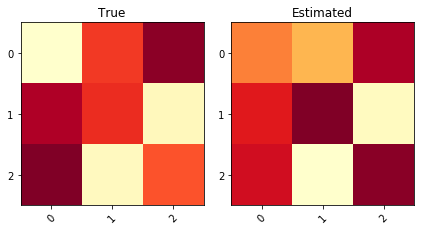

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


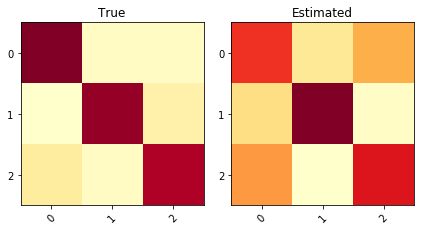

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


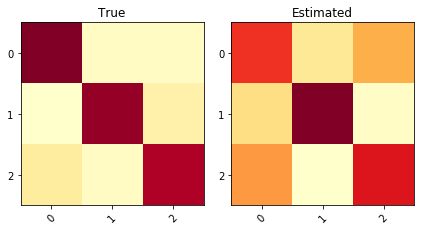

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


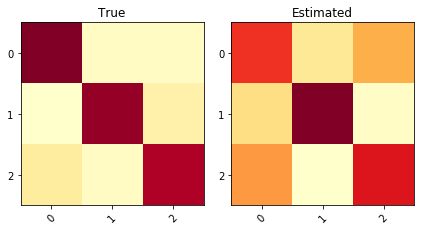

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


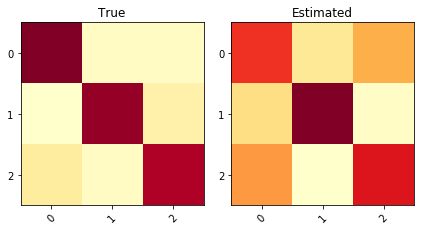

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


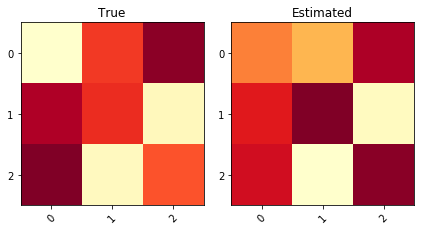

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


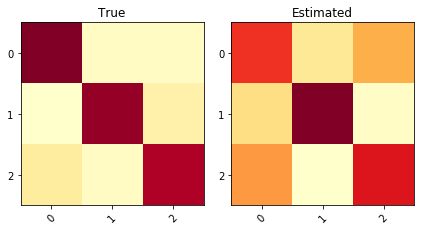

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


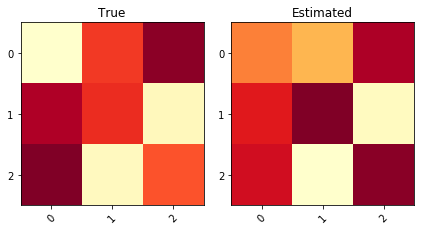

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


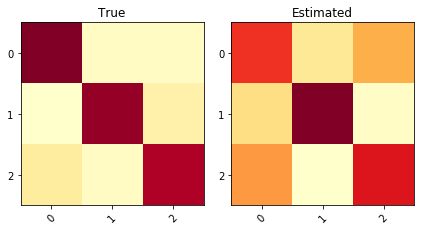

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


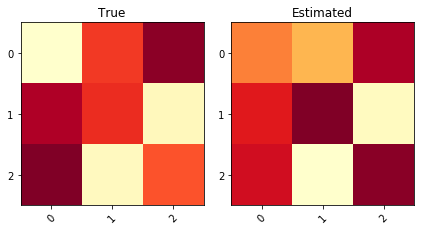

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


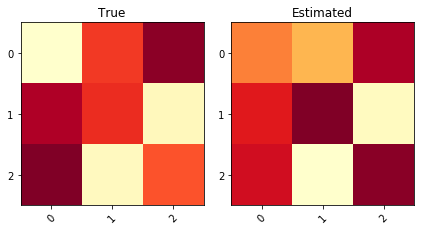

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


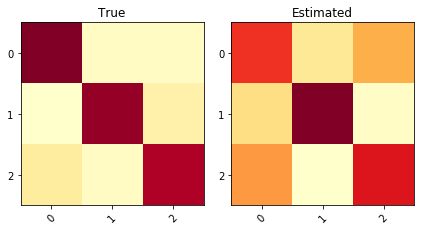

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


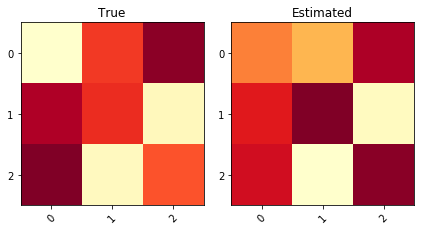

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


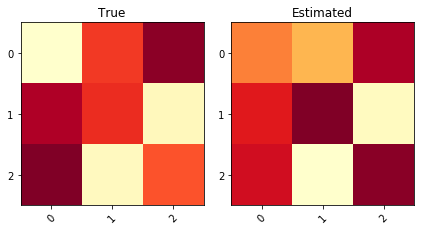

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


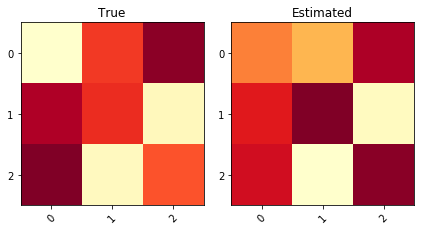

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


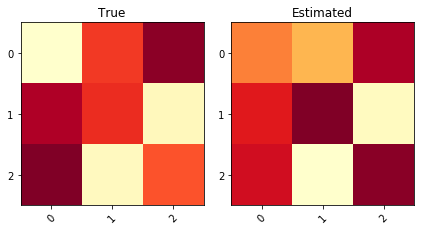

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


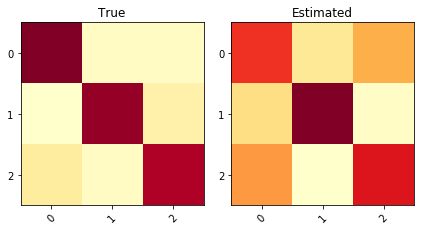

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


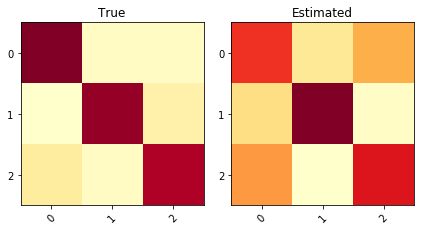

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


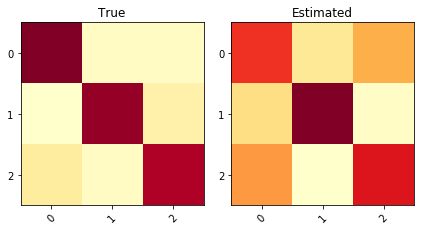

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


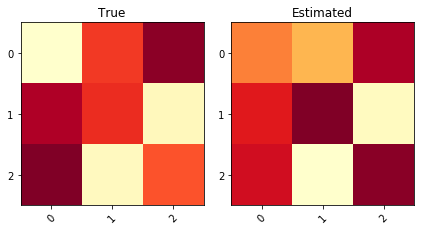

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


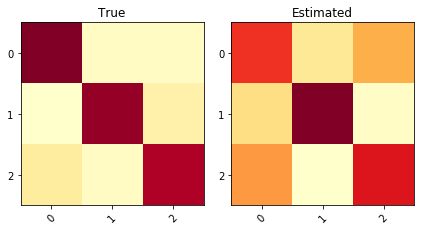

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


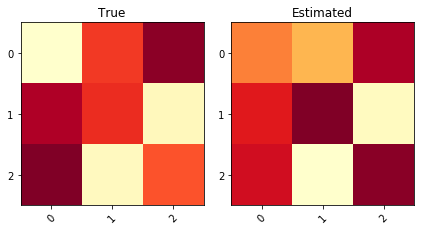

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


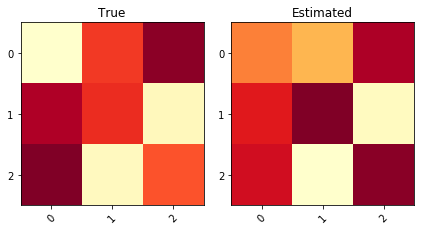

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


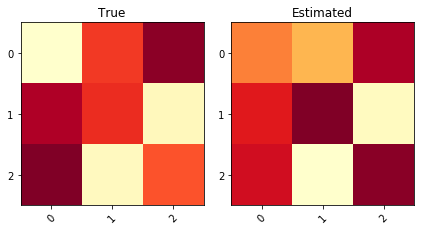

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


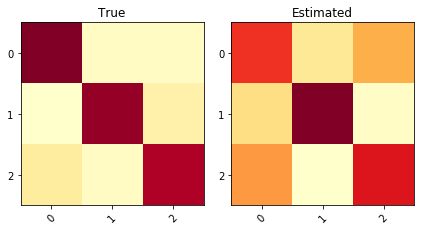

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


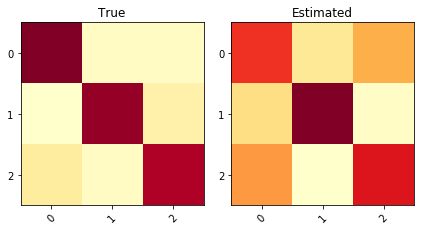

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


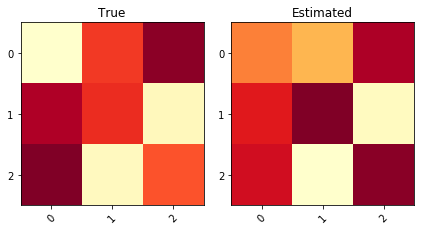

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


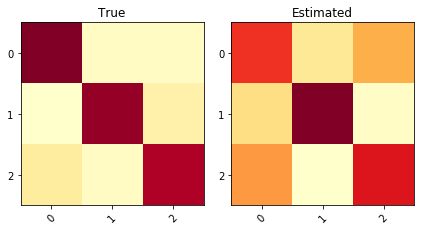

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


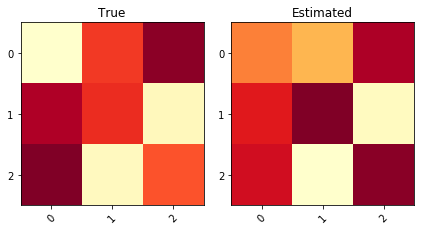

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


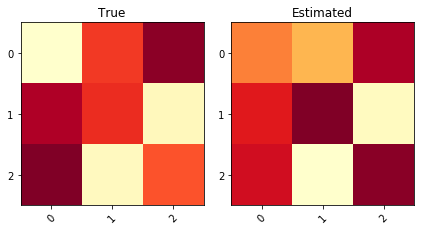

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


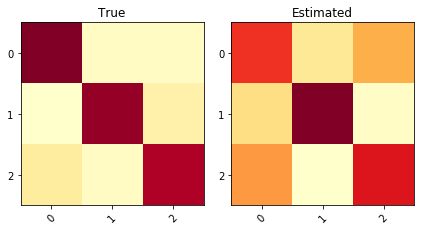

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


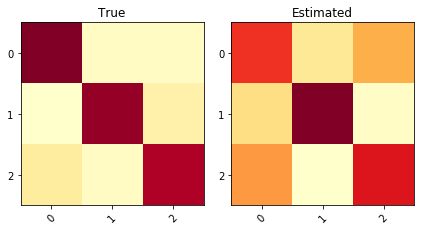

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


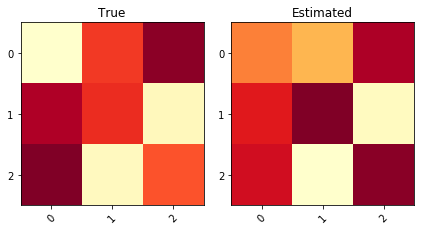

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


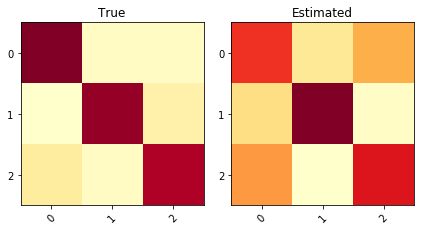

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


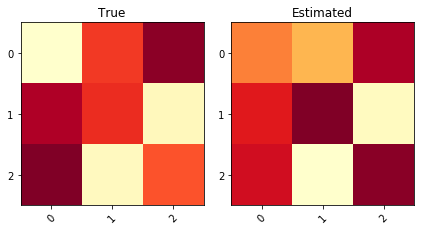

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


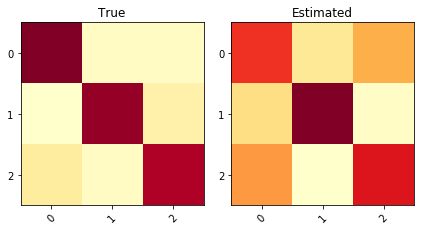

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


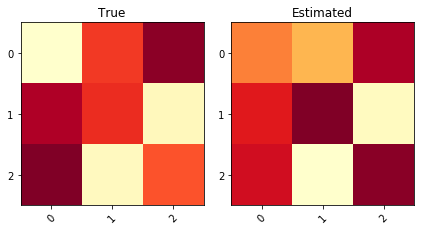

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


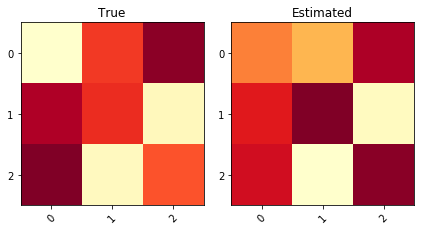

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


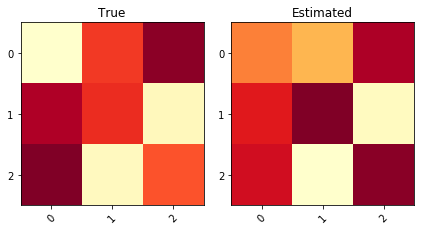

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


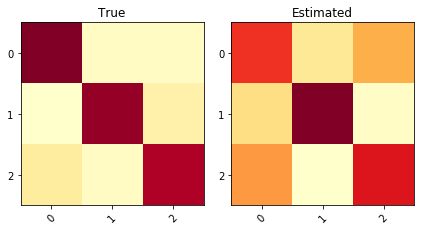

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


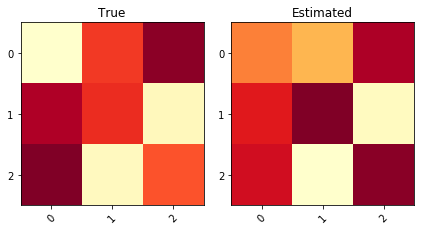

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


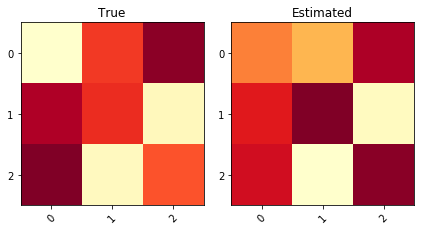

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


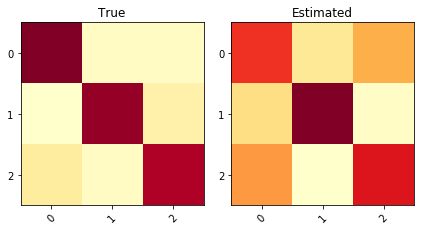

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


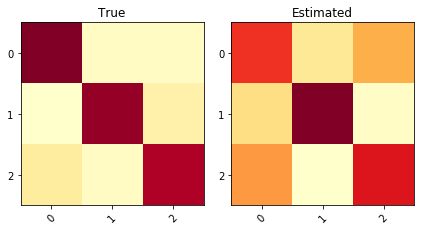

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


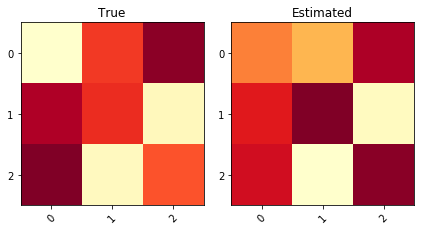

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


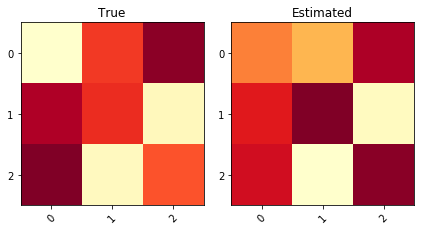

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


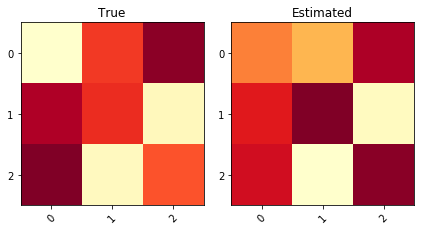

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


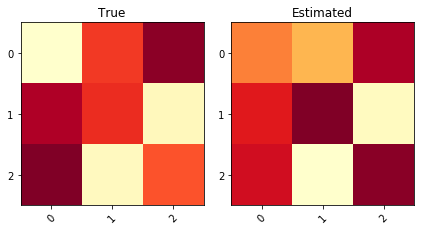

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


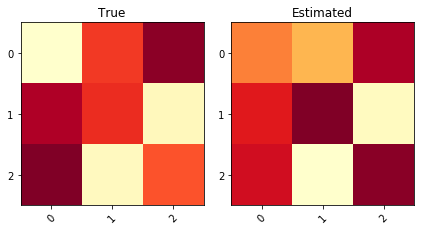

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


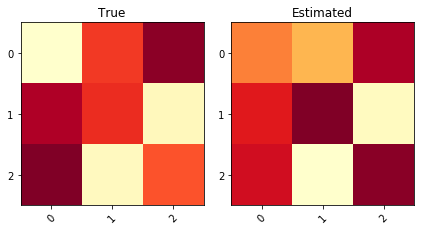

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


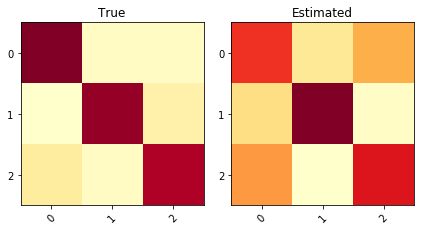

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


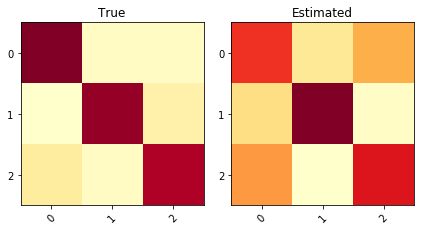

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


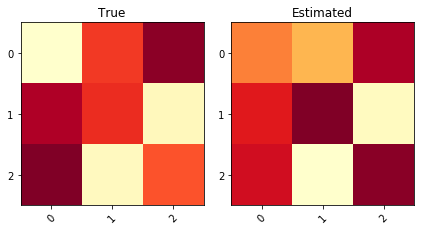

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


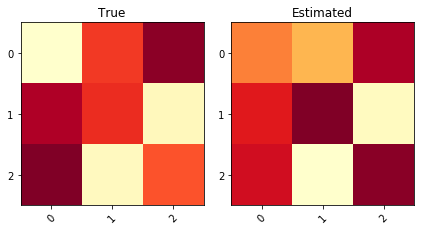

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


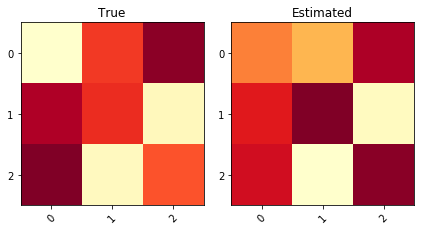

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


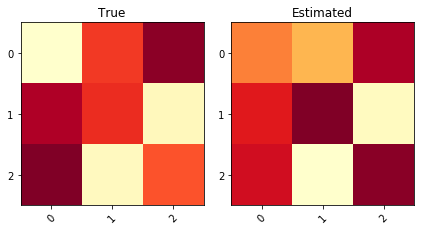

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


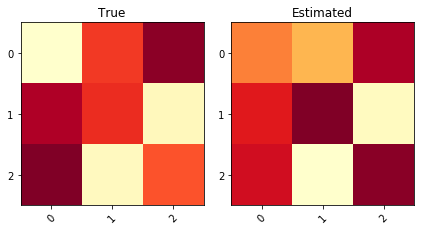

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


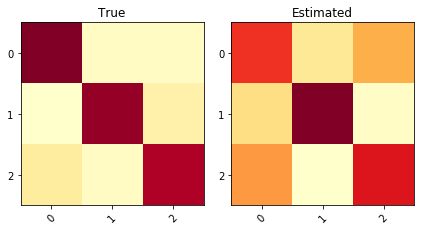

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


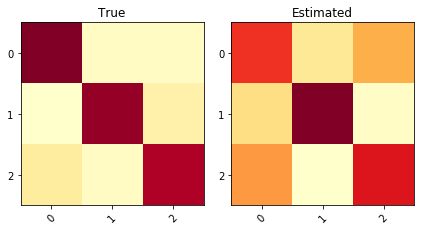

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


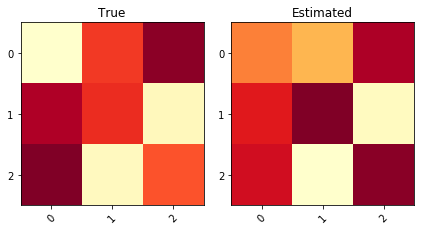

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


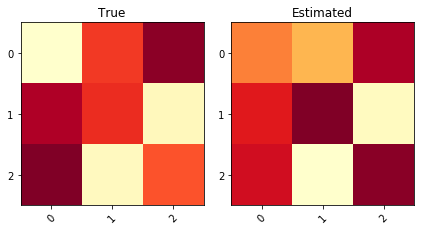

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


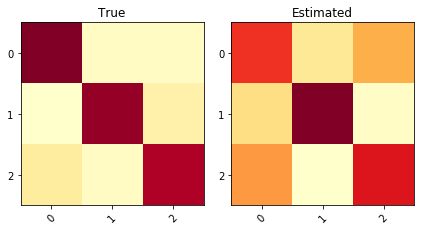

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


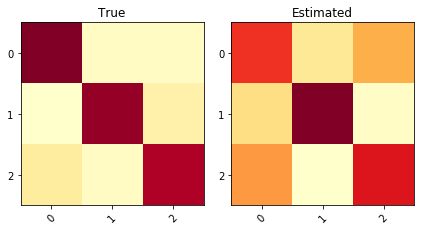

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


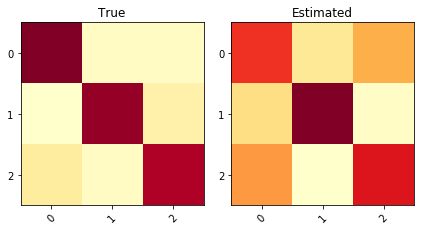

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


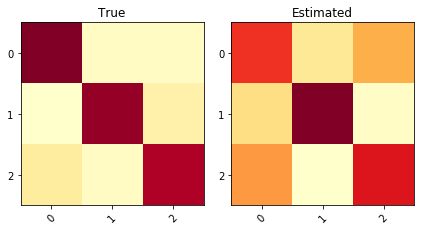

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


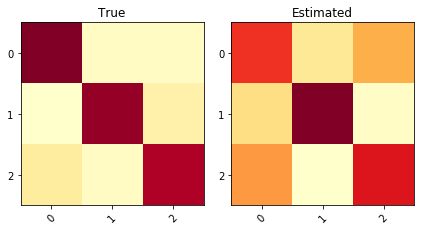

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


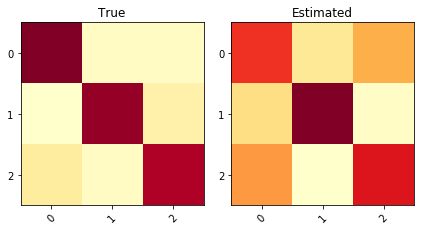

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


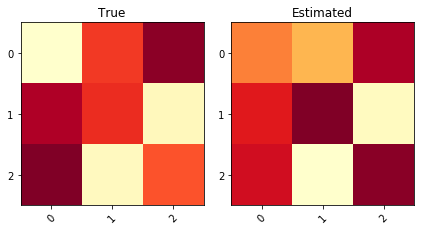

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


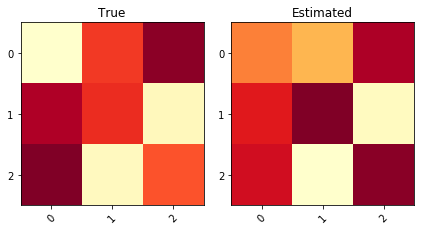

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


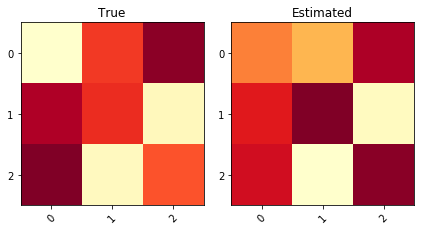

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


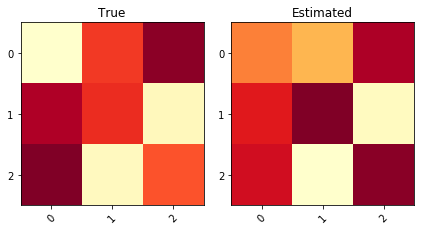

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


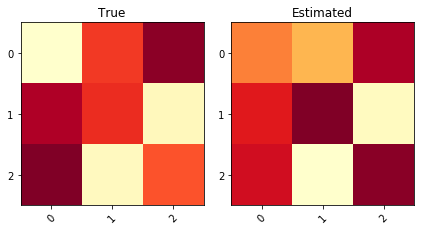

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


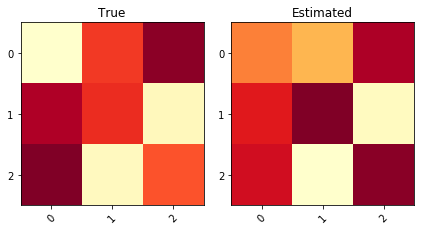

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


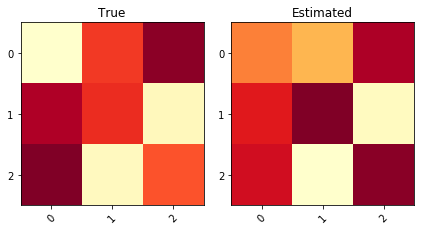

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


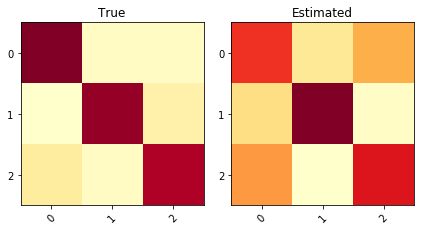

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


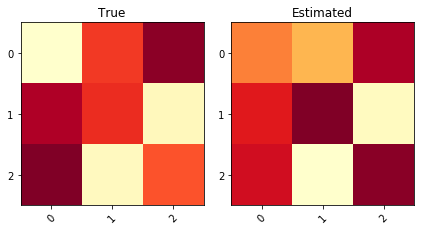

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


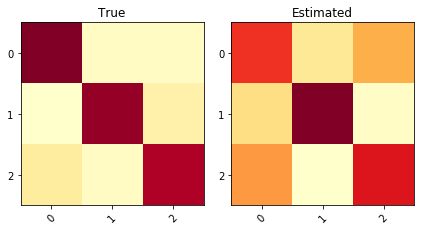

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


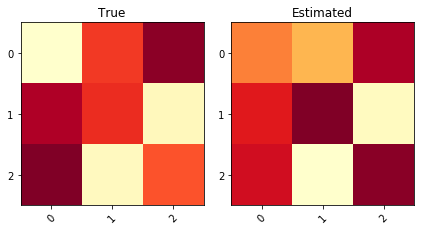

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


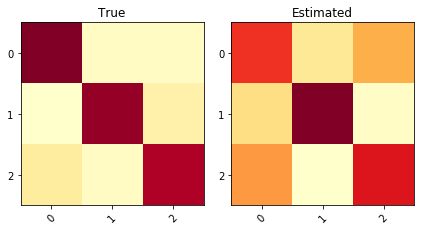

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


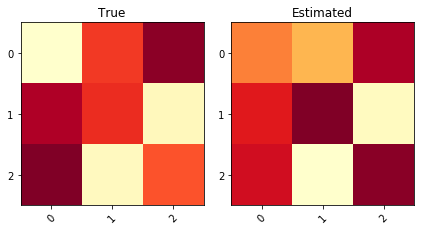

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


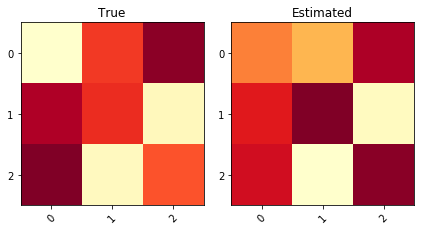

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


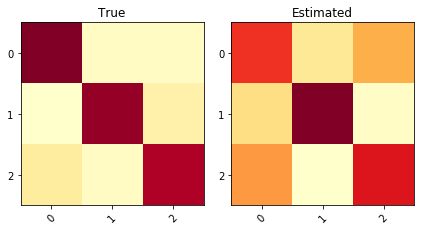

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


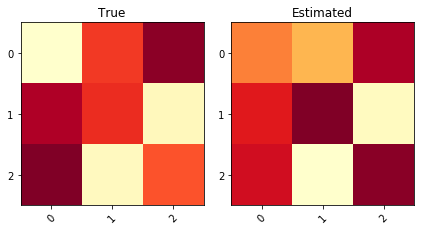

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


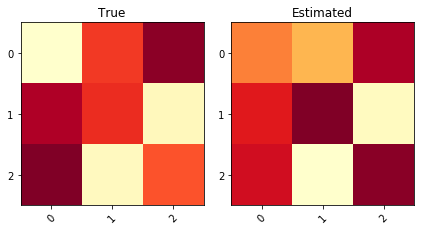

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


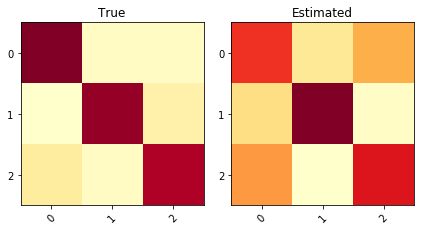

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


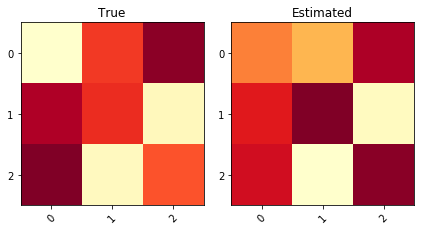

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


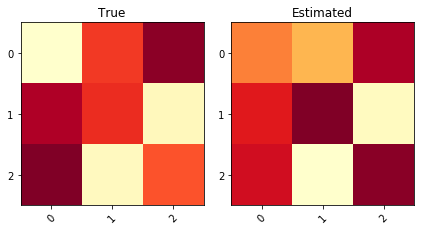

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


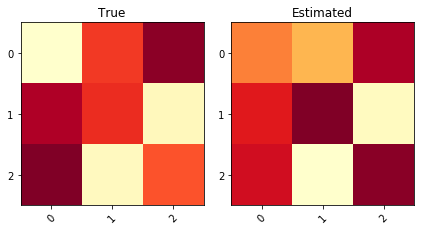

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


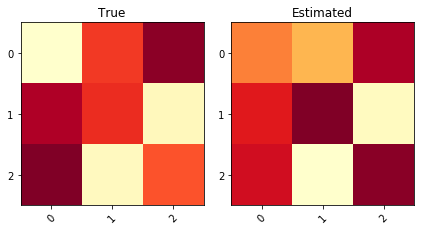

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


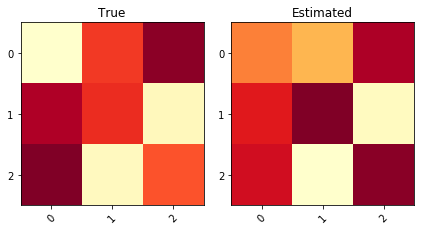

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


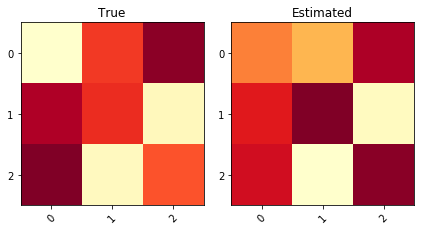

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


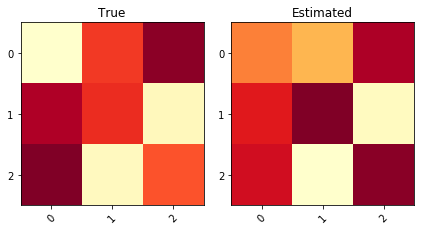

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


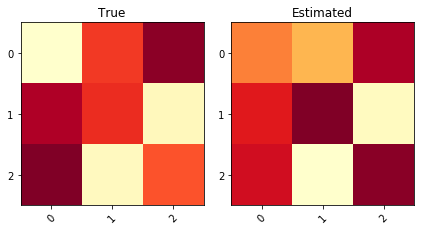

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


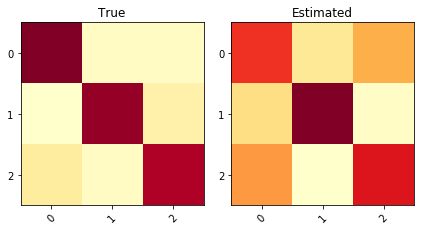

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


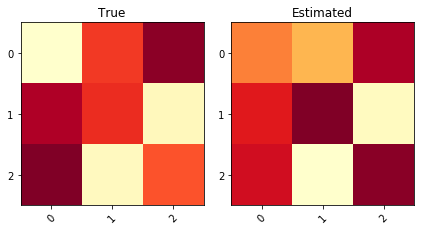

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


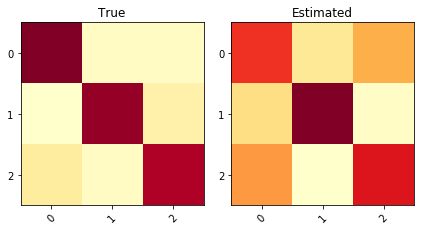

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


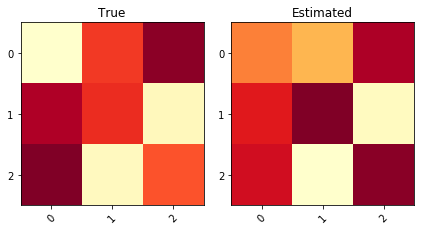

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


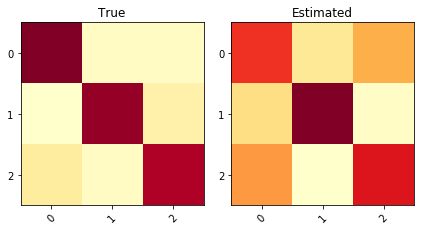

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


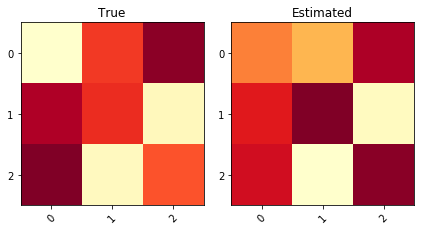

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


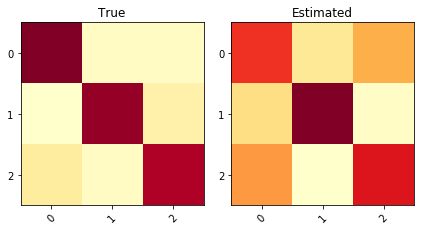

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.894444 |           0.894314 |
|  1 |       1 |   0.600741 |           0.538118 |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.891481 |           0.892084 |     0.185925 |              0.521372 |       0.143939 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.3 s, sys: 517 ms, total: 31.8 s
Wall time: 31.3 s


In [80]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


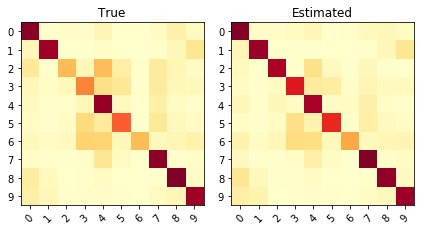

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


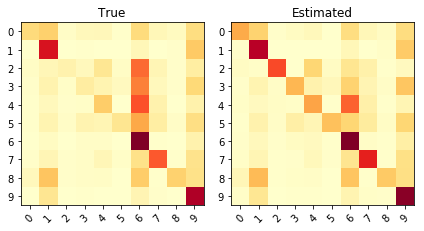

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


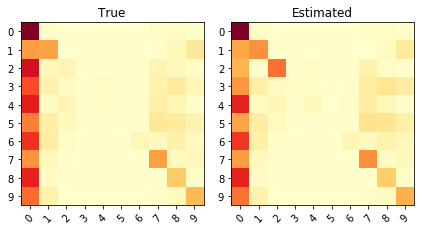

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


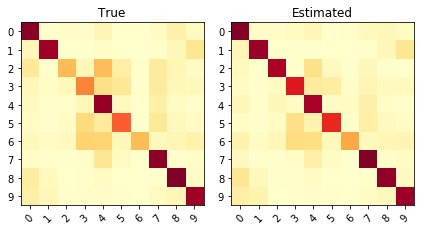

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1114	Pearson Correlation between diagonals: 0.4132


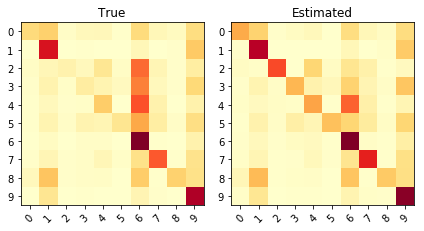

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


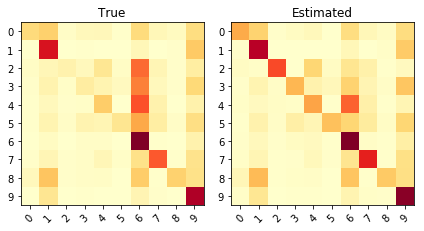

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


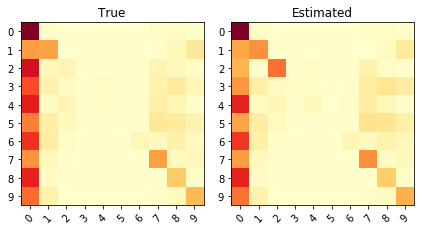

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


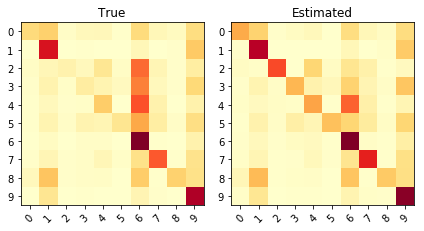

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


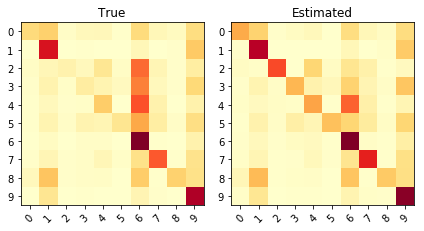

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


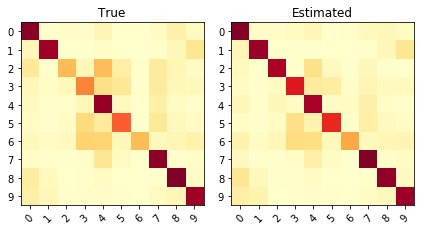

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


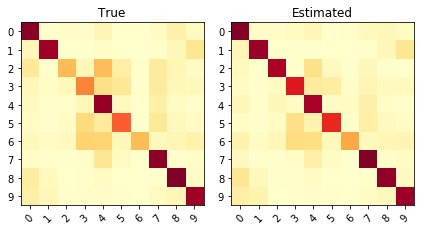

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


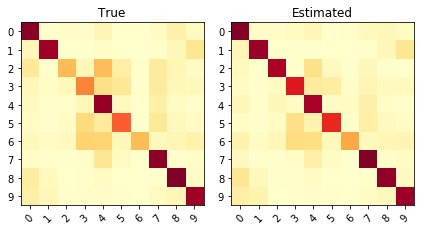

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


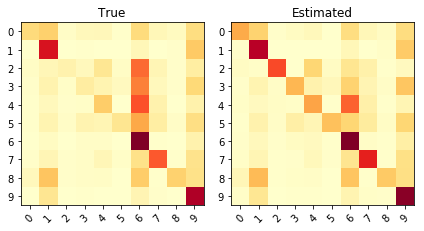

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


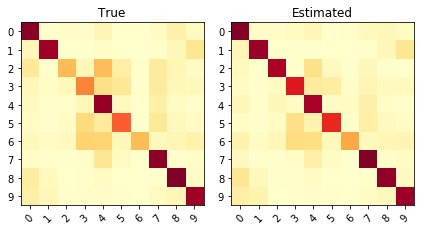

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


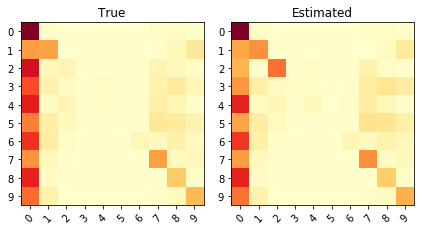

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation betwee

In [37]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [31]:
gMixture = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=1,optimizer=OPT,pre_init=8)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
#gMixture.define_model("simple cnn",start_units=32,deep=3,BatchN=True,drop=0.25)
logL_hist = gMixture.multiples_run(10,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca]) #more runs

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 8 epochs... Done!
Lambda by group:  [0.1378987600466675, 0.24523473249025382, 0.8920139342354865, 0.12216360576995895]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done	E step: done, (in 19.07 sec)	logL: -2638904.850	
Iter 2/50
M step: done	E step: done, (in 19.08 sec)	logL: -2610500.685	Tol: 0.01076	
Iter 3/50
M step: done	E step: done, (in 19.63 sec)	logL: -2591147.926	Tol: 0.00741	
Iter 4/50
M step: done	E step: done, (in 19.23 sec)	logL: -2583362.544	Tol: 0.00300	
Iter 5/50
M step: done	E step: done, (in 18.98 sec)	logL: -2565883.684	Tol: 0.00677	
Iter 6/50
M step: done	E step: done, (in 19.05 sec)	logL: -2578962.508	Tol: 0.00510	
Iter 7/50
M step: done	E step: done, (in 18.66 sec)	logL: -2561385.656	Tol: 0.00682	
Iter 8/50
M step: done	E step: done, (in 18.67 sec)	logL: -2549138.193	Tol: 0.00478	
Iter 9/50
M step: done	E step: done, (in 18.30 sec)	l

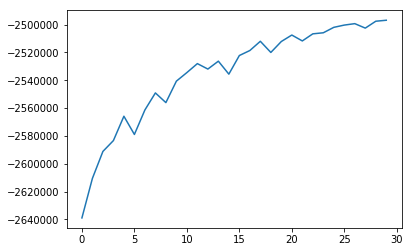

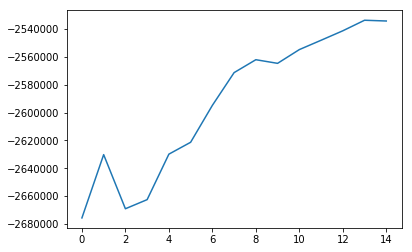

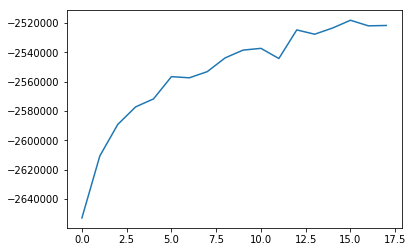

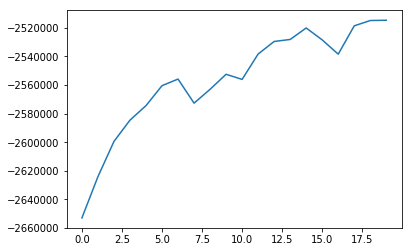

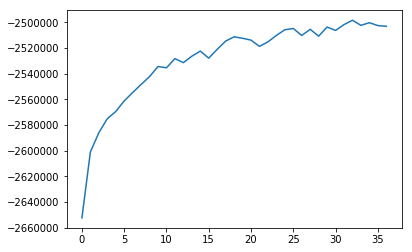

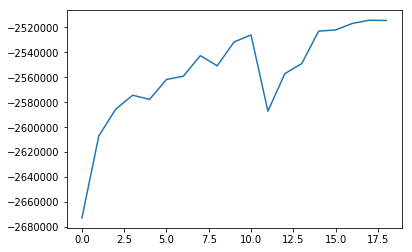

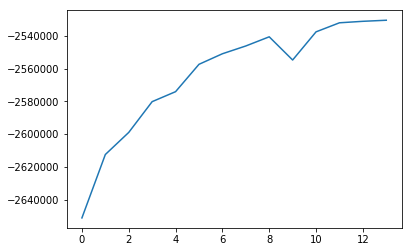

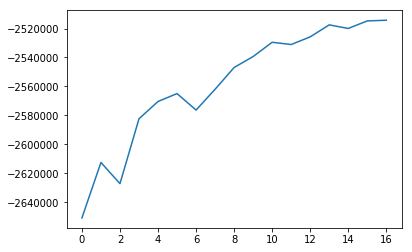

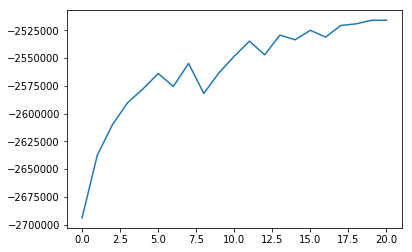

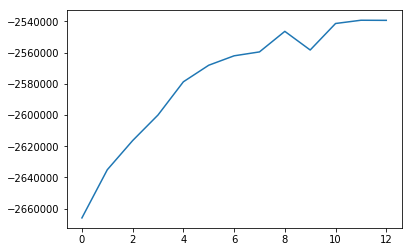

In [32]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#plt.plot(logL_hist)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


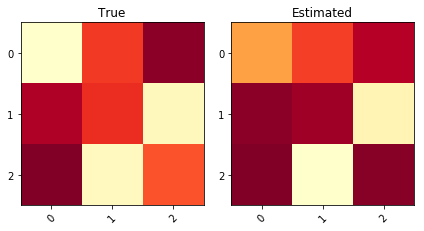

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


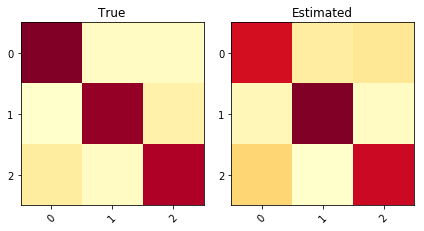

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


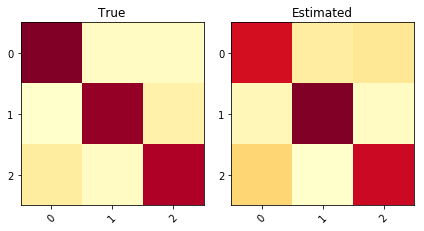

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


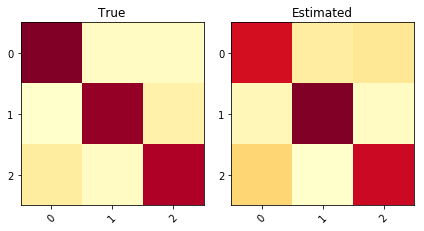

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


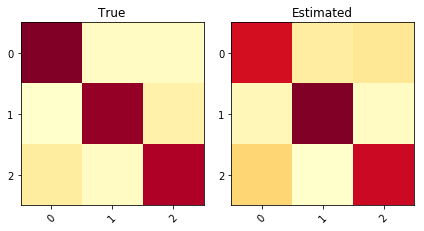

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


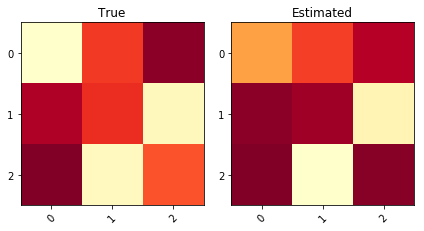

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


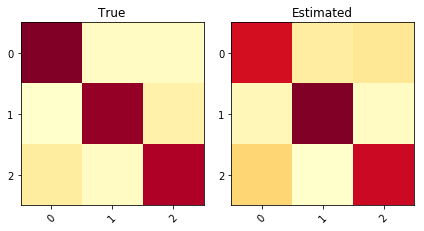

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


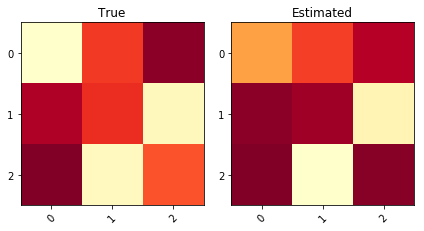

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


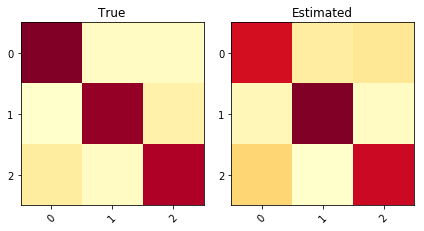

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


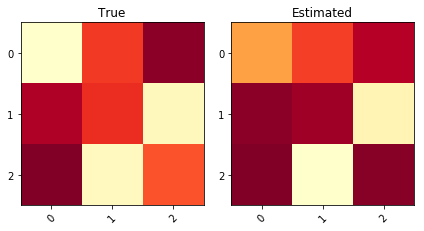

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


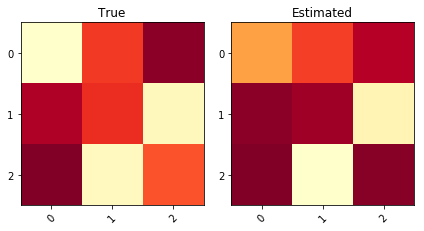

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


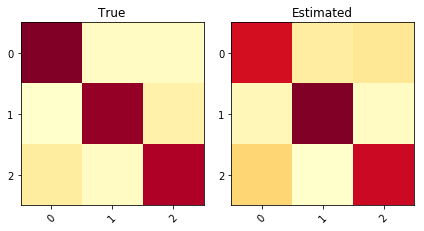

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


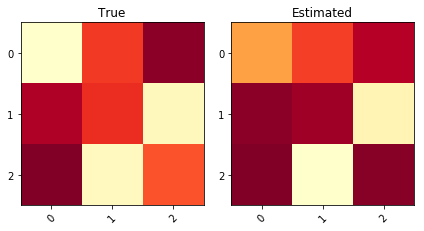

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


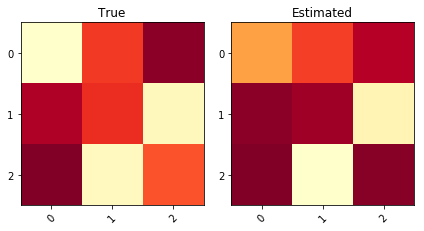

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


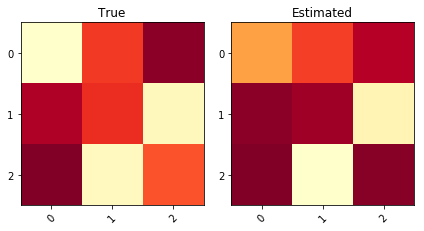

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


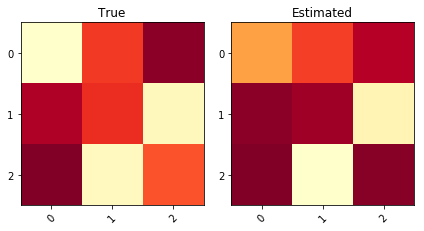

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


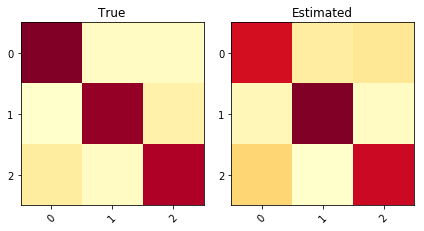

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


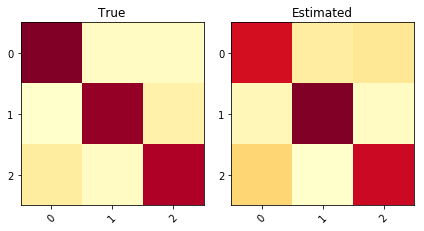

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


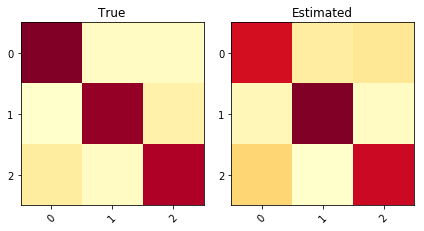

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


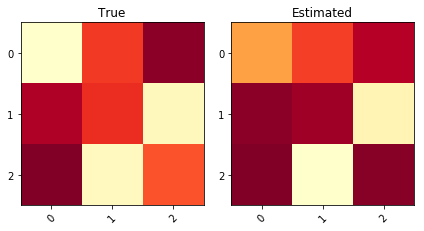

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


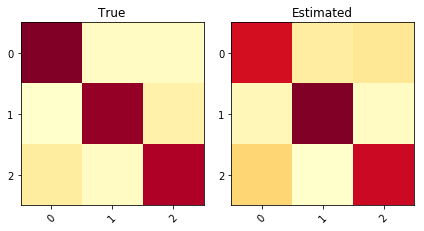

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


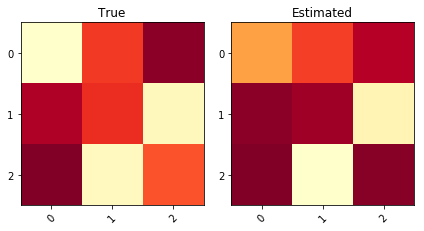

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


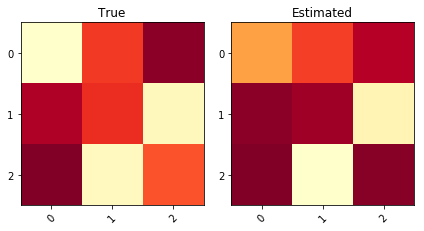

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


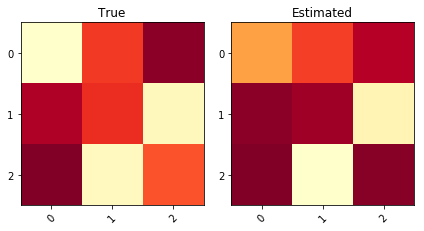

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


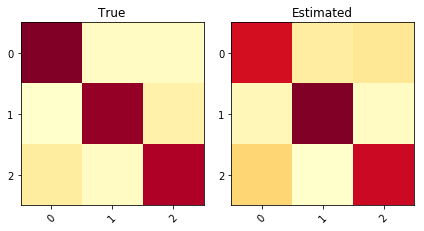

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


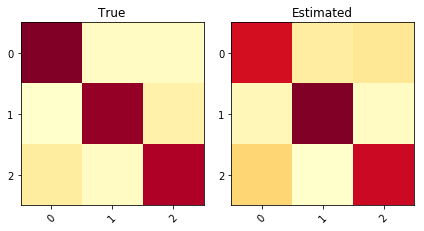

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


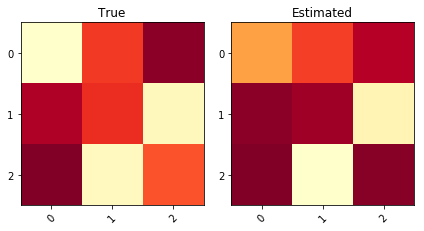

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


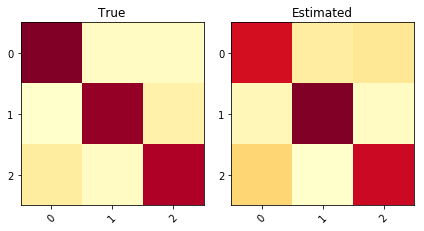

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


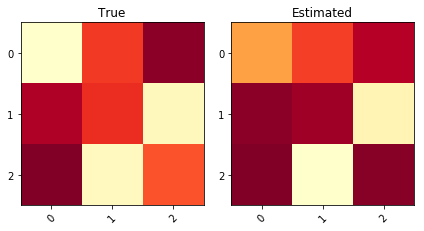

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


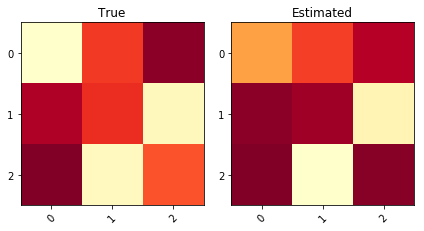

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


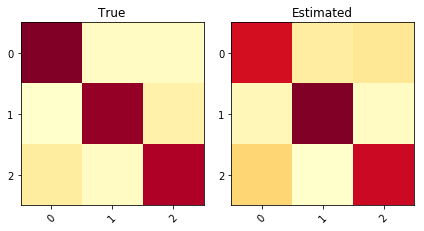

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


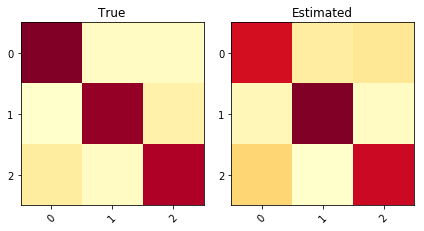

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


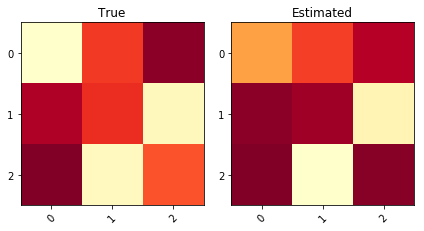

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


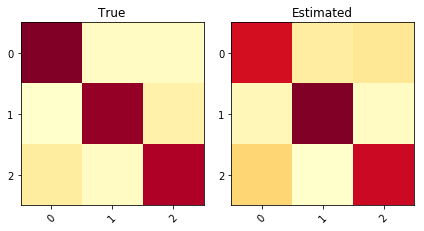

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


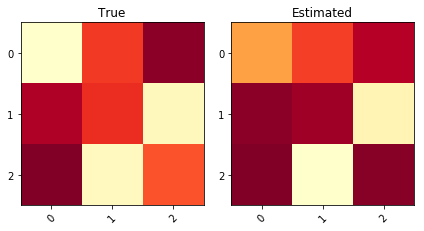

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


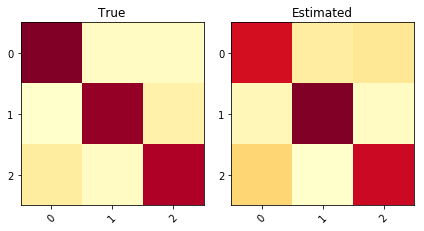

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


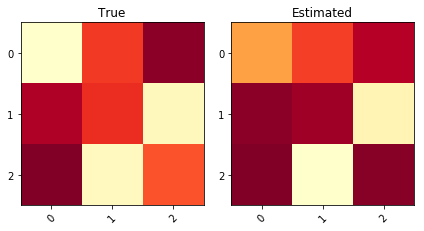

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


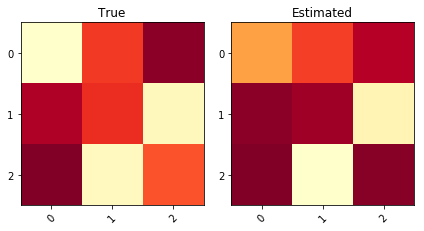

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


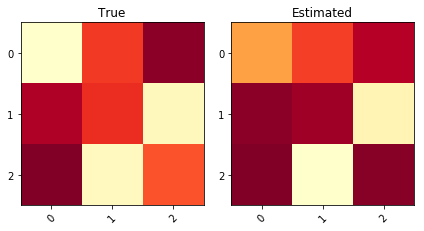

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


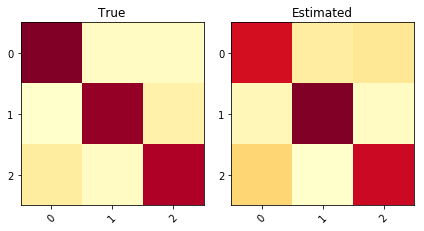

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


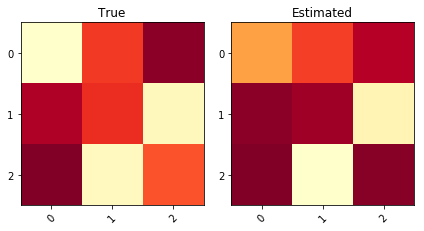

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


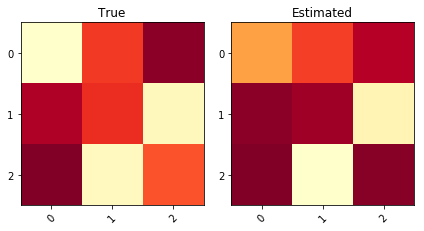

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


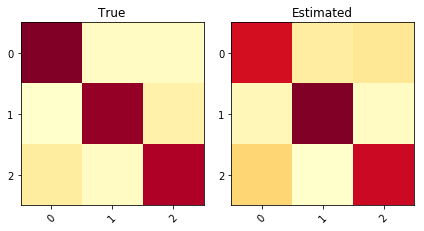

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


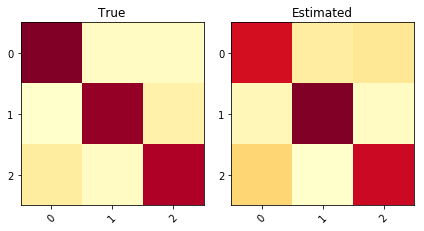

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


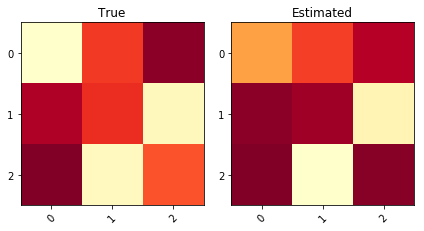

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


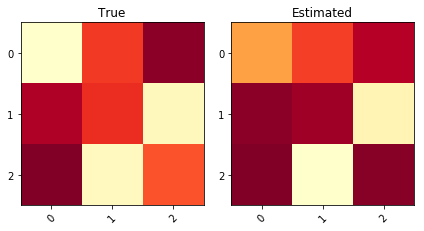

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


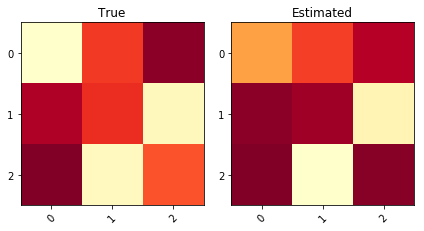

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


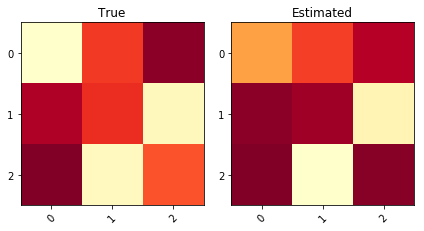

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


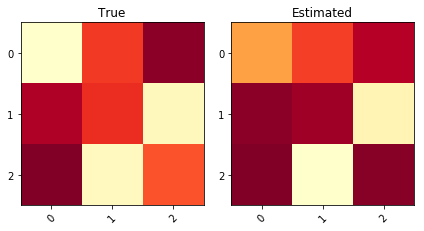

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


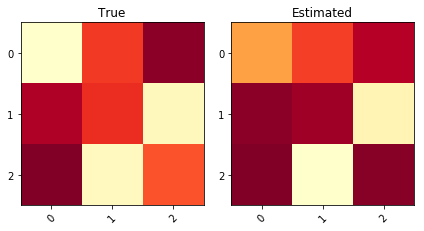

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


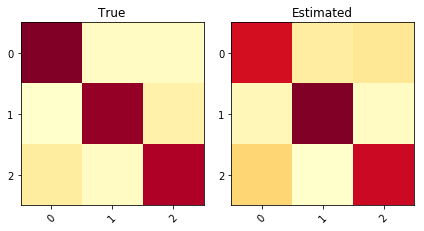

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


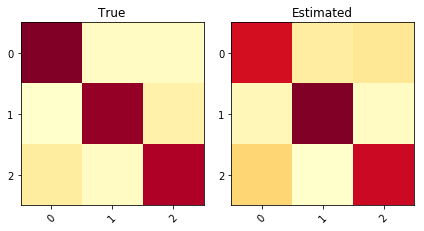

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


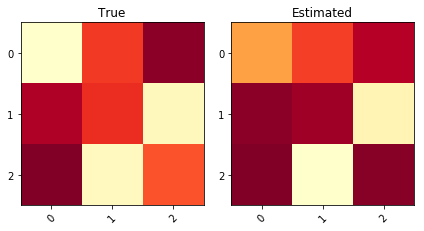

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


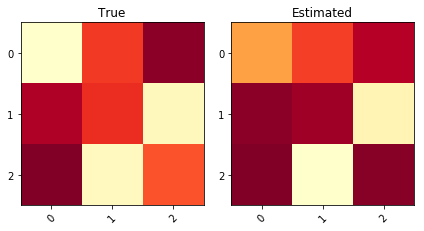

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


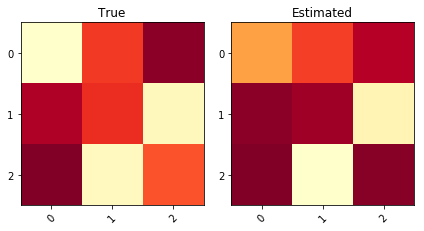

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


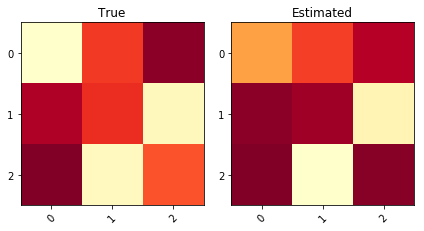

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


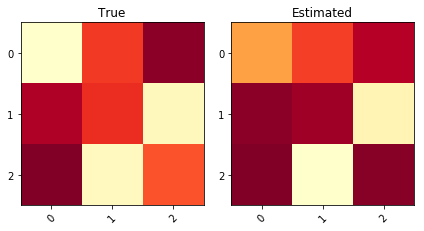

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


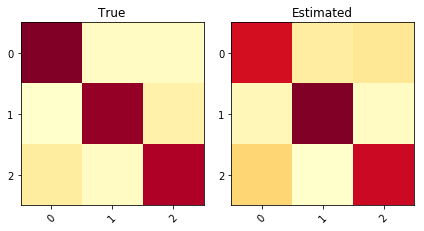

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


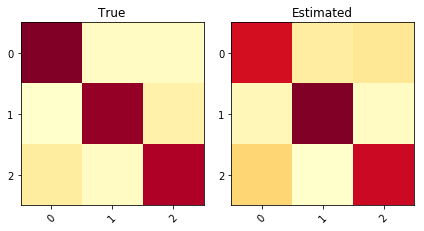

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


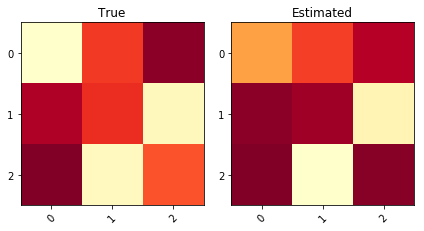

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


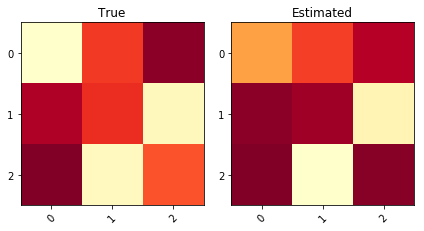

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


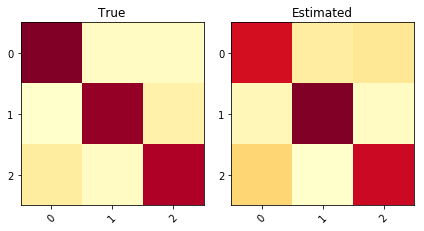

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


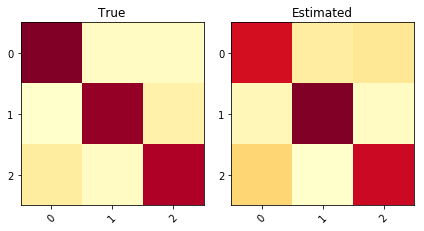

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


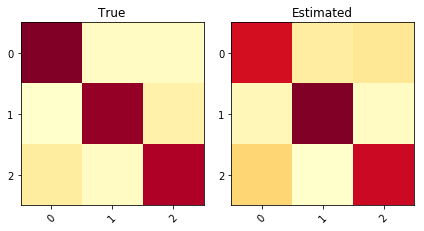

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


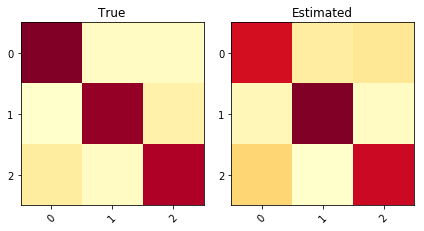

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


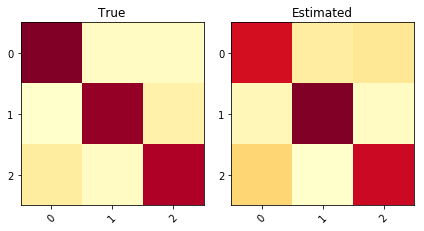

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


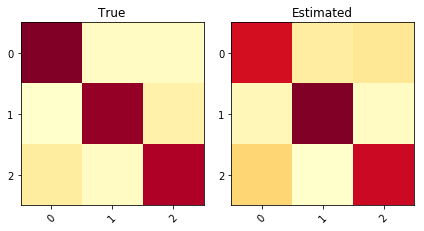

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


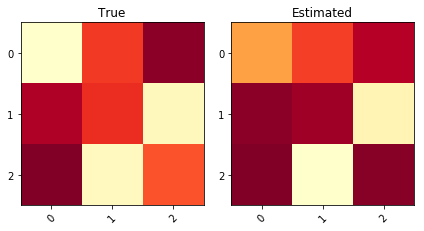

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


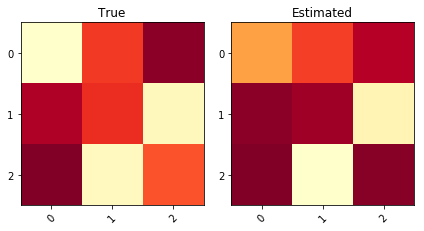

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


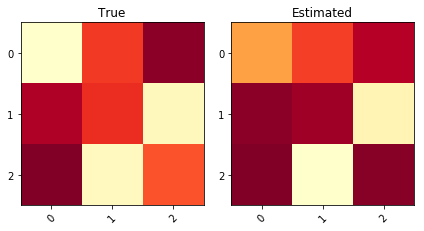

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


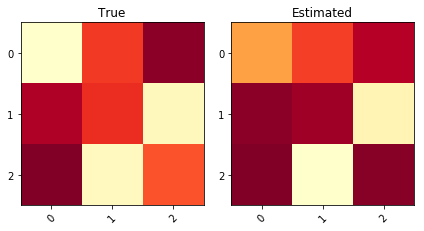

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


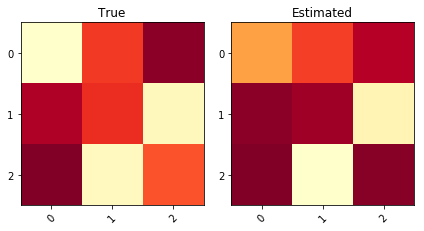

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


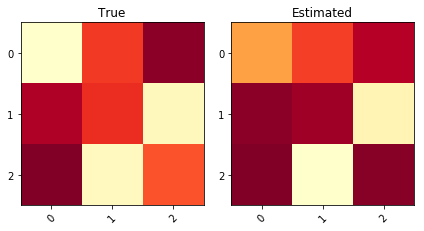

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


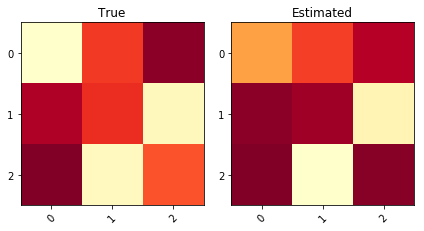

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


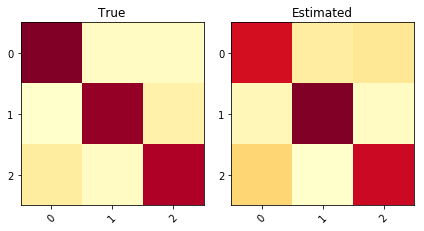

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


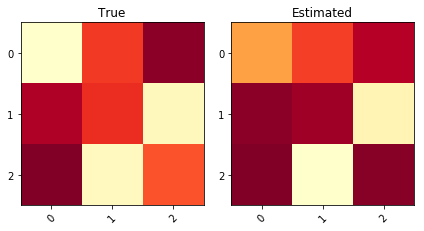

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


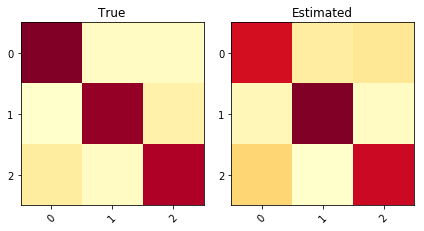

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


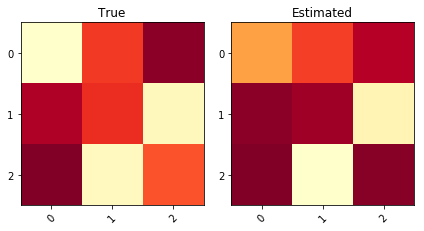

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


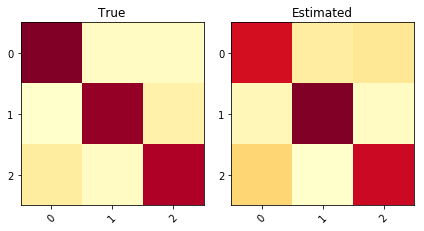

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


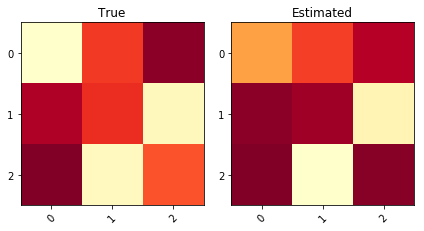

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


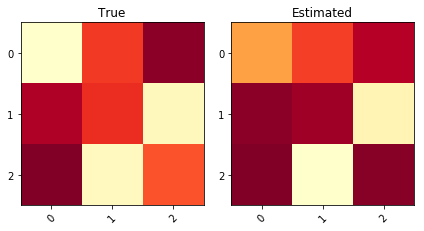

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


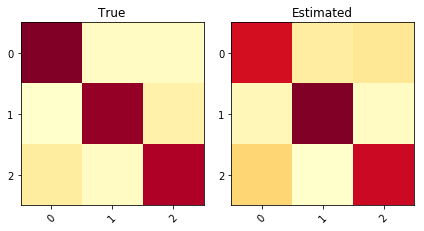

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


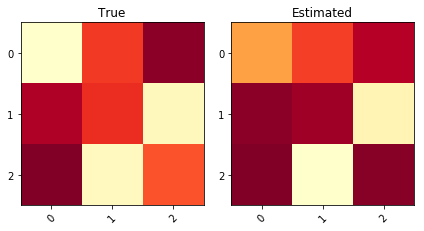

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


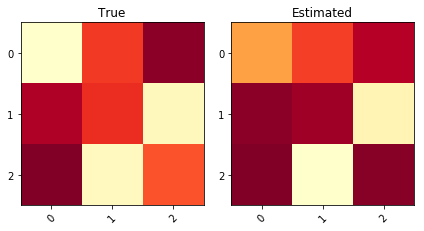

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


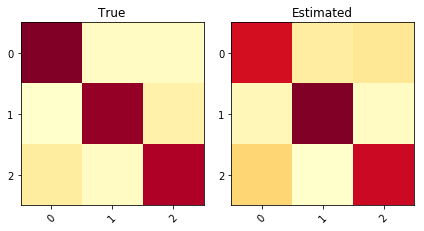

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


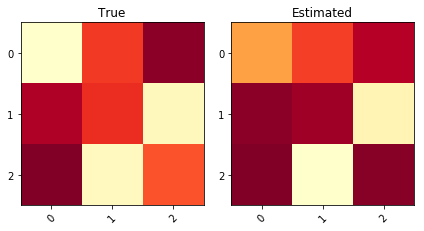

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


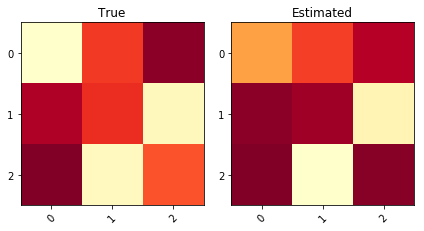

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


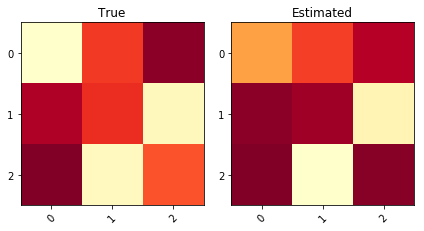

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


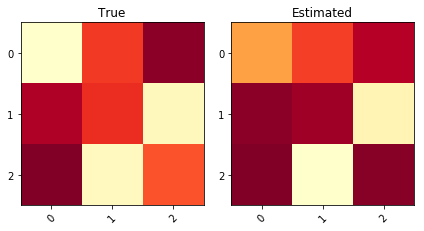

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


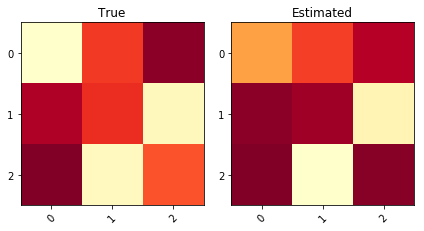

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


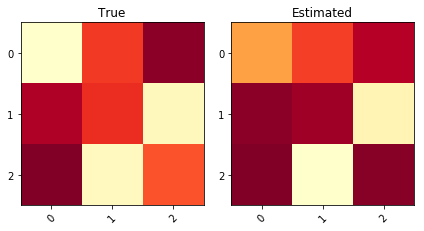

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


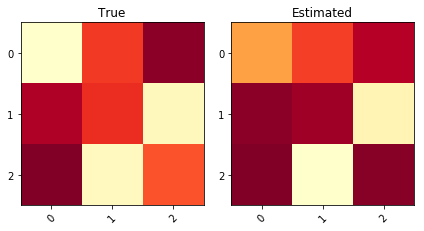

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


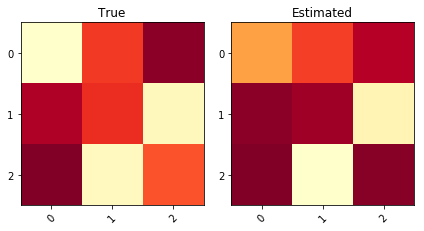

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


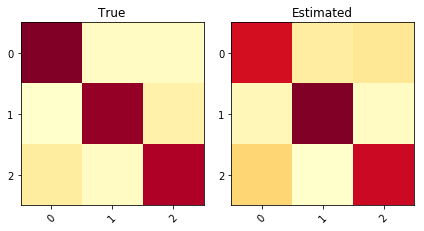

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


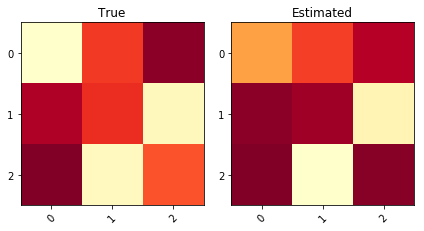

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


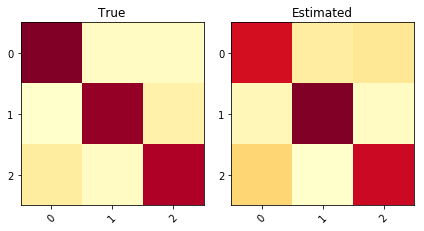

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


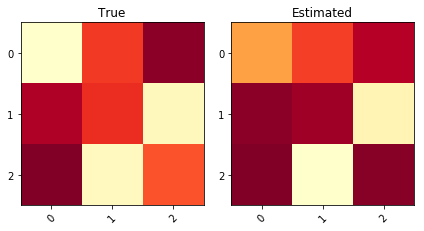

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


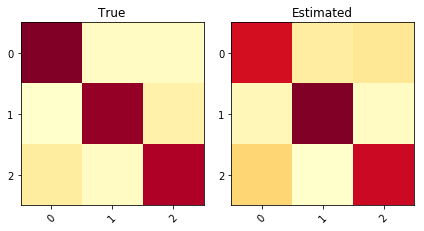

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


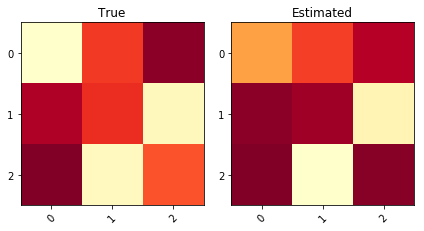

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


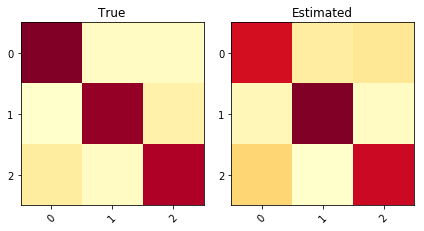

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.29963  |           0.220811 |
|  1 |       1 |   0.897037 |           0.89708  |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.894444 |           0.894994 |     0.094598 |              0.565182 |        0.16847 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.4 s, sys: 555 ms, total: 31.9 s
Wall time: 31.4 s


In [74]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

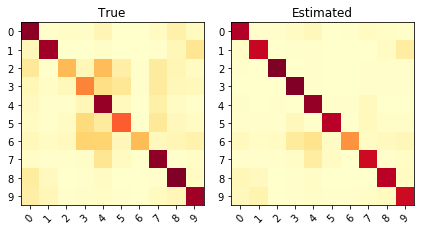

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


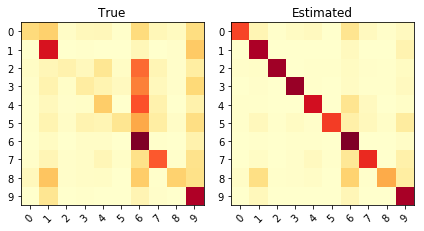

KL divergence: 0.6230	Pearson Correlation between diagonals: 0.3983


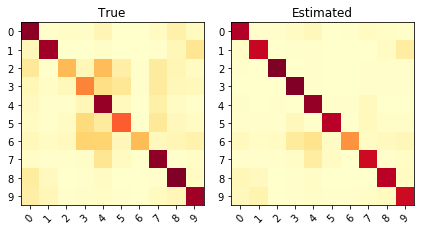

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


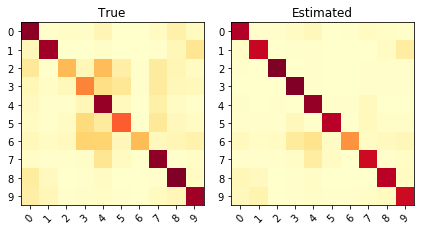

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


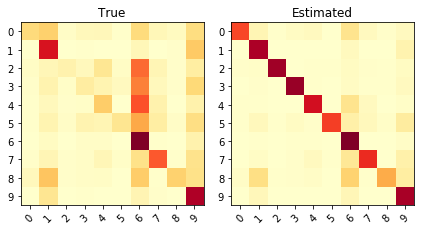

KL divergence: 0.6187	Pearson Correlation between diagonals: 0.4000


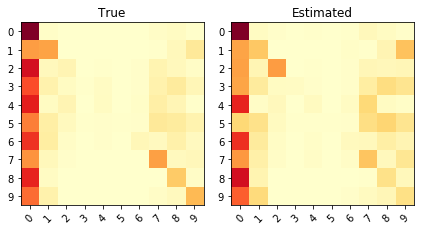

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


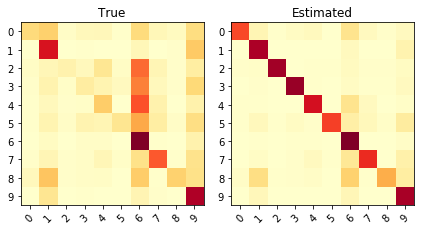

KL divergence: 0.6106	Pearson Correlation between diagonals: 0.4034


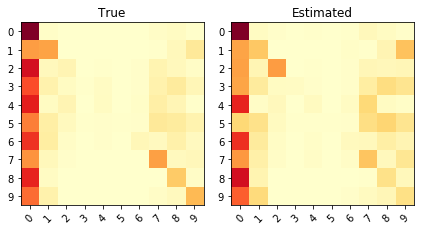

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


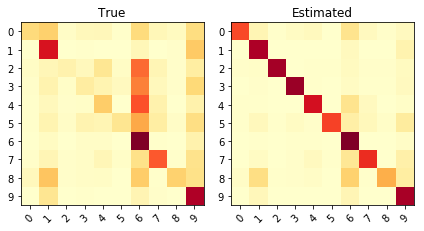

KL divergence: 0.6022	Pearson Correlation between diagonals: 0.4069


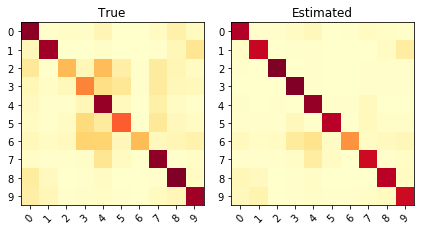

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


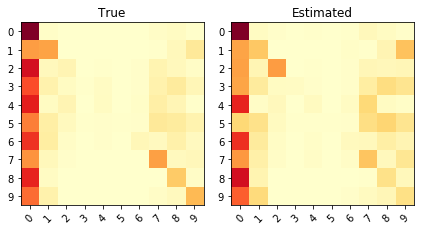

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


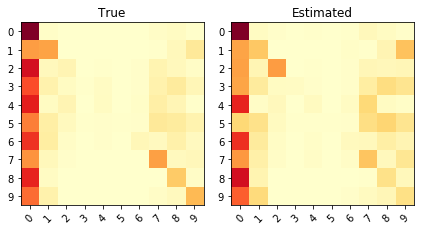

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


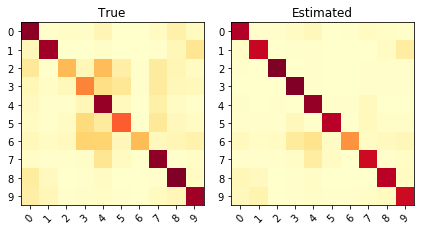

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


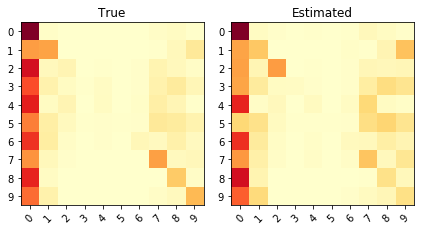

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


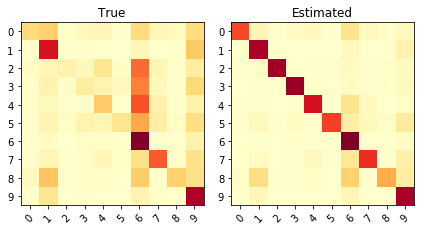

KL divergence: 0.6063	Pearson Correlation between diagonals: 0.4052
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |    0.63382 |            0.63382 |
|  1 |       1 |    0.8407  |            0.8407  |
|  2 |       2 |    0.1     |            0.1     |
|  3 |       3 |    0.65312 |            0.65312 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |    0.75984 |            0.75984 |     0.429922 |              0.428081 |       0.143167 |
+----+--------+------------+--------------------+--------------+----------------

In [34]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

### $\lambda$ random on clean data 2

In [227]:
#1,2,9,14,15,18 ----5,8,16(aprox), 19 very aprox
#revisar log loss..
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #best is lambda close to 1

Indices:  [19  8  1 15 14 18 16  4  0  9 10  2  7 13 12  6  3 17  5 11]
F1 scores:  0.9567233308497585
F1 scores:  0.9722991947952253
F1 scores:  0.9730373373417617
F1 scores:  0.9708188472037063
F1 scores:  0.956016774823882


array([[[0.52382575, 0.21659293, 0.25958132],
        [0.11623011, 0.83725768, 0.04651221],
        [0.44169099, 0.00159129, 0.55671772]],

       [[0.21783677, 0.41721678, 0.36494644],
        [0.4749662 , 0.49408818, 0.03094562],
        [0.4142501 , 0.00183745, 0.58391245]]])

In [231]:
for ind in indexs_sort[:5]:
    print("LogLoss %f "%logL_iter[ind] )

LogLoss -74753.037878 
LogLoss -74846.558465 
LogLoss -74848.771741 
LogLoss -74881.145240 
LogLoss -75019.563584 


### $\lambda$ =1 on clean data 2

In [232]:
# 0 y 1 interesantes--3 aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [3 0 1 2 4]
F1 scores: 0.955606 y LogLoss -74719.447607 
F1 scores: 0.968179 y LogLoss -74883.187174 
F1 scores: 0.960457 y LogLoss -74920.960253 
F1 scores: 0.956374 y LogLoss -75083.774056 
F1 scores: 0.351232 y LogLoss -76185.540685 


array([[[0.50777171, 0.22507155, 0.26715675],
        [0.11185078, 0.83924488, 0.04890434],
        [0.4582481 , 0.00159581, 0.54015609]],

       [[0.22760429, 0.41990971, 0.352486  ],
        [0.47839272, 0.49042606, 0.03118121],
        [0.40264624, 0.00196233, 0.59539143]]])

In [239]:
#con alfa data dependent --> 3,2 y 0 muy buenos
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.458558 y LogLoss -73051.591996 
F1 scores: 0.962240 y LogLoss -73313.658698 
F1 scores: 0.965886 y LogLoss -73497.073680 
F1 scores: 0.974446 y LogLoss -73702.008816 
F1 scores: 0.971485 y LogLoss -73704.003644 


array([[[7.05309888e-01, 6.78381229e-03, 2.87906299e-01],
        [7.35180890e-02, 9.24724807e-01, 1.75710357e-03],
        [5.01078305e-01, 2.81658016e-01, 2.17263679e-01]],

       [[4.66742009e-01, 1.93783100e-04, 5.33064208e-01],
        [6.14267012e-01, 3.16643747e-01, 6.90892417e-02],
        [1.89225399e-01, 1.86074745e-03, 8.08913853e-01]]])

### $\lambda$ random on noise data 2

In [254]:
#9,1,16,4,17 -.- aprox : 15,7,3,8 , 13 very aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda aprox to 1

Indices:  [13  1 15  9 16  2 12  7 18  3  4 17 11 19  6 14  0  5 10  8]
F1 scores: 0.888830 y LogLoss -78001.588032 
F1 scores: 0.892016 y LogLoss -78116.591164 
F1 scores: 0.884132 y LogLoss -78137.777845 
F1 scores: 0.883747 y LogLoss -78254.586413 
F1 scores: 0.883738 y LogLoss -78314.510964 


array([[[0.27134669, 0.35397641, 0.3746769 ],
        [0.44678169, 0.51668657, 0.03653173],
        [0.4222056 , 0.00645561, 0.5713388 ]],

       [[0.50628012, 0.21383676, 0.27988311],
        [0.14782917, 0.80655601, 0.04561483],
        [0.42775275, 0.00488844, 0.56735881]]])

In [255]:
matrices_encontradas[indexs_sort[1]] #-- l_0 == 1 l_1 ==0

array([[[0.08295195, 0.40093714, 0.51611091],
        [0.48669173, 0.45809595, 0.05521232],
        [0.62825357, 0.00538692, 0.36635951]],

       [[0.94113627, 0.02508032, 0.03378341],
        [0.00918393, 0.98703061, 0.00378546],
        [0.0255219 , 0.00113546, 0.97334265]]])

In [258]:
#with data dependent: 14,8,17,18,6,7
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #

Indices:  [10 16  9  1  2 19 15  0 13  5 12  6  3 11  8  7 17 14 18  4]
F1 scores: 0.569450 y LogLoss -72703.277615 
F1 scores: 0.491469 y LogLoss -72720.581623 
F1 scores: 0.508396 y LogLoss -72767.949725 
F1 scores: 0.491615 y LogLoss -72825.122112 
F1 scores: 0.507041 y LogLoss -72896.068329 


array([[[3.79349307e-01, 6.94819793e-04, 6.19955873e-01],
        [7.77944156e-01, 8.23359122e-02, 1.39719932e-01],
        [3.06555768e-01, 2.04645067e-04, 6.93239587e-01]],

       [[4.25210560e-01, 5.09417750e-01, 6.53716909e-02],
        [6.15437909e-02, 9.38092005e-01, 3.64204100e-04],
        [5.08005925e-01, 3.63402917e-01, 1.28591157e-01]]])

### $\lambda$ =1 on noise data 2

In [262]:
#1,3 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [1 3 4 0 2]
F1 scores: 0.891017 y LogLoss -77959.391833 
F1 scores: 0.886087 y LogLoss -78123.030905 
F1 scores: 0.884353 y LogLoss -78170.862790 
F1 scores: 0.882184 y LogLoss -78190.927143 
F1 scores: 0.859548 y LogLoss -78572.408112 


array([[[0.25098253, 0.35037085, 0.39864661],
        [0.44670657, 0.51498243, 0.038311  ],
        [0.4298412 , 0.00810423, 0.56205457]],

       [[0.52964153, 0.20908235, 0.26127612],
        [0.15634487, 0.79921221, 0.04444291],
        [0.41637648, 0.00626742, 0.57735611]]])

### $\lambda$ random on clean data 1

In [280]:
#15,11,10,19,9,8 -- very aprox 1,5,6
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 1,0.3,0.9

Indices:  [ 5 15 11  8 14 10 16  1 19  4  9  6 12  0  2 18 13  3 17  7]
F1 scores: 0.954411 y LogLoss -77836.820531 
F1 scores: 0.958790 y LogLoss -77941.398320 
F1 scores: 0.940030 y LogLoss -77965.365354 
F1 scores: 0.947836 y LogLoss -78038.735143 
F1 scores: 0.910642 y LogLoss -78040.768166 


array([[[0.55499299, 0.40424585, 0.04076116],
        [0.74376586, 0.24764065, 0.00859349],
        [0.46344935, 0.36092144, 0.1756292 ]],

       [[0.82776326, 0.12548399, 0.04675276],
        [0.08155971, 0.90830062, 0.01013967],
        [0.03171331, 0.04560996, 0.92267673]],

       [[0.53795303, 0.34491255, 0.11713442],
        [0.22329621, 0.75771587, 0.01898792],
        [0.09282163, 0.195167  , 0.71201137]]])

In [284]:
matrices_encontradas[indexs_sort[1]] #lambda 1,0.75,0

array([[[0.67928817, 0.28913513, 0.0315767 ],
        [0.54120412, 0.45556271, 0.00323317],
        [0.42460938, 0.25247046, 0.32292017]],

       [[0.62701399, 0.27485157, 0.09813444],
        [0.22333284, 0.76642445, 0.01024272],
        [0.09648147, 0.14086318, 0.76265535]],

       [[0.52124351, 0.36240502, 0.11635147],
        [0.24622555, 0.74312222, 0.01065222],
        [0.09708732, 0.23612256, 0.66679012]]])

### $\lambda$ =1 on clean data 1

In [273]:
# 0 y 2 , quizas el 3
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [0 4 1 2 3]
F1 scores: 0.957691 y LogLoss -77777.045732 
F1 scores: 0.949563 y LogLoss -77822.228357 
F1 scores: 0.953599 y LogLoss -77856.778807 
F1 scores: 0.948690 y LogLoss -77872.086503 
F1 scores: 0.931905 y LogLoss -77906.054126 


array([[[0.59412547, 0.36171718, 0.04415735],
        [0.66799795, 0.32474261, 0.00725944],
        [0.52856849, 0.30642452, 0.16500699]],

       [[0.52760818, 0.33752145, 0.13487037],
        [0.31600033, 0.66175519, 0.02224447],
        [0.14146238, 0.22927853, 0.62925909]],

       [[0.56413881, 0.31949401, 0.11636717],
        [0.21524957, 0.76938829, 0.01536214],
        [0.07210637, 0.21926451, 0.70862912]]])

### $\lambda$ random on noisy data 1

In [305]:
# 4,15,18
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 0.9,0.95,0.77

Indices:  [16 15 17  2 19 12 14  5 18  1  6  4  7 13 10 11  8  3  9  0]
F1 scores: 0.869044 y LogLoss -78922.915633 
F1 scores: 0.866170 y LogLoss -78982.619162 
F1 scores: 0.861920 y LogLoss -79051.791381 
F1 scores: 0.857006 y LogLoss -79139.196237 
F1 scores: 0.847250 y LogLoss -79204.031599 


array([[[0.58607908, 0.36341081, 0.05051011],
        [0.66739828, 0.32284521, 0.00975651],
        [0.493704  , 0.30487077, 0.20142523]],

       [[0.50693243, 0.34776968, 0.14529789],
        [0.31437943, 0.65691552, 0.02870504],
        [0.12305859, 0.27650573, 0.60043568]],

       [[0.60705624, 0.26678528, 0.12615848],
        [0.18890858, 0.78930815, 0.02178327],
        [0.06595133, 0.17302841, 0.76102026]]])

In [306]:
matrices_encontradas[indexs_sort[1]] #lambda 0.9,0.15,1

array([[[0.54434378, 0.39895361, 0.05670261],
        [0.69226245, 0.29917253, 0.00856502],
        [0.48889289, 0.32543488, 0.18567223]],

       [[0.88857981, 0.07739007, 0.03403012],
        [0.04260737, 0.95177684, 0.00561578],
        [0.01874574, 0.03511641, 0.94613784]],

       [[0.46865228, 0.36090133, 0.1704464 ],
        [0.28625581, 0.6858124 , 0.02793179],
        [0.11223195, 0.26951884, 0.61824921]]])

### $\lambda$ =1 on noisy data 1

In [315]:
# 1 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.871127 y LogLoss -78805.593847 
F1 scores: 0.867015 y LogLoss -78817.192683 
F1 scores: 0.849491 y LogLoss -78854.670714 
F1 scores: 0.865092 y LogLoss -78979.309951 
F1 scores: 0.866156 y LogLoss -78985.742220 


array([[[0.58714018, 0.36795373, 0.0449061 ],
        [0.69558504, 0.29376966, 0.0106453 ],
        [0.48082751, 0.31934017, 0.19983232]],

       [[0.54569706, 0.3299119 , 0.12439103],
        [0.27193291, 0.7006825 , 0.02738459],
        [0.11665229, 0.23142926, 0.65191844]],

       [[0.57664747, 0.29595247, 0.12740006],
        [0.20585552, 0.76759455, 0.02654993],
        [0.09077485, 0.19447976, 0.71474539]]])

In [259]:
Qij_gamma = np.sum(gMixture.get_qestimation(),axis=-2) #qij(gamma)
r_estimate = np.zeros((Qij_gamma.shape[0],Qij_gamma.shape[2])) #repeat estimate
for i in range(Qij_gamma.shape[0]):
    r_estimate[i] = np.tensordot(Qij_gamma[i],r_obs[i],axes=[[0],[0]])
r_estimate

array([[ 0.20453249, 25.85263166,  2.94283584],
       [ 0.12035406, 24.94385666,  0.93578928],
       [24.07822754,  4.97867884,  1.94309361],
       ...,
       [ 0.25168615, 31.56533154,  0.18298231],
       [ 7.46407726, 17.98318088,  9.55274186],
       [ 0.91988414,  0.0756443 , 27.00447157]])

In [71]:
gMixture.get_predictions(Xstd_train)

array([[0.06842059, 0.73907024, 0.19250914],
       [0.02262934, 0.94639385, 0.03097681],
       [0.4558536 , 0.44500634, 0.09914005],
       ...,
       [0.03236194, 0.94923073, 0.01840742],
       [0.30035946, 0.30898702, 0.3906535 ],
       [0.15407403, 0.0127452 , 0.8331808 ]], dtype=float32)

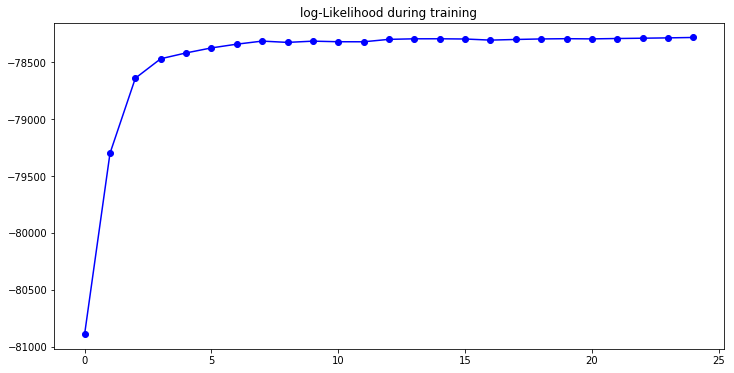

In [185]:
plt.figure(figsize=(12,6))
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.title("log-Likelihood during training")
plt.show()

In [146]:
### model over ground truth
model = clone_model(gMixture.get_basemodel())
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(Xstd_train, keras.utils.to_categorical(Z_train), batch_size=128,epochs=50)
from utils import calculate_f1_keras
print(calculate_f1_keras(model, Xstd_train, Z_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2700/2700 [==============================] - 1s 442us/step - loss: 0.7655
Epoch 2/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.7441
Epoch 3/50
2700/2700 [==============================] - 0s 34us/step - loss: 0.7239
Epoch 4/50
2700/2700 [==============================] - 0s 35us/step - loss: 0.7050
Epoch 5/50
2700/2700 [==============================] - 0s 31us/step - loss: 0.6872
Epoch 6/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.6704
Epoch 7/50
2700/2700 [==============================] - 0s 38us/step - loss: 0.6546
Epoch 8/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.6397
Epo

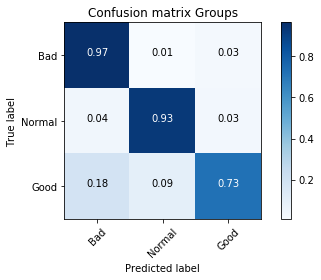

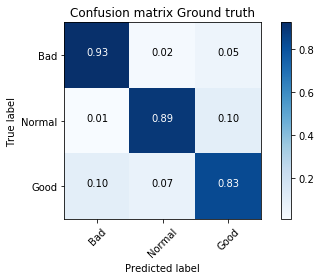

In [147]:
from utils import *
classes = ["Bad","Normal","Good"]
plot_confusion_keras(gMixture.base_model,Xstd_train,Z_train,classes,title='Confusion matrix Groups')
plot_confusion_keras(model,Xstd_train,Z_train,classes,title='Confusion matrix Ground truth')


<a id="condato"></a>
### Training module 2
---
Here we implement the iteration between **E** and **M** steps with bulks annotations $r_{itj}$.

In [ ]:
class GroupMixtureBulk(object):
    def __init__(self,input_dim,Kl=2,M=2,alpha_DD=True,epochs=1,optimizer='adam'): 
        
        
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        self.compile=False
        self.Keps = keras.backend.epsilon()
        self.priors=False #boolean of priors
        #params
        self.M = M #groups of annotators
        self.data_dependence = alpha_DD #for alpha = p(g|x) or p(g)
        self.epochs = epochs
        self.optimizer = optimizer
        
        self.seted_alphainit = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas
    def get_alpha(self):
        """Get alpha param, p(g|xi) for every data on trainig or globally p(g)"""
        return self.alphas
    def set_alpha(self,alphas_init):
        """set alpha param with a previosuly method"""
        self.alphas = alphas_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        return self.Qi_mgamma
        
    def define_model(self,tipo,*args):
        """Define the base model and other structures"""
        aux_info = None
        emb_info = None
        self.type = tipo.lower()
        if self.type =="cnn":
            info,aux_info =args
        elif self.type == "rnn":
            info,aux_info,emb_info = args            
        elif self.type == "ff" or self.type == "mlp": #classic feed forward
            start_units,deep,activation = args
            info = [start_units,deep,activation]
        elif self.type == "keras_shallow" or self.type=="keras_perceptron": 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl,self.optimizer)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        
        if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
            self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X,batch_size=None):
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=batch_size)
    
    def init_E(self,X,r):
        
        
        self.N = X.shape[0]
        #-------> init alpha
        if not self.seted_alphainit:
            self.alphas = np.random.dirichlet(np.ones(self.M),size=self.N) # random start that sum one
        
        #-------> init Majority voting
        mv_probs = majority_voting(r,repeats=True,probas=True)
        #majority voting by group...
        """
        mv_prob_groups = []
        r_sample = 0
        for l in range(self.M):
            aux_mv_probs = majority_voting(np.clip(r-r_sample,0,1e100),repeats=True,probas=True)
            r_sample = []
            for i in range(self.N):
                total_annotators = np.sum(r[i])
                ri_sample = np.random.multinomial(total_annotators/self.M, aux_mv_probs[i]) #asumming al groups have same number of annotators
                r_sample.append(ri_sample)
            r_sample = np.asarray(r_sample)
            mv_prob_groups.append(majority_voting(r_sample,repeats=True,probas=True) )
        """
        
        #-------> init q_i
        self.Qi_mgamma = np.random.rand(self.N,self.M,self.Kl) #random init
        #"""
        for i in range(self.N):            
            #for m in range(self.M):
            self.Qi_mgamma[i] = np.tensordot(self.alphas[i], mv_probs[i],axes=-1)  #a interestetnly E-step  
        
        #-------> init betas
        self.betas = np.random.rand(self.M,self.Kl,self.Kl)
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None]
        
        """
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(mv_probs[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])
            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
        """
        
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",mv_probs.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qi_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if len(priors.shape)==2:
            priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions,r): #r is data
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(predictions[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])

            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
                                                                                                                       
    def M_step(self,X,r): 
        #-------> base model
        #create the repeat "estimate"/"ground truth"
        Qi_gamma = np.sum(self.Qi_mgamma,axis=-2) #qi(gamma)
        #train to learn p(z|x)
        if "sklearn" in self.type:
            self.base_model.fit(X, np.argmax(Qi_gamma,axis=1) ) 
        else:
            history = self.base_model.fit(X,Qi_gamma,batch_size=self.batch_size,epochs=self.epochs,verbose=1) 
            
        #-------> alpha --maneja caso global y normal..
        Qi_m = np.sum(self.Qi_mgamma,axis=-1) #qi(m)
        if not self.data_dependence: #global alpha
            g_estimate = np.sum(Qi_m,axis=0)
            self.alphas[:] = g_estimate/np.sum(g_estimate,axis=-1) #p(g) 
        else:
            self.alphas = Qi_m #p(g|x)
        
        #-------> beta   # p(yo|g,z)
        for m in range(self.M):
            for j_z in range(self.Kl):
                for j_ob in range(self.Kl):
                    self.betas[m,j_z,j_ob] = np.tensordot(self.Qi_mgamma[:,m,j_z],r[:,j_ob], axes=[[0],[0]]) # ~p(yo|g,z)
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior function
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None] #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        
                                                
    def train(self,X_train,r_train,batch_size=32,iterations=250,tolerance=0.001,relative=False): #0.0001  
        
                                                  

gMixtureRaykar = GroupMixtureBulk(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=10)
###epochs=1 as Rodriges says. and batch size as default
gMixtureRaykar.Kl

In [ ]:
gMixtureRaykar = GroupMixtureBulk(X_train.shape[1:],Kl=r_obs.shape[1],M=100)

#gMixture.define_model("sklearn_logistic") #logistic necesita datos de todas la clases
gMixtureRaykar.define_model("keras_shallow")
gMixtureRaykar.set_alpha(alphas_init_Raykar)
#gMixtureRaykar.set_alpha((y_obs!=-1)*1)

#need priors!!!--lo hace mas estable
M = 100
gMixtureRaykar.define_priors(np.ones((M,r_obs.shape[1])))

logL_hist = gMixtureRaykar.train(Xstd_train,r_obs,batch_size=64,iterations=10,relative=False)